In [ ]:
# Importing libraries
# Data processing operations
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from itertools import product

# Handling warnings
import warnings
warnings.filterwarnings('ignore')

# Loading datasets from google drive
import os
import glob
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

# Clean the memory
import gc

# Libraries for ML Models XGBoost, LightGBM
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb

# Forecasting at a deparmtent level
import time
from nixtla import NixtlaClient
from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

# KPI
from sktime.performance_metrics.forecasting import mean_squared_scaled_error

Mounted at /gdrive


In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-DAH7MHvpNLT7NwzUiZ6xwP5K5Mvn2IEdBP5hVpqGnvPo49TwAlNiQHLcuzHQXC0DepaNJ7aFKA3KuO5c'
)

In [ ]:
!pip install sktime # Library for mean_squared_scaled_error

In [ ]:
# CSV files extracted into dictionary and loaded in respective dataframes
dataframes = {}
path = glob.glob(f"/gdrive/My Drive/M5 Forecasting dataset/*.csv")
for file in path:
  dataframes[file] = pd.read_csv(file)

# Storing the files in dataframes from dictionary dataframes
calendar = dataframes['/gdrive/My Drive/M5 Forecasting dataset/calendar.csv'] # datetime features
train = dataframes['/gdrive/My Drive/M5 Forecasting dataset/sales_train_validation.csv'] # train features
val = dataframes['/gdrive/My Drive/M5 Forecasting dataset/sales_train_evaluation.csv'] # validation features
price = dataframes['/gdrive/My Drive/M5 Forecasting dataset/sell_prices.csv'] # selling price feature


In [ ]:
# Shape of the dataframes
print("Calendar:",calendar.shape)
print("Sales train:",train.shape)
print("Sales val:",val.shape)
print("Price:",price.shape)

Calendar: (1969, 14)
Sales train: (30490, 1919)
Sales val: (30490, 1947)
Price: (6841121, 4)


In [ ]:
# Converting the columns dataframes to data type int16
for d in range(1,1913):
    col = 'd_' + str(d)
    train[col] = train[col].astype(np.int16)

for d in range(1914,1941):
    col = 'd_' + str(d)
    val[col] = val[col].astype(np.int16)

In [ ]:
# Downcasting
train_bd = np.round(train.memory_usage().sum()/(1024*1024),1)
val_bd = np.round(val.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
price_bd = np.round(price.memory_usage().sum()/(1024*1024),1)


cols = train.dtypes.index.tolist()
types = train.dtypes.values.tolist()
train.dtypes.index, train.dtypes.values

(Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
        'd_2', 'd_3', 'd_4',
        ...
        'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
        'd_1911', 'd_1912', 'd_1913'],
       dtype='object', length=1919),
 array([dtype('O'), dtype('O'), dtype('O'), ..., dtype('int16'),
        dtype('int16'), dtype('int64')], dtype=object))

In [ ]:
# Function to reduce the memory usage of csv files
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

train = downcast(train)
val = downcast(val)
price = downcast(price)
calendar = downcast(calendar)

In [ ]:
# Dataframes' memory after downcasting
train_ad = np.round(train.memory_usage().sum()/(1024*1024),1)
val_ad = np.round(val.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(price.memory_usage().sum()/(1024*1024),1)

In [ ]:
dic = {'DataFrame':['train','val','calendar','price'],
       'Before downcasting':[train_bd,val_bd,calendar_bd,price_bd],
       'After downcasting':[train_ad,val_ad,calendar_ad,prices_ad]}

# Plot to display the memory usage before and after downcast
memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame',
                 var_name = 'Status', value_name = 'Memory (MB)') ; memory
memory.sort_values(by='Memory (MB)', inplace=True) ; memory
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status',
             barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn',title='Effect of Downcasting')

In [ ]:
# Unpivot of train and val dataframe from wide 'd' format to long 'd' format
def data_preprocess_overall(data,id_lst):
    data = pd.melt(data,id_vars=id_lst,
        var_name='d',value_name='units_sold').dropna()
    return data

In [ ]:
def agg_data(data,groupby_vars):
    """
    Aggregate of train and val at higher level
    Inclusion of date features (date, weekday)
    Feature creation: event_flag : capturesspecial events,
                      is_christmas : zero sales on christmas day
    Sort of date features in ascending order
    """
    if groupby_vars is not None:
        data = data.groupby(['d']+groupby_vars)['units_sold'].sum().reset_index()
        data = data.merge(right=calendar,on=['d'])
        data['event_flag'] = np.where(data['event_name_1'].notna(), 1, 0)
        data['is_christmas'] = np.where(data['event_name_1']=='Christmas',1,0)
        data['date'] = data['date'].sort_values(ascending=True)

    return data

In [ ]:
def price_agg(data,groupby_lst):
    """
    Aggregation of price at dynamic group level
    and capture of statistical price features like mean, min, max, median
    """
    data = data.groupby(groupby_lst)['sell_price'].agg(['mean', 'min', 'max','median'])
    data.rename(columns={'mean':'avg_price',
                         'min':'min_price',
                         'max':'max_price',
                         'median':'median_price'},inplace=True)
    return data

In [ ]:
def resample_daily_to_weekly(data,grp_cols):
    """
    Resample of daily data to weekly data
    Categorical variables: snap_CA, snap_TX, snap_WI, event_flag, is_christmas summarised at a weekly level
    New feature creation:
    1.  High_sale_months: To capture the effect during high season months (Feb through May)
    2.  Seasons: Winter, Spring, Summer and Fall

    """
  # Drop of columns department id
    data.set_index('date', inplace=True)
   # print(data)
    data = data.groupby(grp_cols)

    data = data.resample('W').agg({'units_sold': 'sum',
                                            'snap_CA':'max',
                                            'snap_TX':'max',
                                            'snap_WI':'max',
                                            'event_flag':'max',
                                            'is_christmas':'max'}).reset_index()

    # Inclusion of datetime columns like year,month
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month

    # Inclusion of feature to capture high sales months(Feb:2,mar:3,apr:4 and may:5)
    f=lambda x: 1 if x==2 or x==3 or x==4 or x==5 else 0
    data['high_sale_months']=data['month'].map(f)

    # Inclusion of season column
    seasons = {
                  1: 'Winter',
                  2: 'Spring',
                  3: 'Summer',
                  4: 'Fall'
      }

    data['season'] = (data['date'].dt.month%12 + 3)//3
    data['season'] = data['season'].map(seasons)
    return data

In [ ]:
def plot_predictions(testing_dates, y_test, prediction1,prediction2):
    """
    Function to capture visualizaiton of validation and predicted data
    """
    df_test = pd.DataFrame({"weekly_dates": testing_dates, "actual": y_test, "prediction1": prediction1,"prediction2": prediction2})
    figure, ax = plt.subplots(figsize=(10, 5))

    df_test.plot(ax=ax, label="Actual", x="weekly_dates", y="actual")
    df_test.plot(ax=ax, label="Prediction_XGB", x="weekly_dates", y="prediction1")
    df_test.plot(ax=ax, label="Prediction_LGB", x="weekly_dates", y="prediction2")
    plt.legend(["Actual", "Prediction_XGB","Prediction_LGB"])
    plt.show()

In [ ]:

def train_and_validate_models(data1,data2,*cols,rmsse_xgb_values=[],rmsse_lgb_values=[]):
    """
  Function for model creation, training and validation
  Parameters:
  - data1, data2 to store the train and val data
  - Filter of data based on granularity captured through *cols
  - rmsse_xgb_values and rmsse_lgb_values to store the rmsse values for each model
  - Feature Engg at weekly level:
  1. Lag features
  2. Rolling window features
  3. Expanding window features
  - Data Imputation: Imputation of inf or nan to 0
  - Encoding of categorical variables pd.dummies
  - Model1: XGBoost
  - Model2: LightGBM
  - RMSSE: Root Mean Squared Scaled Error

   """
    col1 = cols[0] if len(cols) > 0 else None
    col2 = cols[1] if len(cols) > 1 else None

    if col2:
        store_category_combinations = data1[[col1, col2]].drop_duplicates()
    else:
        store_category_combinations = data1[[col1]].drop_duplicates()

    for index, row in store_category_combinations.iterrows():
        filter1 = row[col1]
        state = filter1.split('_')[0]
        if state in(['CA','WI','TX']):
            snap_column = 'snap_' + state

        if col2:
            filter2 = row[col2]
            train = data1[(data1[col1] == filter1) & (data1[col2] == filter2)]
            val = data2[(data2[col1] == filter1) & (data2[col2] == filter2)]
        else:

            train = data1[data1[col1] == filter1]
            val = data2[data2[col1] == filter1]

        lags = [3,4,6,7,8,10,11,12,13]
        for lag in lags:
            train[f'lag_{lag}_week'] = train['units_sold'].shift(lag)
            train[f'lag_{lag}_week'].fillna(0, inplace=True)

            val[f'lag_{lag}_week'] = val['units_sold'].shift(lag)
            val[f'lag_{lag}_week'].fillna(0, inplace=True)

        # Inclusion of rolling_window and expanding functions
        rolling_val = [3,4,5,6,7,8,10]
        for value in rolling_val:
            train[f'rolling_window_{value}'] = train['units_sold'].rolling(window=value).mean()
            train[f'rolling_window_{value}'].fillna(0, inplace=True)
            train['expanding_units_sold_mean'] = train['units_sold'].transform(lambda x: x.expanding().mean()).astype(np.float16)
            train['expanding_units_sold_mean'].replace([np.inf, -np.inf], 0, inplace=True)
            train['expanding_units_sold_mean'].fillna(0, inplace=True)

            val[f'rolling_window_{value}'] = val['units_sold'].rolling(window=value).mean()
            val[f'rolling_window_{value}'].fillna(0, inplace=True)
            val['expanding_units_sold_mean'] = val['units_sold'].transform(lambda x: x.expanding().mean()).astype(np.float16)
            val['expanding_units_sold_mean'].replace([np.inf, -np.inf], 0, inplace=True)
            val['expanding_units_sold_mean'].fillna(0, inplace=True)


        cat_cols = ['season']

        price_cols = ['avg_price','min_price','max_price','median_price']
        date_cols = ['year','month','high_sale_months','event_flag','season','is_christmas']


        if state in(['CA','WI','TX']):
            train_encoded = pd.get_dummies(train[price_cols + date_cols + [snap_column,f'rolling_window_{value}',f'lag_{lag}_week','expanding_units_sold_mean']],columns=cat_cols)
            val_encoded = pd.get_dummies(val[price_cols + date_cols + [snap_column,f'rolling_window_{value}',f'lag_{lag}_week','expanding_units_sold_mean']],columns=cat_cols)

        else:
            train_encoded = pd.get_dummies(train[price_cols + date_cols + [f'rolling_window_{value}',f'lag_{lag}_week','expanding_units_sold_mean']],columns=cat_cols)
            val_encoded = pd.get_dummies(val[price_cols + date_cols + [f'rolling_window_{value}',f'lag_{lag}_week','expanding_units_sold_mean']],columns=cat_cols)

        train_encoded, val_encoded = train_encoded.align(val_encoded, join='left', axis=1, fill_value=0)

        # Target variable
        y_train = train['units_sold']
        y_val = val['units_sold']


        # XGBoost DMatrix format
        dtrain = xgb.DMatrix(train_encoded, label=y_train)
        dval = xgb.DMatrix(val_encoded, label=y_val)

        xgb_params = {
        'alpha': 10,
        'lambda': 10,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_data_in_leaf':10
          }


        # XGBoost model
        model1 = xgb.XGBRegressor(params=xgb_params,eval_metric='rmse',n_estimators=250, learning_rate=0.04,verbose=-1)
        model2 = lgb.LGBMRegressor(min_data_in_leaf=10,objective ='poisson',n_estimators=250, learning_rate=0.04,
                                   colsample_bytree=0.8,max_depth=8,verbose=-1)


        # Train the model
        model1.fit(train_encoded, y_train, eval_set=[(val_encoded, y_val)], verbose=True)
        model2.fit(train_encoded, y_train, eval_set=[(val_encoded, y_val)])

        prediction1_train = model1.predict(train_encoded)
        prediction2_train = model2.predict(train_encoded)

        prediction1_val = model1.predict(val_encoded)
        prediction2_val = model2.predict(val_encoded)

        print(filter1)
        if col2:
            filter2 = row[col2]
            print(filter2)
        plot_predictions(val['date'], y_val, prediction1_val,prediction2_val)


        # RMSSE KPI for XGBoost
        print("RMSSE XGB:")
        rmsse_xgb = np.sqrt(mean_squared_scaled_error(y_val, prediction1_val, y_train=y_train, squared=True))
        print(rmsse_xgb)
        rmsse_xgb_values.append(rmsse_xgb)

        # RMSSE KPI for LightGBM
        print("RMSSE LGB:")
        rmsse_lgb = np.sqrt(mean_squared_scaled_error(y_val, prediction2_val, y_train=y_train, squared=True))
        print(rmsse_lgb)
        rmsse_lgb_values.append(rmsse_lgb)
        #Feature importance
        feature_importance = model1.get_booster().get_score(importance_type='gain')
        keys = list(feature_importance.keys())
        values = list(feature_importance.values())

        data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
        data.nlargest(20, columns="score").plot(kind='barh', figsize = (10,6)) ## plot top 40 features
        plt.show()

    return rmsse_xgb_values,rmsse_lgb_values


In [ ]:
price['cat_id'] = price['item_id'].str.split('_').str[0]
price['dept_id'] = price['item_id'].str.split('_').str[:2].str.join('_')
price['state_id'] = price['store_id'].str.split('_').str[0]

train = data_preprocess_overall(train, ['id','item_id','dept_id','cat_id','store_id','state_id'])
val = data_preprocess_overall(val,['id','item_id','dept_id','cat_id','store_id','state_id'])


In [ ]:
gc.collect()

19

## Aggregation Level : State and Category

In [ ]:
"""
Aggregation Level : State and Category
Function agg_data: Aggregate of train and val at higher level,
                   including date features
Function price_agg: Aggregation of sell price at dynamic level
"""
groupby_state_cat = ['cat_id','state_id']

train_state_cat = agg_data(train,groupby_state_cat)
days_train = train_state_cat['d'].unique().tolist()
val_state_cat = val[~(val['d'].isin(days_train))]
val_state_cat = agg_data(val_state_cat,groupby_state_cat)
del days_train

# Store and category
price_state_cat = price_agg(price,['state_id','cat_id'])

# Function call to resample daily data to weekly
train_state_cat = resample_daily_to_weekly(train_state_cat,['state_id','cat_id'])
val_state_cat = resample_daily_to_weekly(val_state_cat,['state_id','cat_id'])

# Merge of train and val with price features
train_state_cat = train_state_cat.merge(price_state_cat,on=['cat_id','state_id']).drop_duplicates()
val_state_cat = val_state_cat.merge(price_state_cat,on=['cat_id','state_id']).drop_duplicates()

[0]	validation_0-rmse:15708.84057
[1]	validation_0-rmse:16321.04004
[2]	validation_0-rmse:16911.10002
[3]	validation_0-rmse:17479.72814
[4]	validation_0-rmse:18024.44840
[5]	validation_0-rmse:18552.42356
[6]	validation_0-rmse:19058.28145
[7]	validation_0-rmse:19227.10160
[8]	validation_0-rmse:19391.44378
[9]	validation_0-rmse:19551.42777
[10]	validation_0-rmse:20002.41055
[11]	validation_0-rmse:20154.01935
[12]	validation_0-rmse:20301.60151
[13]	validation_0-rmse:20445.26468
[14]	validation_0-rmse:20585.11151
[15]	validation_0-rmse:20721.24128
[16]	validation_0-rmse:20853.75381
[17]	validation_0-rmse:20982.74472
[18]	validation_0-rmse:21108.30604
[19]	validation_0-rmse:21230.52972
[20]	validation_0-rmse:21349.50416
[21]	validation_0-rmse:21465.31341
[22]	validation_0-rmse:21578.04273
[23]	validation_0-rmse:21639.45119
[24]	validation_0-rmse:21742.99851
[25]	validation_0-rmse:21843.78923
[26]	validation_0-rmse:22459.42528
[27]	validation_0-rmse:22822.44404
[28]	validation_0-rmse:23414.0

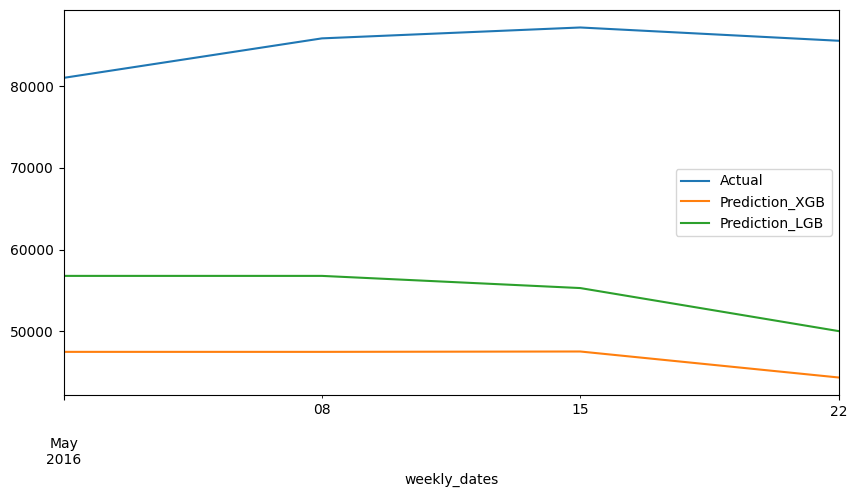

RMSSE XGB:
6.240711923287073
RMSSE LGB:
4.963857470400416


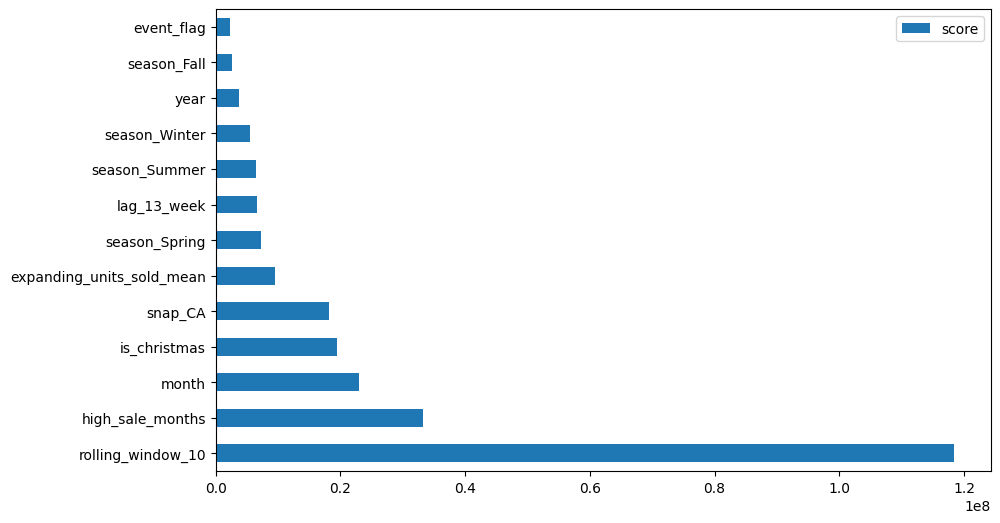

[0]	validation_0-rmse:2844.08122
[1]	validation_0-rmse:2850.13456
[2]	validation_0-rmse:2856.17555
[3]	validation_0-rmse:2862.20057
[4]	validation_0-rmse:2868.20456
[5]	validation_0-rmse:2874.18351
[6]	validation_0-rmse:2880.13344
[7]	validation_0-rmse:2886.05115
[8]	validation_0-rmse:2891.93277
[9]	validation_0-rmse:2916.70225
[10]	validation_0-rmse:2922.20510
[11]	validation_0-rmse:2946.08558
[12]	validation_0-rmse:2951.20348
[13]	validation_0-rmse:2974.18911
[14]	validation_0-rmse:2978.92065
[15]	validation_0-rmse:3036.10674
[16]	validation_0-rmse:3092.16542
[17]	validation_0-rmse:3147.11725
[18]	validation_0-rmse:3200.98297
[19]	validation_0-rmse:3253.78337
[20]	validation_0-rmse:3305.53946
[21]	validation_0-rmse:3356.27051
[22]	validation_0-rmse:3405.99589
[23]	validation_0-rmse:3454.73584
[24]	validation_0-rmse:3504.88127
[25]	validation_0-rmse:3553.12468
[26]	validation_0-rmse:3599.53667
[27]	validation_0-rmse:3644.18726
[28]	validation_0-rmse:3687.14242
[29]	validation_0-rmse:3

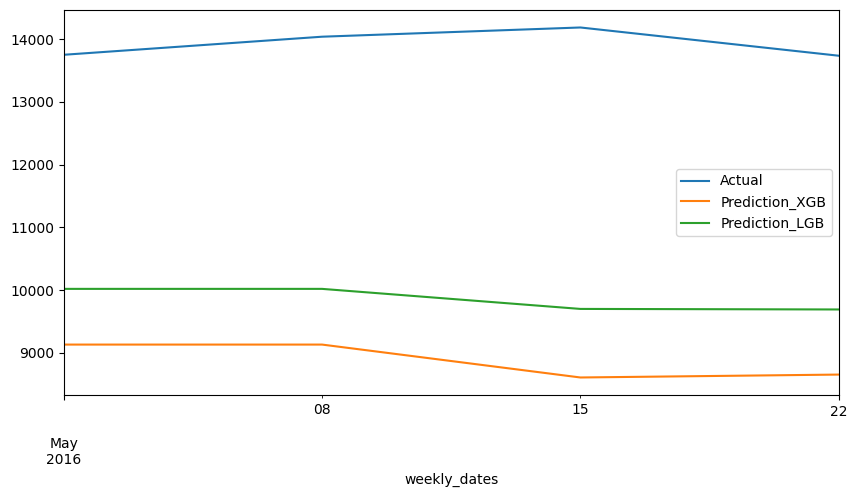

RMSSE XGB:
4.324398690642933
RMSSE LGB:
3.4869697598381295


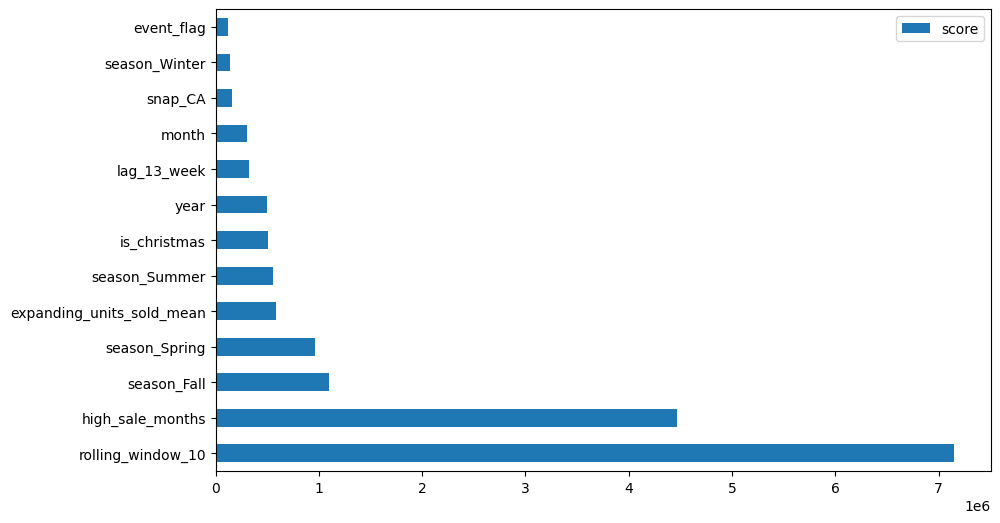

[0]	validation_0-rmse:7996.85619
[1]	validation_0-rmse:7987.02279
[2]	validation_0-rmse:7977.38760
[3]	validation_0-rmse:7967.94541
[4]	validation_0-rmse:7958.69192
[5]	validation_0-rmse:7949.62326
[6]	validation_0-rmse:7940.73573
[7]	validation_0-rmse:7932.02509
[8]	validation_0-rmse:7923.48970
[9]	validation_0-rmse:8064.94247
[10]	validation_0-rmse:8056.74432
[11]	validation_0-rmse:8277.31080
[12]	validation_0-rmse:8401.50064
[13]	validation_0-rmse:8393.78264
[14]	validation_0-rmse:8590.55086
[15]	validation_0-rmse:8699.98540
[16]	validation_0-rmse:8692.71908
[17]	validation_0-rmse:8735.72607
[18]	validation_0-rmse:8833.20842
[19]	validation_0-rmse:8826.36760
[20]	validation_0-rmse:8967.56611
[21]	validation_0-rmse:9053.73702
[22]	validation_0-rmse:9136.63811
[23]	validation_0-rmse:9216.39306
[24]	validation_0-rmse:9293.12230
[25]	validation_0-rmse:9366.93792
[26]	validation_0-rmse:9437.95274
[27]	validation_0-rmse:9506.27098
[28]	validation_0-rmse:9534.40203
[29]	validation_0-rmse:9

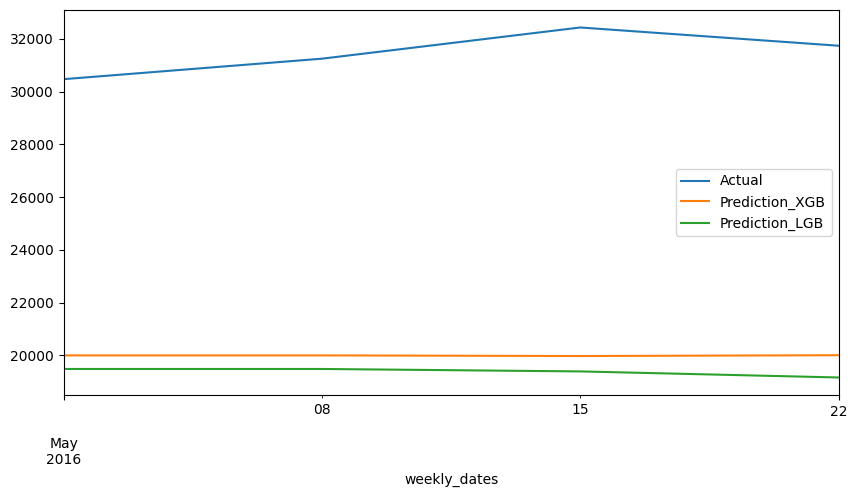

RMSSE XGB:
7.2400868422274725
RMSSE LGB:
7.628465663176398


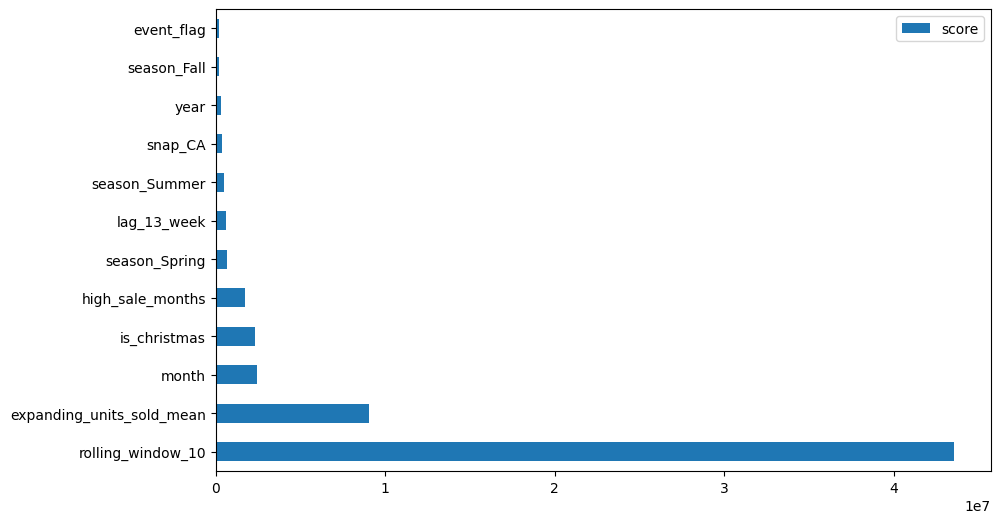

[0]	validation_0-rmse:7147.53034
[1]	validation_0-rmse:7190.70285
[2]	validation_0-rmse:7233.97994
[3]	validation_0-rmse:7245.40927
[4]	validation_0-rmse:7295.89254
[5]	validation_0-rmse:7346.28626
[6]	validation_0-rmse:7357.93143
[7]	validation_0-rmse:7407.10505
[8]	validation_0-rmse:7455.81744
[9]	validation_0-rmse:7467.16196
[10]	validation_0-rmse:7552.05098
[11]	validation_0-rmse:7769.82463
[12]	validation_0-rmse:7935.92726
[13]	validation_0-rmse:8139.18952
[14]	validation_0-rmse:8209.23915
[15]	validation_0-rmse:8422.93061
[16]	validation_0-rmse:8622.09760
[17]	validation_0-rmse:8703.43662
[18]	validation_0-rmse:8889.26853
[19]	validation_0-rmse:8964.95220
[20]	validation_0-rmse:9138.28956
[21]	validation_0-rmse:9305.29164
[22]	validation_0-rmse:9461.34792
[23]	validation_0-rmse:9649.93946
[24]	validation_0-rmse:9801.10407
[25]	validation_0-rmse:10010.57431
[26]	validation_0-rmse:10213.66800
[27]	validation_0-rmse:10410.55066
[28]	validation_0-rmse:10601.38731
[29]	validation_0-rm

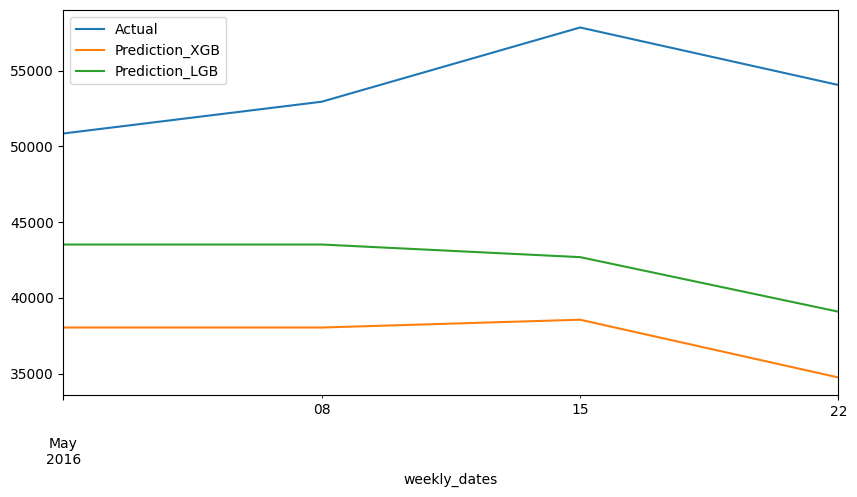

RMSSE XGB:
3.566464160283225
RMSSE LGB:
2.5896039194838214


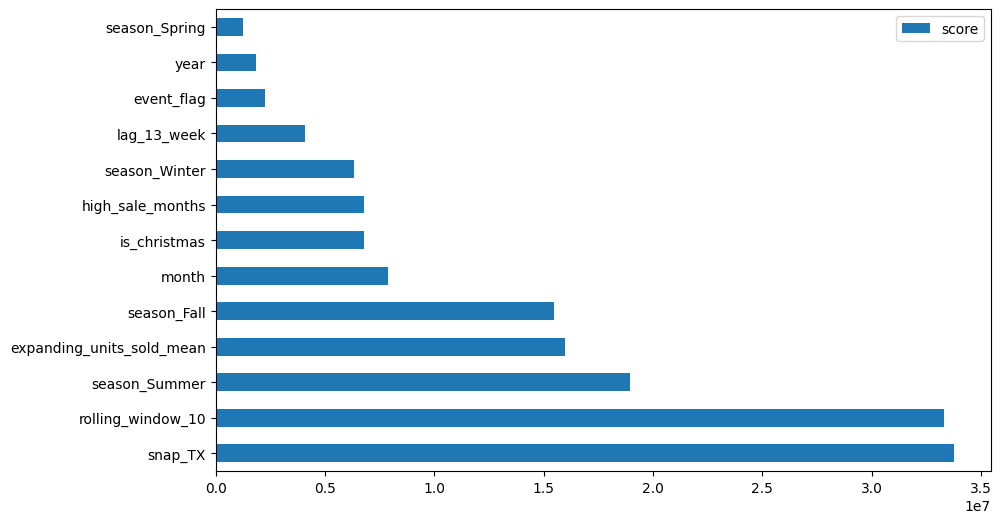

[0]	validation_0-rmse:2168.11713
[1]	validation_0-rmse:2179.56482
[2]	validation_0-rmse:2190.58685
[3]	validation_0-rmse:2201.19861
[4]	validation_0-rmse:2211.41537
[5]	validation_0-rmse:2221.25181
[6]	validation_0-rmse:2230.72179
[7]	validation_0-rmse:2236.82216
[8]	validation_0-rmse:2245.61761
[9]	validation_0-rmse:2252.87139
[10]	validation_0-rmse:2259.85445
[11]	validation_0-rmse:2266.57682
[12]	validation_0-rmse:2273.04788
[13]	validation_0-rmse:2277.75434
[14]	validation_0-rmse:2282.23935
[15]	validation_0-rmse:2286.58949
[16]	validation_0-rmse:2314.44699
[17]	validation_0-rmse:2341.24881
[18]	validation_0-rmse:2334.66430
[19]	validation_0-rmse:2328.25526
[20]	validation_0-rmse:2352.39225
[21]	validation_0-rmse:2375.61347
[22]	validation_0-rmse:2397.95366
[23]	validation_0-rmse:2419.44632
[24]	validation_0-rmse:2425.16582
[25]	validation_0-rmse:2430.73294
[26]	validation_0-rmse:2436.15204
[27]	validation_0-rmse:2441.42648
[28]	validation_0-rmse:2451.54959
[29]	validation_0-rmse:2

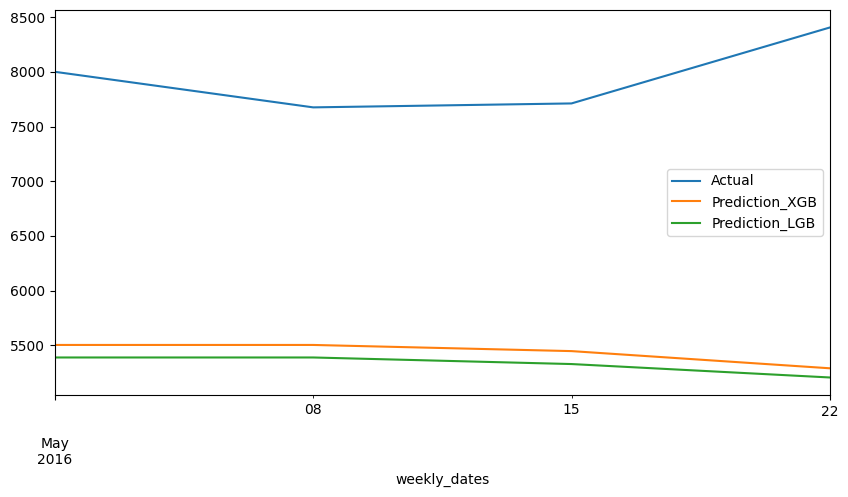

RMSSE XGB:
5.461154114301803
RMSSE LGB:
5.686939074493938


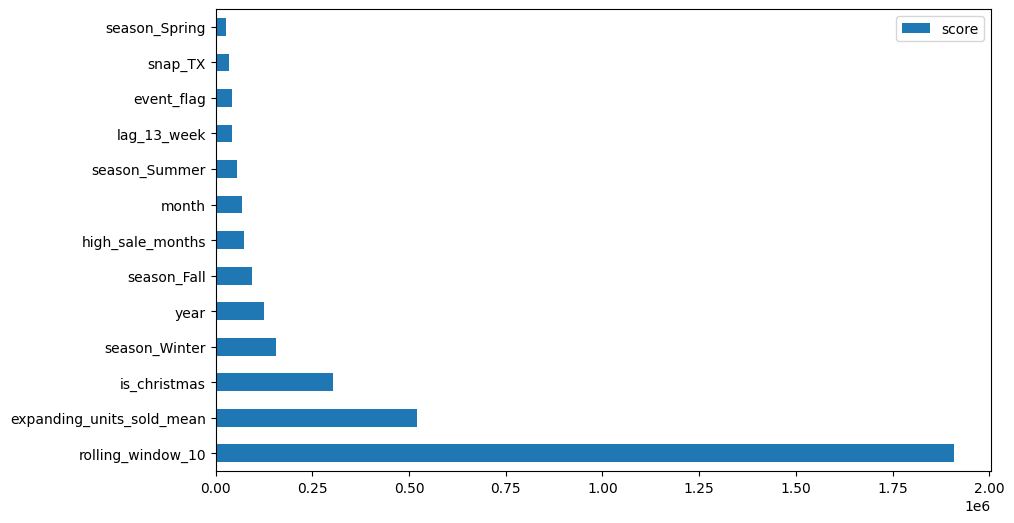

[0]	validation_0-rmse:4792.77647
[1]	validation_0-rmse:4921.10714
[2]	validation_0-rmse:5044.65886
[3]	validation_0-rmse:5163.60194
[4]	validation_0-rmse:5278.10307
[5]	validation_0-rmse:5388.32270
[6]	validation_0-rmse:5434.80726
[7]	validation_0-rmse:5533.88412
[8]	validation_0-rmse:5558.75908
[9]	validation_0-rmse:5582.84157
[10]	validation_0-rmse:5606.15492
[11]	validation_0-rmse:5691.28724
[12]	validation_0-rmse:5728.66778
[13]	validation_0-rmse:5764.99007
[14]	validation_0-rmse:5800.41218
[15]	validation_0-rmse:5846.39675
[16]	validation_0-rmse:5916.70204
[17]	validation_0-rmse:5959.98037
[18]	validation_0-rmse:5978.03542
[19]	validation_0-rmse:6018.76150
[20]	validation_0-rmse:6058.26869
[21]	validation_0-rmse:6073.28877
[22]	validation_0-rmse:6088.00862
[23]	validation_0-rmse:6089.14193
[24]	validation_0-rmse:6126.46889
[25]	validation_0-rmse:6162.51880
[26]	validation_0-rmse:6163.58633
[27]	validation_0-rmse:6173.05390
[28]	validation_0-rmse:6251.04619
[29]	validation_0-rmse:6

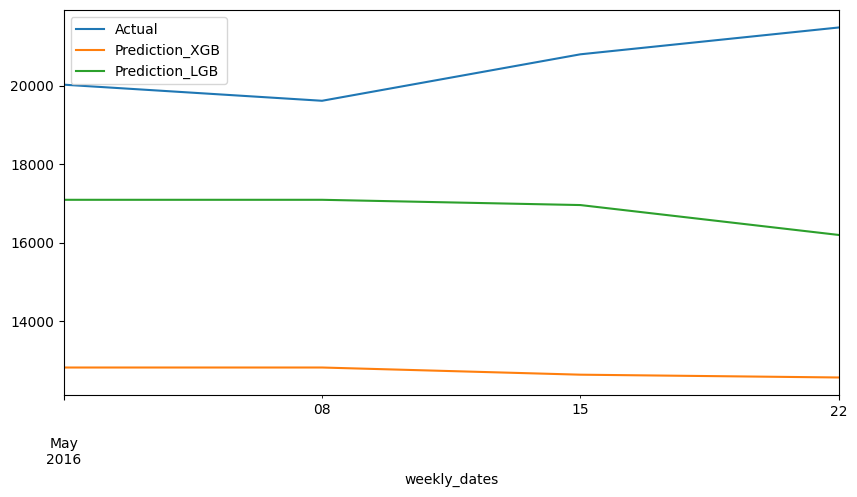

RMSSE XGB:
6.66568209527152
RMSSE LGB:
3.2386372040869333


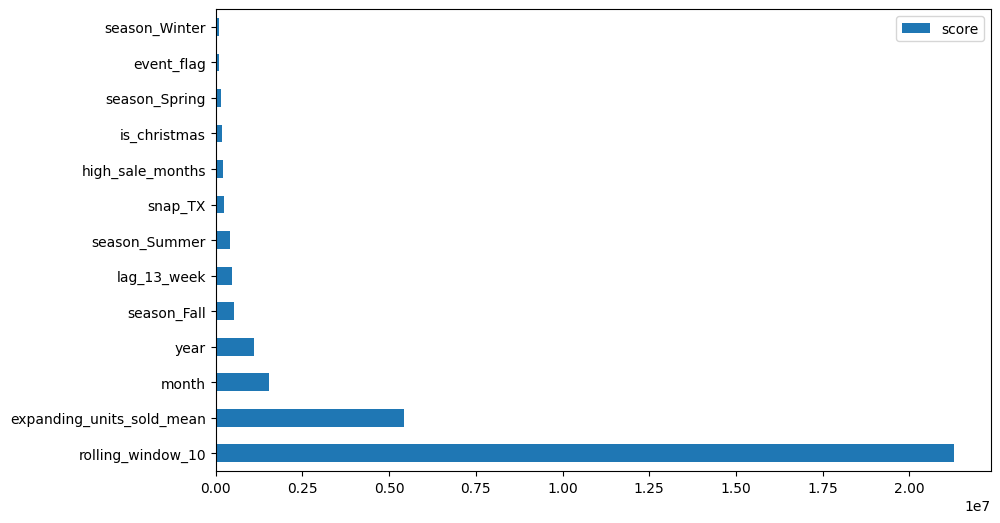

[0]	validation_0-rmse:24018.95285
[1]	validation_0-rmse:24285.30000
[2]	validation_0-rmse:24565.67858
[3]	validation_0-rmse:24843.15592
[4]	validation_0-rmse:25100.90341
[5]	validation_0-rmse:25370.97160
[6]	validation_0-rmse:25636.55437
[7]	validation_0-rmse:25904.10933
[8]	validation_0-rmse:26159.95107
[9]	validation_0-rmse:26419.21195
[10]	validation_0-rmse:26671.14681
[11]	validation_0-rmse:26925.68944
[12]	validation_0-rmse:27168.27400
[13]	validation_0-rmse:27582.91761
[14]	validation_0-rmse:27817.98742
[15]	validation_0-rmse:28143.39553
[16]	validation_0-rmse:28452.48488
[17]	validation_0-rmse:28658.44685
[18]	validation_0-rmse:29005.01308
[19]	validation_0-rmse:29193.57861
[20]	validation_0-rmse:29452.52261
[21]	validation_0-rmse:29628.55933
[22]	validation_0-rmse:29867.20181
[23]	validation_0-rmse:30097.21755
[24]	validation_0-rmse:30208.14049
[25]	validation_0-rmse:30431.48317
[26]	validation_0-rmse:30544.34900
[27]	validation_0-rmse:30756.84366
[28]	validation_0-rmse:31139.4

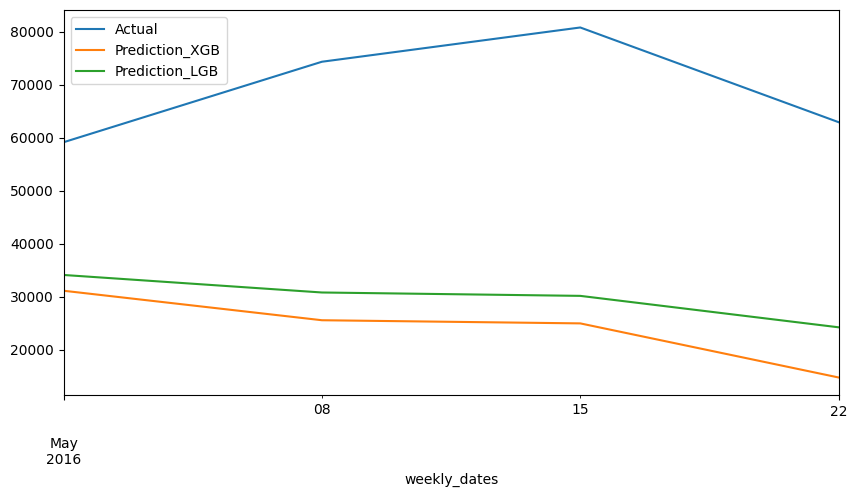

RMSSE XGB:
6.103197376315647
RMSSE LGB:
5.34006602602903


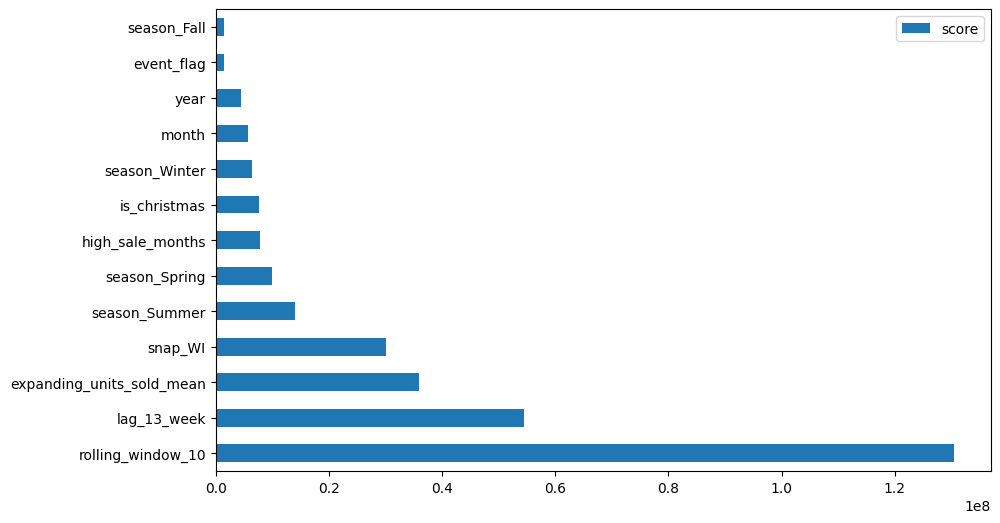

[0]	validation_0-rmse:1665.82731
[1]	validation_0-rmse:1685.96614
[2]	validation_0-rmse:1700.29935
[3]	validation_0-rmse:1715.02653
[4]	validation_0-rmse:1728.66545
[5]	validation_0-rmse:1747.07089
[6]	validation_0-rmse:1760.03869
[7]	validation_0-rmse:1779.54940
[8]	validation_0-rmse:1796.58868
[9]	validation_0-rmse:1814.87655
[10]	validation_0-rmse:1832.46173
[11]	validation_0-rmse:1848.16593
[12]	validation_0-rmse:1878.82764
[13]	validation_0-rmse:1908.37629
[14]	validation_0-rmse:1922.56525
[15]	validation_0-rmse:1950.16817
[16]	validation_0-rmse:1963.41509
[17]	validation_0-rmse:1989.22072
[18]	validation_0-rmse:2014.08886
[19]	validation_0-rmse:2038.05400
[20]	validation_0-rmse:2066.58226
[21]	validation_0-rmse:2094.19982
[22]	validation_0-rmse:2120.85877
[23]	validation_0-rmse:2127.80979
[24]	validation_0-rmse:2153.80915
[25]	validation_0-rmse:2178.14944
[26]	validation_0-rmse:2184.62697
[27]	validation_0-rmse:2194.98146
[28]	validation_0-rmse:2195.50185
[29]	validation_0-rmse:2

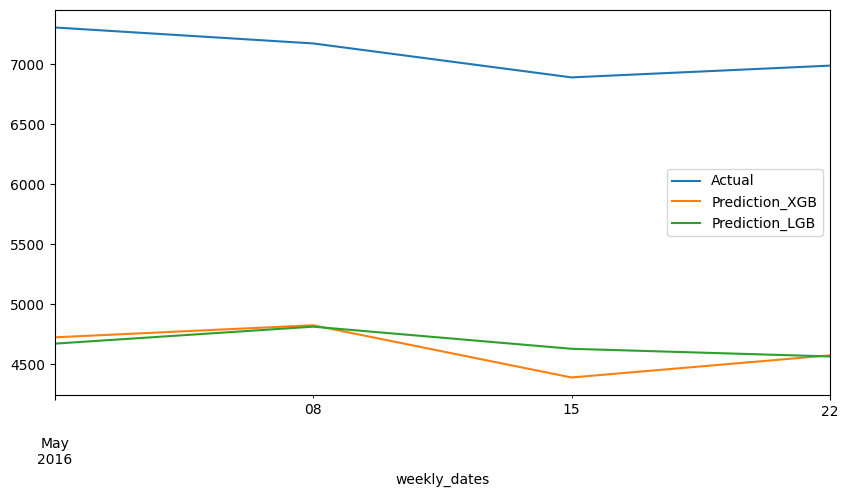

RMSSE XGB:
4.114919456545616
RMSSE LGB:
4.0495564238966235


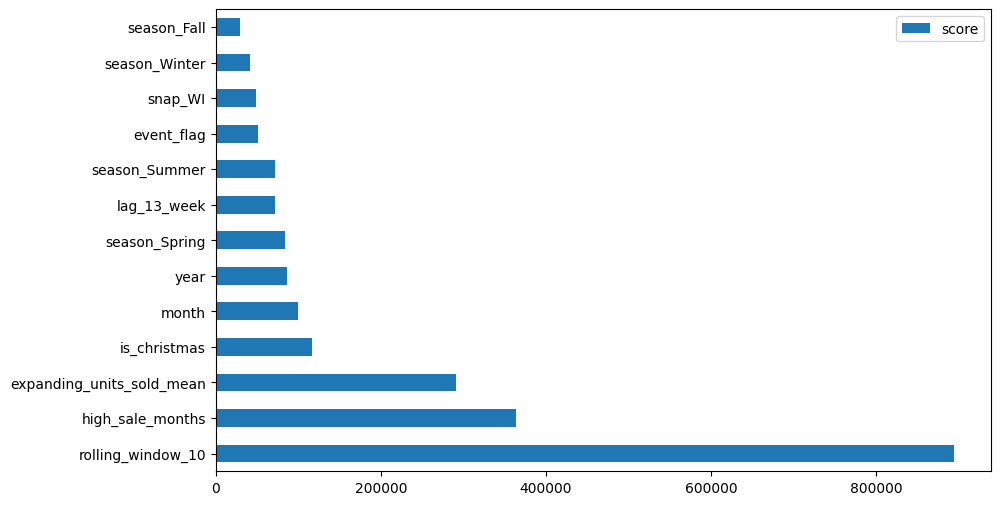

[0]	validation_0-rmse:5394.01511
[1]	validation_0-rmse:5356.59687
[2]	validation_0-rmse:5232.54102
[3]	validation_0-rmse:5198.35411
[4]	validation_0-rmse:5003.74060
[5]	validation_0-rmse:4948.77924
[6]	validation_0-rmse:4843.40330
[7]	validation_0-rmse:4742.11556
[8]	validation_0-rmse:4714.07997
[9]	validation_0-rmse:4552.18030
[10]	validation_0-rmse:4526.28341
[11]	validation_0-rmse:4500.90480
[12]	validation_0-rmse:4417.69272
[13]	validation_0-rmse:4277.27714
[14]	validation_0-rmse:4255.40124
[15]	validation_0-rmse:4233.96339
[16]	validation_0-rmse:4197.28865
[17]	validation_0-rmse:4161.34822
[18]	validation_0-rmse:4142.63787
[19]	validation_0-rmse:4093.72190
[20]	validation_0-rmse:4046.11224
[21]	validation_0-rmse:3988.88700
[22]	validation_0-rmse:3944.97912
[23]	validation_0-rmse:3943.89950
[24]	validation_0-rmse:3942.84203
[25]	validation_0-rmse:3941.80625
[26]	validation_0-rmse:3966.68057
[27]	validation_0-rmse:3965.63475
[28]	validation_0-rmse:3988.87190
[29]	validation_0-rmse:3

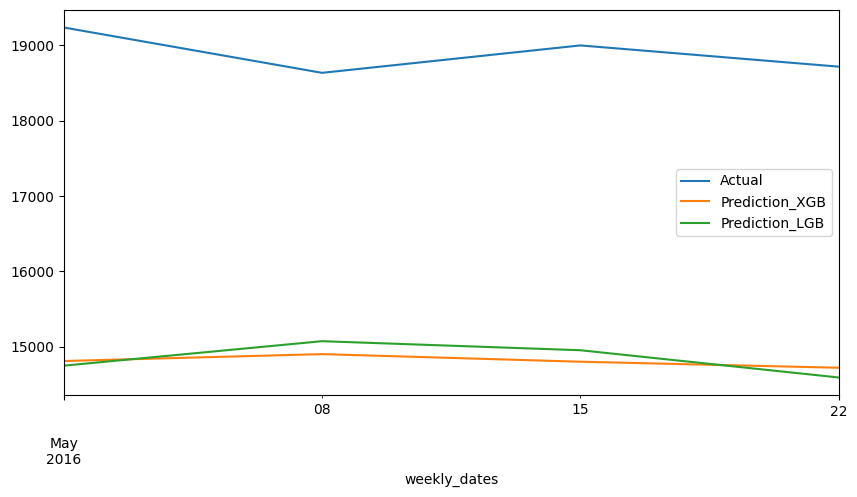

RMSSE XGB:
2.5089337382702563
RMSSE LGB:
2.491849873263596


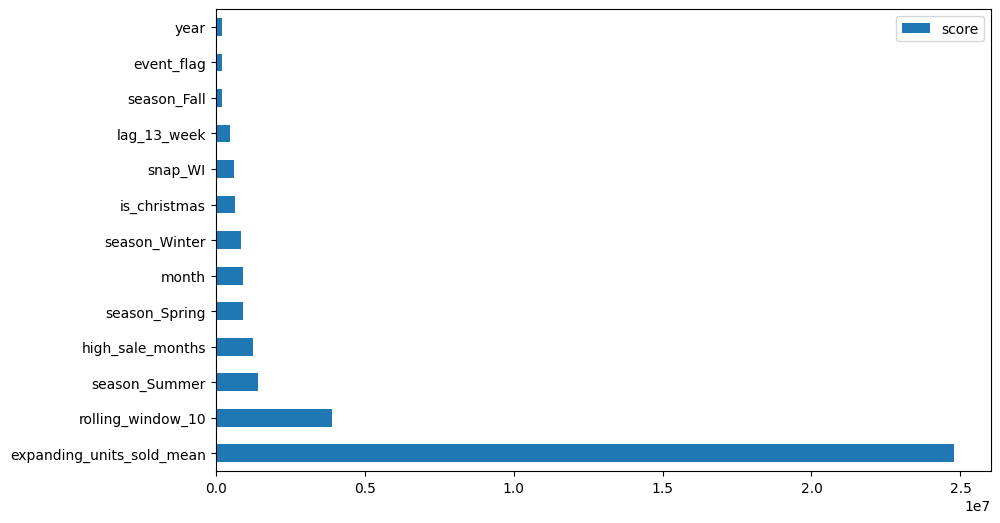

In [ ]:
# ML Models at State and Catgory level with rmsse values
rmsse_lgb = {}
rmsse_xgb = {}

rmsse_xgb_values = []
rmsse_lgb_values = []

rmsse_xgb_statecat,rmsse_lgb_statecat = train_and_validate_models(train_state_cat,val_state_cat,'state_id','cat_id',rmsse_xgb_values,rmsse_lgb_values)
rmsse_lgb['State and category'] = round(np.mean(rmsse_lgb_statecat),3)
rmsse_xgb['State and category'] = round(np.mean(rmsse_xgb_statecat),3)
del rmsse_xgb_values,rmsse_lgb_values,rmsse_xgb_statecat,rmsse_lgb_statecat


In [ ]:
gc.collect()

54671

In [ ]:
rmsse_lgb

{'State and category': 4.334}

## Aggregation Level : State and Department

In [ ]:
"""
Aggregation Level : State and Department
Function agg_data: Aggregate of train and val at higher level,
                   including date features
Function price_agg: Aggregation of sell price at dynamic level

"""
groupby_state_dept = ['dept_id','state_id']

train_state_dept = agg_data(train,groupby_state_dept)
days_train = train_state_dept['d'].unique().tolist()
val_state_dept = val[~(val['d'].isin(days_train))]
val_state_dept = agg_data(val_state_dept,groupby_state_dept)
del days_train

# Function call
price_state_dept = price_agg(price,['state_id','dept_id'])

# Function call to resample daily data to weekly
train_state_dept = resample_daily_to_weekly(train_state_dept,['state_id','dept_id'])
val_state_dept = resample_daily_to_weekly(val_state_dept,['state_id','dept_id'])

# Merge of train and val dataframes with price features
train_state_dept = train_state_dept.merge(price_state_dept,on=['dept_id','state_id']).drop_duplicates()
val_state_dept = val_state_dept.merge(price_state_dept,on=['dept_id','state_id']).drop_duplicates()

[0]	validation_0-rmse:2631.47000
[1]	validation_0-rmse:2658.06859
[2]	validation_0-rmse:2704.06592
[3]	validation_0-rmse:2729.22562
[4]	validation_0-rmse:2771.80889
[5]	validation_0-rmse:2829.40038
[6]	validation_0-rmse:2869.00471
[7]	validation_0-rmse:2922.12267
[8]	validation_0-rmse:2973.34416
[9]	validation_0-rmse:2996.74131
[10]	validation_0-rmse:3046.07327
[11]	validation_0-rmse:3113.36500
[12]	validation_0-rmse:3178.07206
[13]	validation_0-rmse:3240.29183
[14]	validation_0-rmse:3300.11791
[15]	validation_0-rmse:3359.05883
[16]	validation_0-rmse:3393.14714
[17]	validation_0-rmse:3426.10336
[18]	validation_0-rmse:3439.49767
[19]	validation_0-rmse:3469.69847
[20]	validation_0-rmse:3498.89583
[21]	validation_0-rmse:3501.97441
[22]	validation_0-rmse:3504.99133
[23]	validation_0-rmse:3548.44339
[24]	validation_0-rmse:3550.53140
[25]	validation_0-rmse:3552.57759
[26]	validation_0-rmse:3554.58306
[27]	validation_0-rmse:3556.54829
[28]	validation_0-rmse:3592.52550
[29]	validation_0-rmse:3

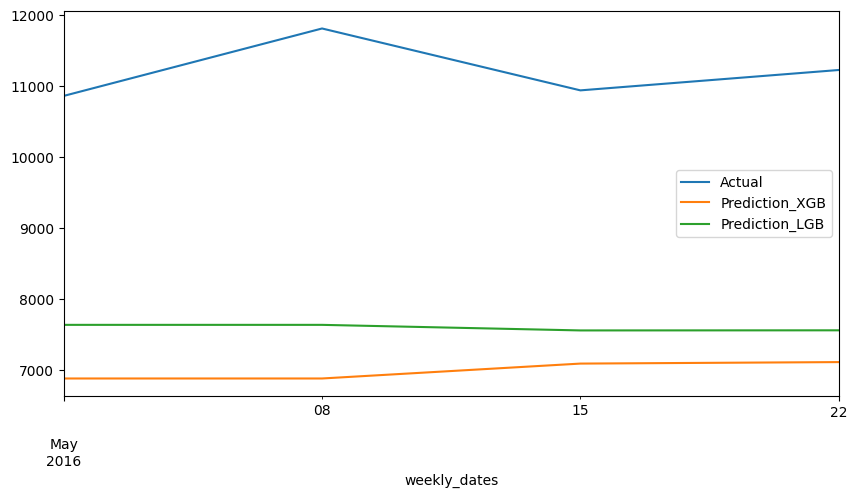

RMSSE XGB:
4.022145489543422
RMSSE LGB:
3.444042493940944


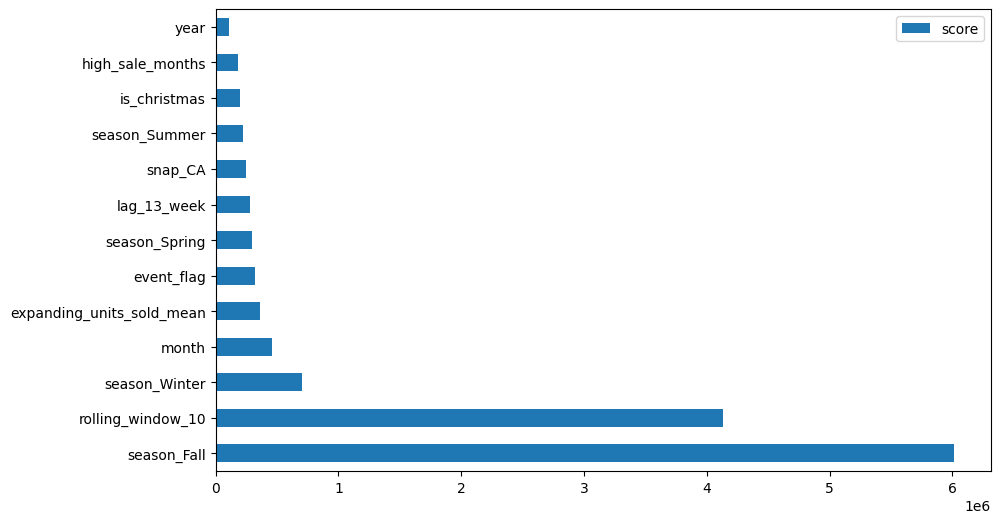

[0]	validation_0-rmse:4500.67962
[1]	validation_0-rmse:4508.08959
[2]	validation_0-rmse:4515.31430
[3]	validation_0-rmse:4522.34925
[4]	validation_0-rmse:4529.19143
[5]	validation_0-rmse:4533.89557
[6]	validation_0-rmse:4542.26967
[7]	validation_0-rmse:4568.02419
[8]	validation_0-rmse:4570.75481
[9]	validation_0-rmse:4594.66057
[10]	validation_0-rmse:4635.35980
[11]	validation_0-rmse:4636.78838
[12]	validation_0-rmse:4641.22034
[13]	validation_0-rmse:4661.01550
[14]	validation_0-rmse:4676.20928
[15]	validation_0-rmse:4681.72201
[16]	validation_0-rmse:4695.14079
[17]	validation_0-rmse:4710.10764
[18]	validation_0-rmse:4750.69537
[19]	validation_0-rmse:4757.80199
[20]	validation_0-rmse:4768.03870
[21]	validation_0-rmse:4772.43324
[22]	validation_0-rmse:4784.51502
[23]	validation_0-rmse:4828.34084
[24]	validation_0-rmse:4873.37357
[25]	validation_0-rmse:4877.24066
[26]	validation_0-rmse:4890.15462
[27]	validation_0-rmse:4919.02424
[28]	validation_0-rmse:4919.25904
[29]	validation_0-rmse:4

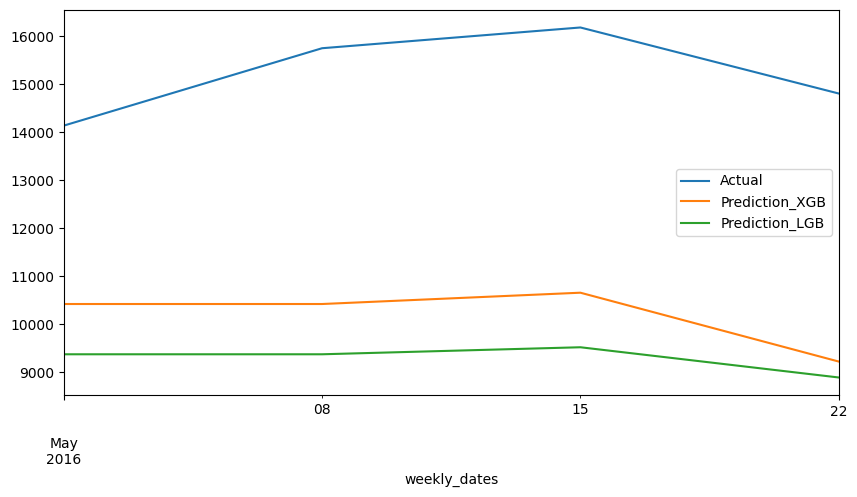

RMSSE XGB:
3.1072008851529493
RMSSE LGB:
3.641440510356226


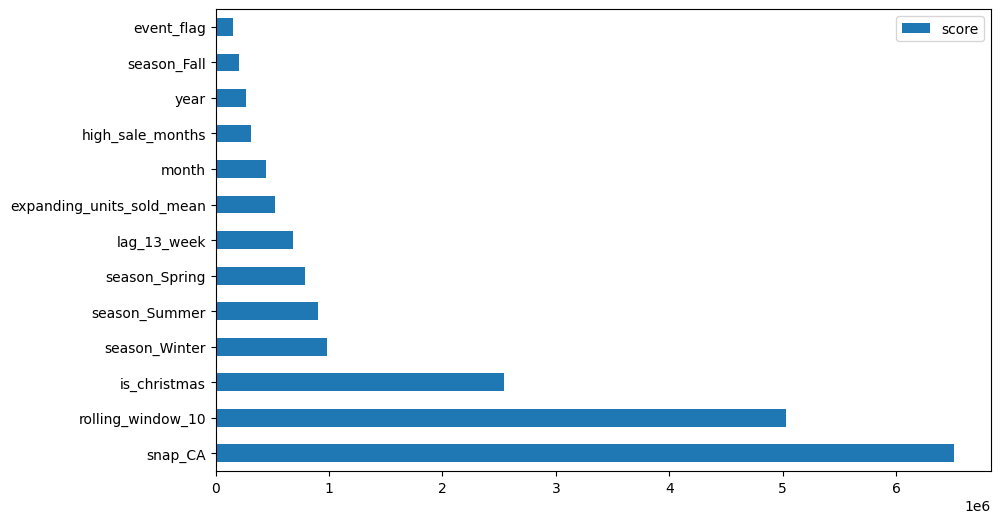

[0]	validation_0-rmse:8535.74431
[1]	validation_0-rmse:9065.71823
[2]	validation_0-rmse:9531.41600
[3]	validation_0-rmse:9980.23096
[4]	validation_0-rmse:10458.97103
[5]	validation_0-rmse:10900.16321
[6]	validation_0-rmse:11317.71602
[7]	validation_0-rmse:11745.78086
[8]	validation_0-rmse:12047.12870
[9]	validation_0-rmse:12412.63091
[10]	validation_0-rmse:12765.39431
[11]	validation_0-rmse:13105.13174
[12]	validation_0-rmse:13358.43741
[13]	validation_0-rmse:13700.32036
[14]	validation_0-rmse:14015.20096
[15]	validation_0-rmse:14239.00446
[16]	validation_0-rmse:14530.61293
[17]	validation_0-rmse:14743.23207
[18]	validation_0-rmse:14947.99505
[19]	validation_0-rmse:15208.21752
[20]	validation_0-rmse:15471.51253
[21]	validation_0-rmse:15653.03076
[22]	validation_0-rmse:15897.09282
[23]	validation_0-rmse:16117.54125
[24]	validation_0-rmse:16278.45214
[25]	validation_0-rmse:16433.40512
[26]	validation_0-rmse:16668.91814
[27]	validation_0-rmse:16812.26398
[28]	validation_0-rmse:17008.69589

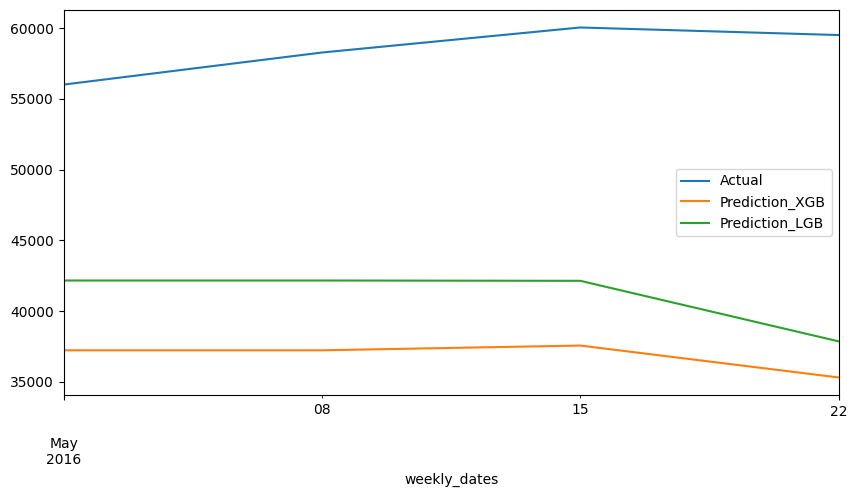

RMSSE XGB:
4.847254625012886
RMSSE LGB:
3.9305569928029658


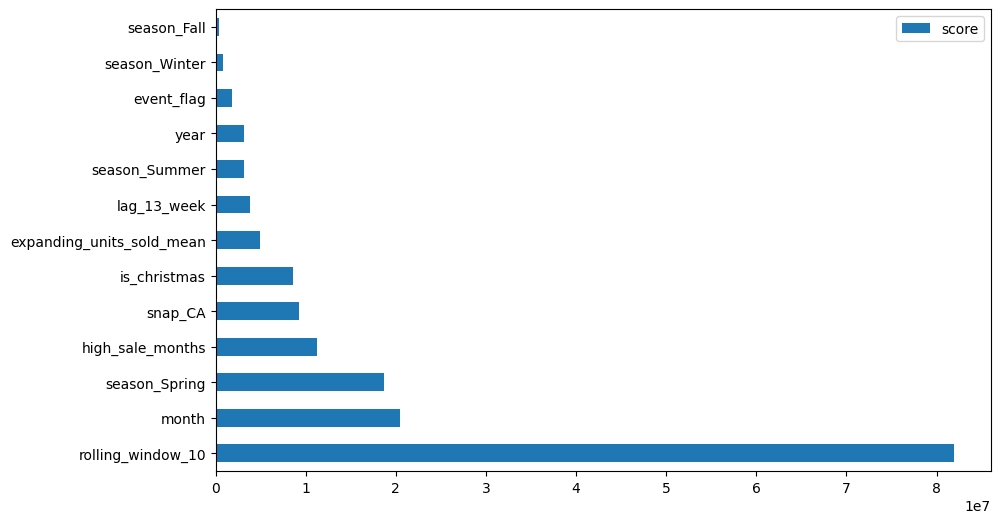

[0]	validation_0-rmse:2341.97938
[1]	validation_0-rmse:2447.32527
[2]	validation_0-rmse:2549.54633
[3]	validation_0-rmse:2648.73163
[4]	validation_0-rmse:2744.96587
[5]	validation_0-rmse:2838.33486
[6]	validation_0-rmse:2928.92045
[7]	validation_0-rmse:3016.80415
[8]	validation_0-rmse:3102.06506
[9]	validation_0-rmse:3184.77990
[10]	validation_0-rmse:3265.02289
[11]	validation_0-rmse:3342.86726
[12]	validation_0-rmse:3418.38482
[13]	validation_0-rmse:3491.64352
[14]	validation_0-rmse:3562.71073
[15]	validation_0-rmse:3631.65076
[16]	validation_0-rmse:3698.52721
[17]	validation_0-rmse:3763.40179
[18]	validation_0-rmse:3826.33340
[19]	validation_0-rmse:3887.38099
[20]	validation_0-rmse:3946.59968
[21]	validation_0-rmse:4004.04471
[22]	validation_0-rmse:4059.76921
[23]	validation_0-rmse:4054.49590
[24]	validation_0-rmse:4049.40693
[25]	validation_0-rmse:4097.70582
[26]	validation_0-rmse:4144.15459
[27]	validation_0-rmse:4191.46400
[28]	validation_0-rmse:4236.97660
[29]	validation_0-rmse:4

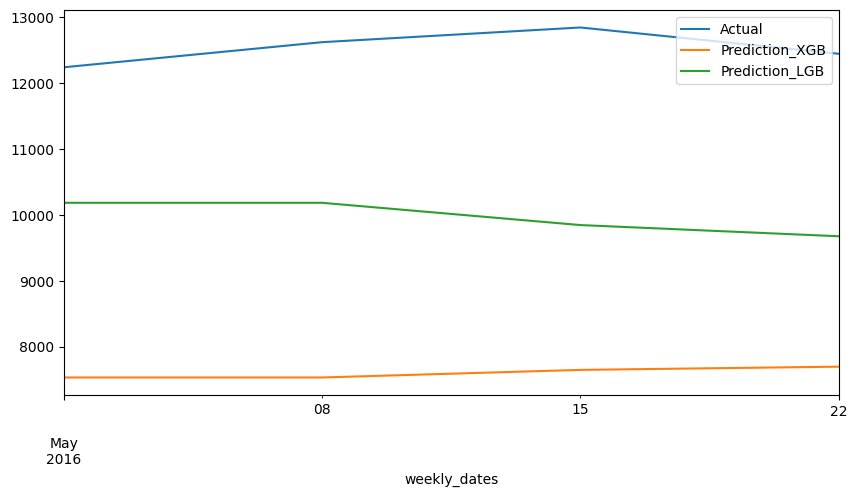

RMSSE XGB:
4.37709890219982
RMSSE LGB:
2.2950029682368323


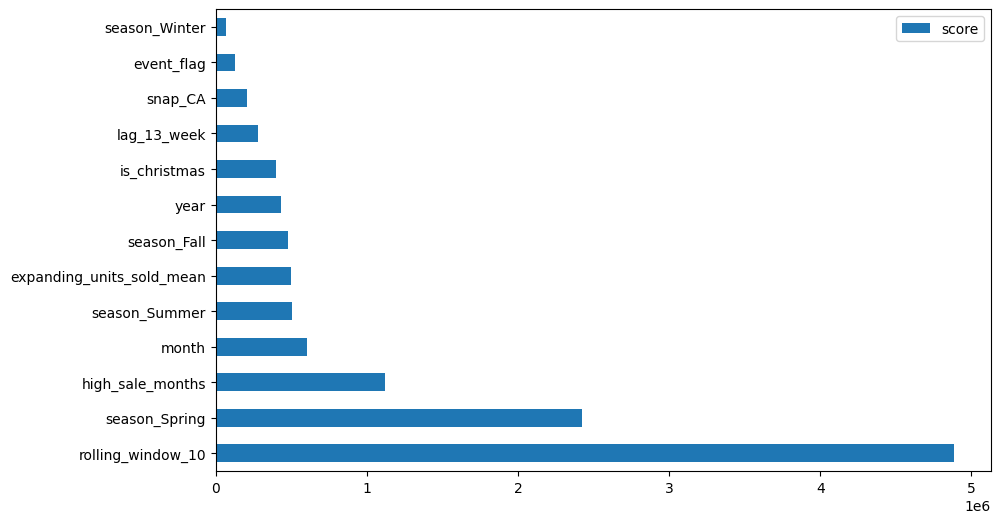

[0]	validation_0-rmse:612.41316
[1]	validation_0-rmse:610.03009
[2]	validation_0-rmse:611.04900
[3]	validation_0-rmse:608.76034
[4]	validation_0-rmse:609.71397
[5]	validation_0-rmse:620.97065
[6]	validation_0-rmse:622.95090
[7]	validation_0-rmse:633.98309
[8]	validation_0-rmse:640.20541
[9]	validation_0-rmse:650.51950
[10]	validation_0-rmse:656.26148
[11]	validation_0-rmse:665.86591
[12]	validation_0-rmse:674.74262
[13]	validation_0-rmse:680.01810
[14]	validation_0-rmse:681.43500
[15]	validation_0-rmse:686.28303
[16]	validation_0-rmse:690.95377
[17]	validation_0-rmse:695.45367
[18]	validation_0-rmse:699.78896
[19]	validation_0-rmse:697.64069
[20]	validation_0-rmse:701.65314
[21]	validation_0-rmse:705.51875
[22]	validation_0-rmse:703.44350
[23]	validation_0-rmse:703.68503
[24]	validation_0-rmse:707.13523
[25]	validation_0-rmse:710.53080
[26]	validation_0-rmse:710.71871
[27]	validation_0-rmse:708.77086
[28]	validation_0-rmse:706.86204
[29]	validation_0-rmse:706.96321
[30]	validation_0-rm

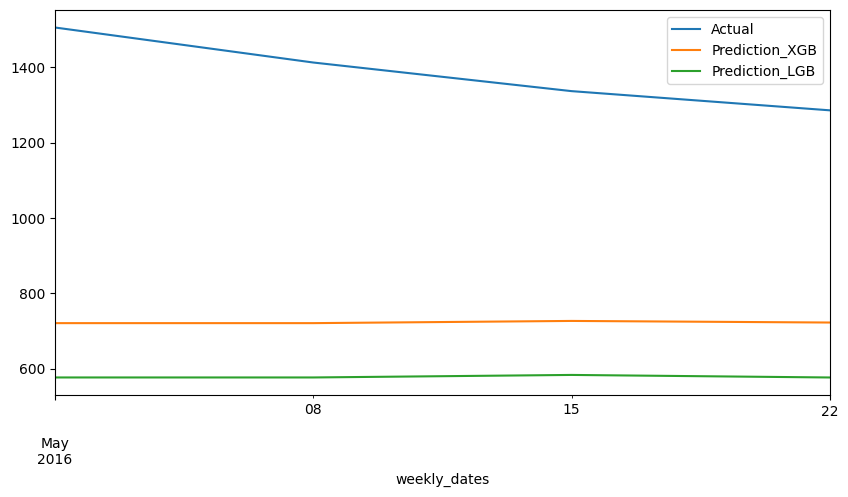

RMSSE XGB:
4.455391846374071
RMSSE LGB:
5.412244568191542


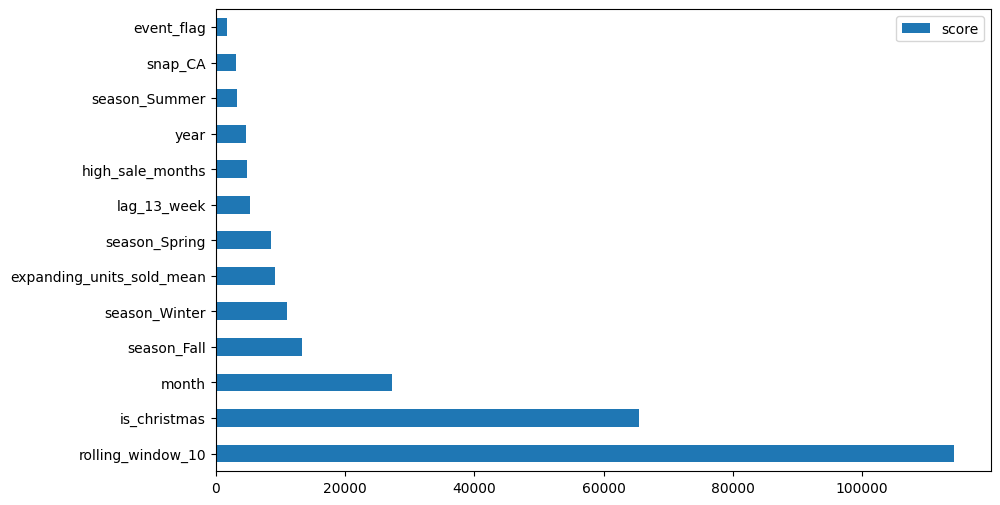

[0]	validation_0-rmse:6300.58291
[1]	validation_0-rmse:6595.64311
[2]	validation_0-rmse:6879.31123
[3]	validation_0-rmse:7166.39610
[4]	validation_0-rmse:7429.00579
[5]	validation_0-rmse:7695.10435
[6]	validation_0-rmse:7938.16263
[7]	validation_0-rmse:8184.80189
[8]	validation_0-rmse:8422.00962
[9]	validation_0-rmse:8638.61459
[10]	validation_0-rmse:8858.46251
[11]	validation_0-rmse:9069.89669
[12]	validation_0-rmse:9262.89825
[13]	validation_0-rmse:9318.11472
[14]	validation_0-rmse:9496.85895
[15]	validation_0-rmse:9547.32266
[16]	validation_0-rmse:9641.62341
[17]	validation_0-rmse:9810.18206
[18]	validation_0-rmse:9963.72701
[19]	validation_0-rmse:10062.94957
[20]	validation_0-rmse:10159.85935
[21]	validation_0-rmse:10297.13106
[22]	validation_0-rmse:10384.80698
[23]	validation_0-rmse:10496.35289
[24]	validation_0-rmse:10532.68674
[25]	validation_0-rmse:10657.89238
[26]	validation_0-rmse:10684.38038
[27]	validation_0-rmse:10710.33865
[28]	validation_0-rmse:10742.21039
[29]	validatio

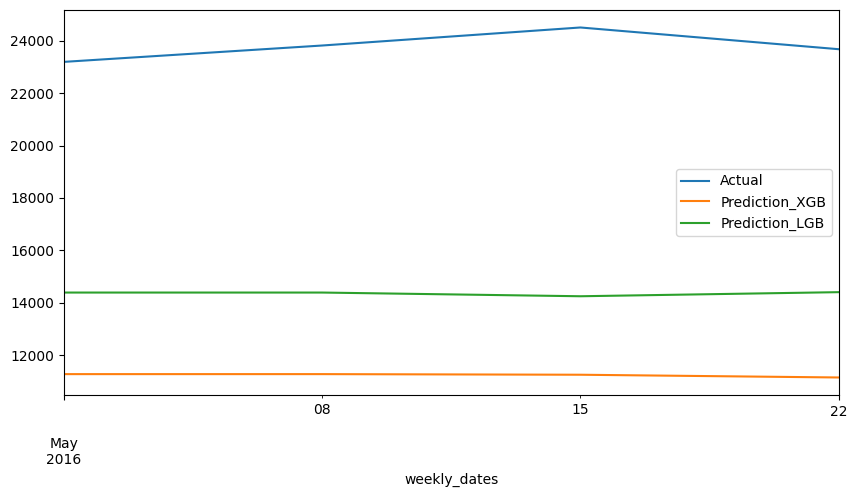

RMSSE XGB:
9.622316194104876
RMSSE LGB:
7.238467914395771


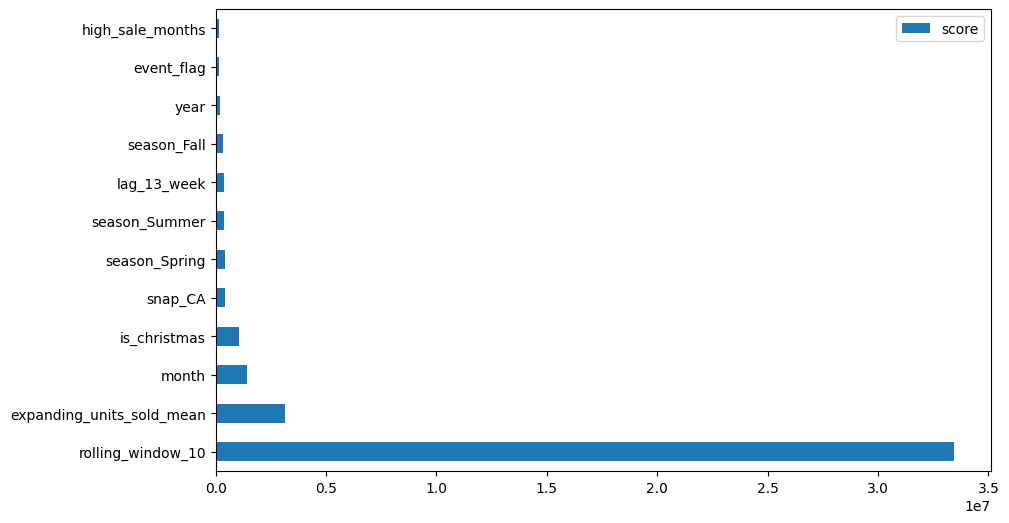

[0]	validation_0-rmse:2056.21758
[1]	validation_0-rmse:2084.91822
[2]	validation_0-rmse:2112.50976
[3]	validation_0-rmse:2139.93800
[4]	validation_0-rmse:2165.45265
[5]	validation_0-rmse:2190.83868
[6]	validation_0-rmse:2215.24439
[7]	validation_0-rmse:2237.93652
[8]	validation_0-rmse:2260.52263
[9]	validation_0-rmse:2272.76089
[10]	validation_0-rmse:2293.68027
[11]	validation_0-rmse:2304.81690
[12]	validation_0-rmse:2315.58346
[13]	validation_0-rmse:2334.25315
[14]	validation_0-rmse:2344.04096
[15]	validation_0-rmse:2361.33416
[16]	validation_0-rmse:2370.22135
[17]	validation_0-rmse:2386.24043
[18]	validation_0-rmse:2408.66042
[19]	validation_0-rmse:2430.26863
[20]	validation_0-rmse:2452.70199
[21]	validation_0-rmse:2472.81267
[22]	validation_0-rmse:2469.64021
[23]	validation_0-rmse:2466.55255
[24]	validation_0-rmse:2463.54726
[25]	validation_0-rmse:2470.63673
[26]	validation_0-rmse:2482.10337
[27]	validation_0-rmse:2478.68292
[28]	validation_0-rmse:2475.35402
[29]	validation_0-rmse:2

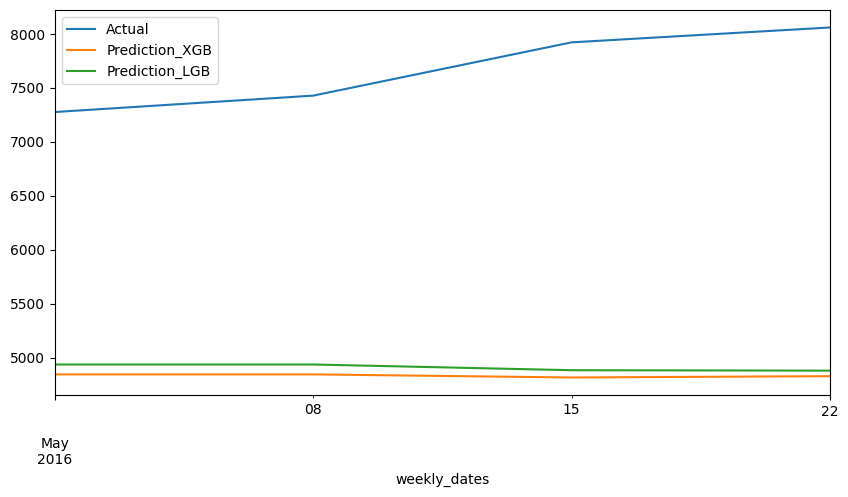

RMSSE XGB:
7.1236999644948815
RMSSE LGB:
6.941763199299919


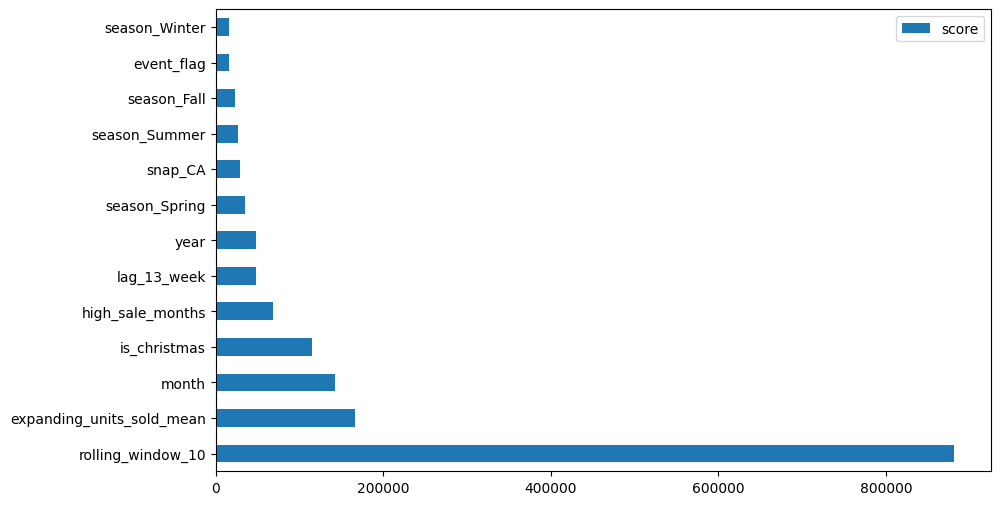

[0]	validation_0-rmse:1677.60764
[1]	validation_0-rmse:1757.77620
[2]	validation_0-rmse:1835.47729
[3]	validation_0-rmse:1909.92565
[4]	validation_0-rmse:1982.03136
[5]	validation_0-rmse:2051.45254
[6]	validation_0-rmse:2118.64767
[7]	validation_0-rmse:2182.63201
[8]	validation_0-rmse:2246.33314
[9]	validation_0-rmse:2307.62955
[10]	validation_0-rmse:2366.60478
[11]	validation_0-rmse:2423.34120
[12]	validation_0-rmse:2477.91897
[13]	validation_0-rmse:2530.41636
[14]	validation_0-rmse:2580.90923
[15]	validation_0-rmse:2629.47172
[16]	validation_0-rmse:2676.17514
[17]	validation_0-rmse:2711.57385
[18]	validation_0-rmse:2745.63834
[19]	validation_0-rmse:2778.41819
[20]	validation_0-rmse:2817.33864
[21]	validation_0-rmse:2847.67607
[22]	validation_0-rmse:2876.86765
[23]	validation_0-rmse:2911.62120
[24]	validation_0-rmse:2938.63457
[25]	validation_0-rmse:2964.62660
[26]	validation_0-rmse:2996.64327
[27]	validation_0-rmse:3026.53071
[28]	validation_0-rmse:3049.86143
[29]	validation_0-rmse:3

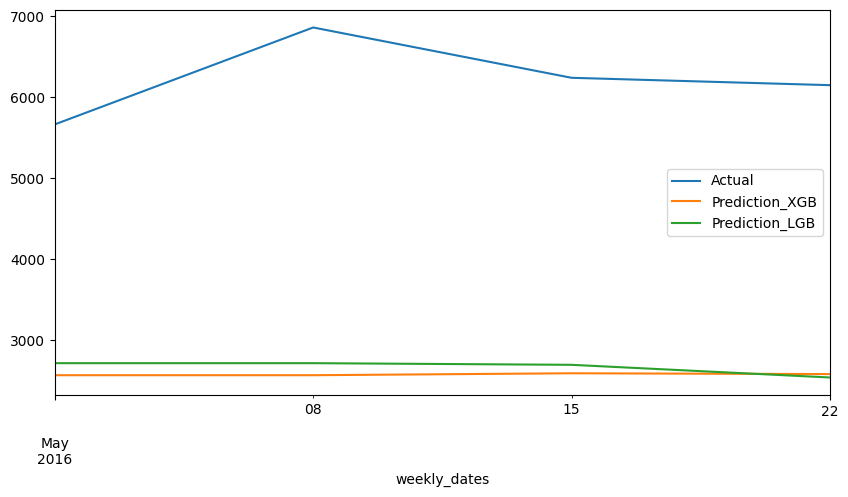

RMSSE XGB:
5.4186838677338125
RMSSE LGB:
5.286561746869617


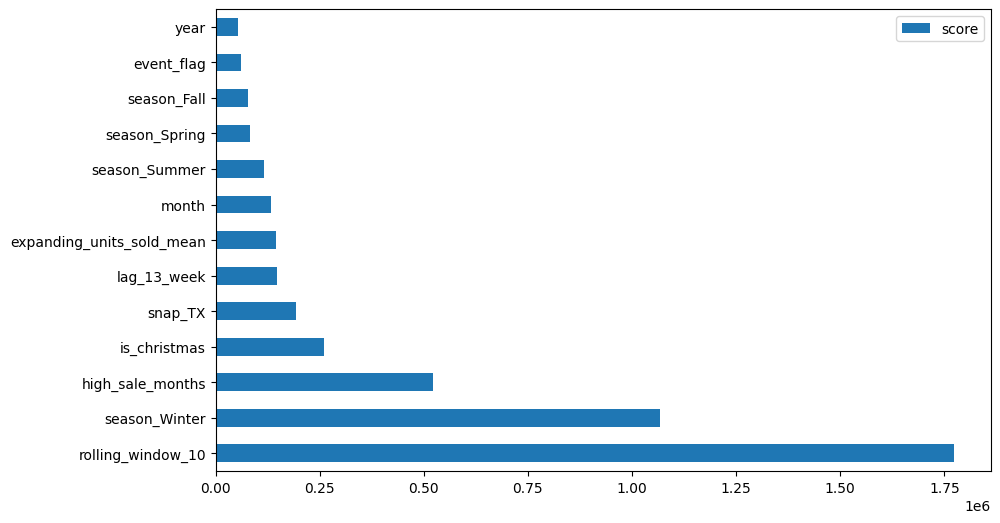

[0]	validation_0-rmse:1319.54086
[1]	validation_0-rmse:1311.27318
[2]	validation_0-rmse:1320.70606
[3]	validation_0-rmse:1313.96606
[4]	validation_0-rmse:1317.14174
[5]	validation_0-rmse:1320.40593
[6]	validation_0-rmse:1315.38608
[7]	validation_0-rmse:1321.22011
[8]	validation_0-rmse:1322.34971
[9]	validation_0-rmse:1328.04344
[10]	validation_0-rmse:1337.47737
[11]	validation_0-rmse:1343.14949
[12]	validation_0-rmse:1351.07012
[13]	validation_0-rmse:1360.14931
[14]	validation_0-rmse:1370.65865
[15]	validation_0-rmse:1376.02399
[16]	validation_0-rmse:1381.36530
[17]	validation_0-rmse:1391.46788
[18]	validation_0-rmse:1394.27568
[19]	validation_0-rmse:1399.53348
[20]	validation_0-rmse:1402.55661
[21]	validation_0-rmse:1413.07024
[22]	validation_0-rmse:1421.77930
[23]	validation_0-rmse:1427.30440
[24]	validation_0-rmse:1420.62714
[25]	validation_0-rmse:1429.86102
[26]	validation_0-rmse:1447.66563
[27]	validation_0-rmse:1455.48692
[28]	validation_0-rmse:1479.49751
[29]	validation_0-rmse:1

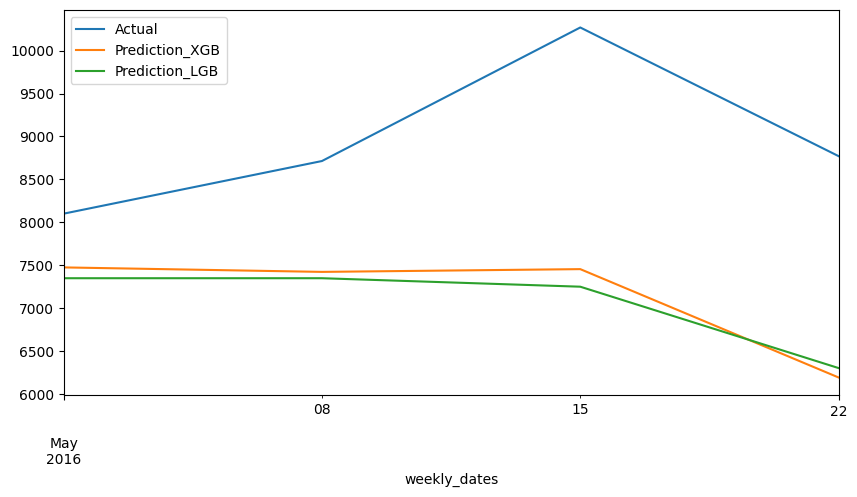

RMSSE XGB:
1.5523220181769808
RMSSE LGB:
1.5987716245414716


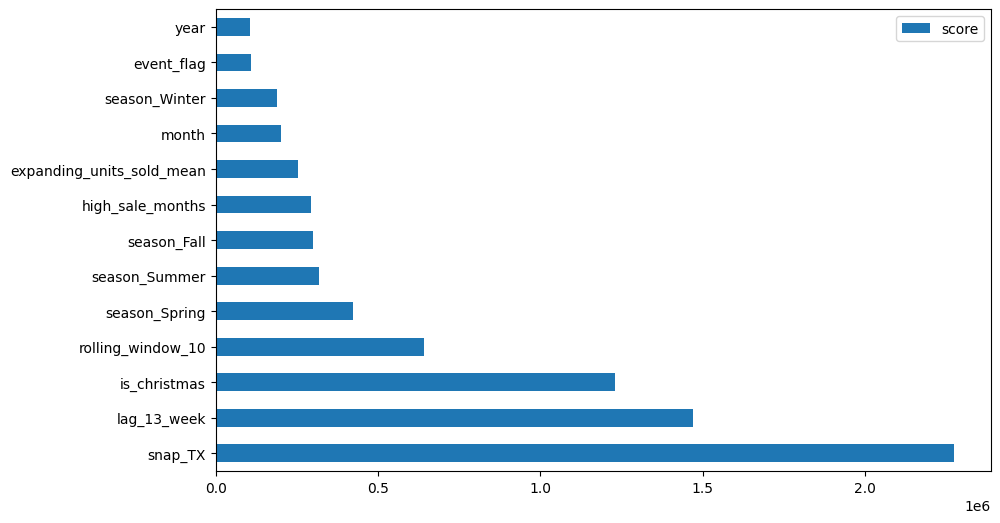

[0]	validation_0-rmse:4461.17157
[1]	validation_0-rmse:4503.76590
[2]	validation_0-rmse:4577.03687
[3]	validation_0-rmse:4620.77596
[4]	validation_0-rmse:4688.64390
[5]	validation_0-rmse:4731.91741
[6]	validation_0-rmse:4800.38577
[7]	validation_0-rmse:4913.45062
[8]	validation_0-rmse:4974.14567
[9]	validation_0-rmse:5014.16381
[10]	validation_0-rmse:5047.85111
[11]	validation_0-rmse:5059.84290
[12]	validation_0-rmse:5113.95757
[13]	validation_0-rmse:5287.20597
[14]	validation_0-rmse:5275.35103
[15]	validation_0-rmse:5436.75321
[16]	validation_0-rmse:5592.84576
[17]	validation_0-rmse:5743.72233
[18]	validation_0-rmse:5730.91648
[19]	validation_0-rmse:5871.50415
[20]	validation_0-rmse:5958.85289
[21]	validation_0-rmse:6087.25515
[22]	validation_0-rmse:6165.40613
[23]	validation_0-rmse:6244.19004
[24]	validation_0-rmse:6281.69370
[25]	validation_0-rmse:6340.63118
[26]	validation_0-rmse:6397.63716
[27]	validation_0-rmse:6431.51440
[28]	validation_0-rmse:6496.65087
[29]	validation_0-rmse:6

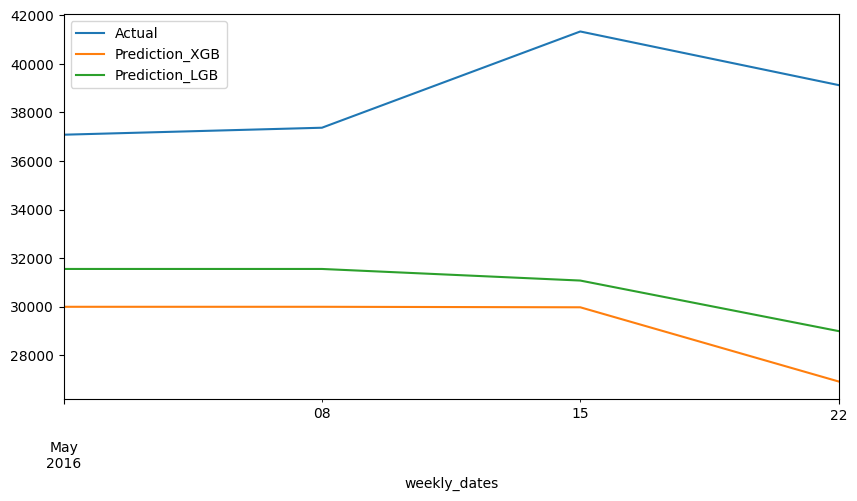

RMSSE XGB:
2.903286322327367
RMSSE LGB:
2.4490163666862483


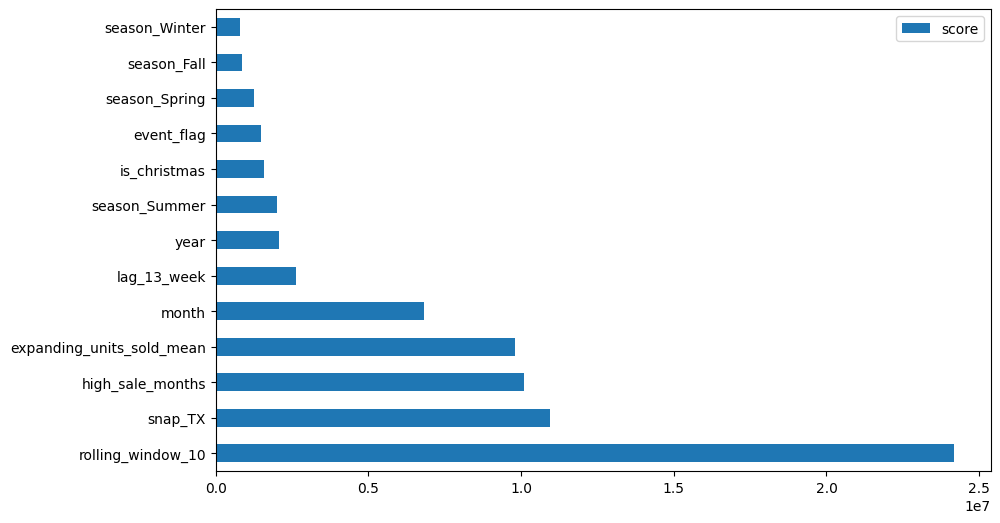

[0]	validation_0-rmse:1729.13415
[1]	validation_0-rmse:1778.01388
[2]	validation_0-rmse:1825.06574
[3]	validation_0-rmse:1870.35381
[4]	validation_0-rmse:1910.75420
[5]	validation_0-rmse:1952.82320
[6]	validation_0-rmse:1988.35857
[7]	validation_0-rmse:2027.55928
[8]	validation_0-rmse:2060.95013
[9]	validation_0-rmse:2093.08201
[10]	validation_0-rmse:2124.00166
[11]	validation_0-rmse:2152.66492
[12]	validation_0-rmse:2181.11525
[13]	validation_0-rmse:2205.55177
[14]	validation_0-rmse:2233.49590
[15]	validation_0-rmse:2260.39005
[16]	validation_0-rmse:2284.88810
[17]	validation_0-rmse:2308.44119
[18]	validation_0-rmse:2331.08514
[19]	validation_0-rmse:2352.85480
[20]	validation_0-rmse:2373.78354
[21]	validation_0-rmse:2392.60247
[22]	validation_0-rmse:2412.19632
[23]	validation_0-rmse:2430.87749
[24]	validation_0-rmse:2436.70582
[25]	validation_0-rmse:2452.37153
[26]	validation_0-rmse:2470.28698
[27]	validation_0-rmse:2489.12957
[28]	validation_0-rmse:2505.78758
[29]	validation_0-rmse:2

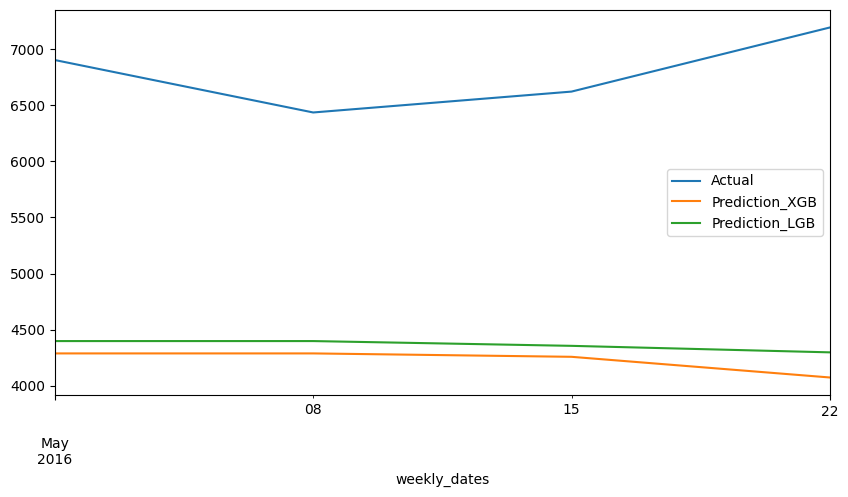

RMSSE XGB:
6.032396901573382
RMSSE LGB:
5.705446548519475


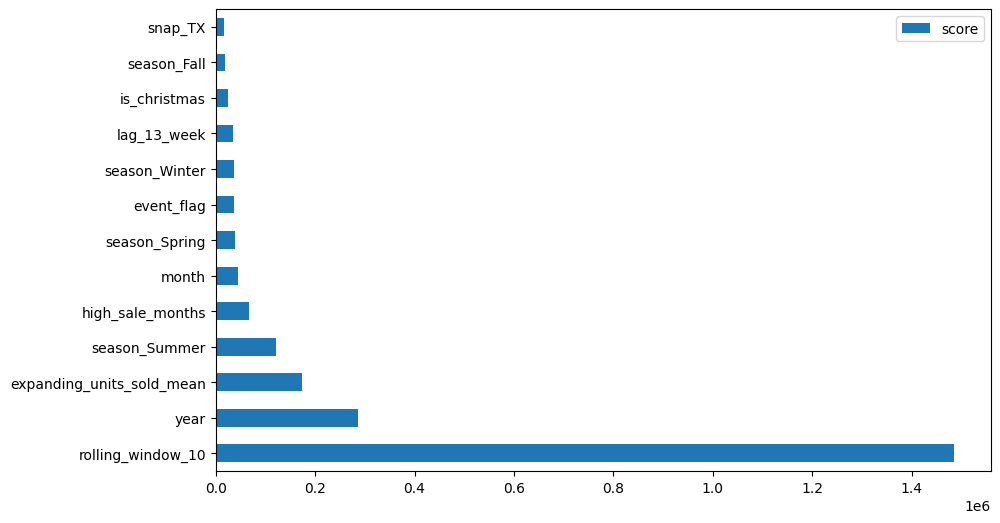

[0]	validation_0-rmse:478.14416
[1]	validation_0-rmse:469.41205
[2]	validation_0-rmse:461.01497
[3]	validation_0-rmse:452.94010
[4]	validation_0-rmse:446.03766
[5]	validation_0-rmse:438.54890
[6]	validation_0-rmse:434.16446
[7]	validation_0-rmse:428.03096
[8]	validation_0-rmse:422.13083
[9]	validation_0-rmse:418.30824
[10]	validation_0-rmse:412.85634
[11]	validation_0-rmse:409.35248
[12]	validation_0-rmse:404.31557
[13]	validation_0-rmse:398.77464
[14]	validation_0-rmse:394.11847
[15]	validation_0-rmse:391.22020
[16]	validation_0-rmse:386.91957
[17]	validation_0-rmse:384.26867
[18]	validation_0-rmse:380.29697
[19]	validation_0-rmse:376.30079
[20]	validation_0-rmse:371.70880
[21]	validation_0-rmse:368.18111
[22]	validation_0-rmse:364.59570
[23]	validation_0-rmse:360.47098
[24]	validation_0-rmse:358.57404
[25]	validation_0-rmse:354.73607
[26]	validation_0-rmse:351.84768
[27]	validation_0-rmse:352.43712
[28]	validation_0-rmse:353.00517
[29]	validation_0-rmse:353.65765
[30]	validation_0-rm

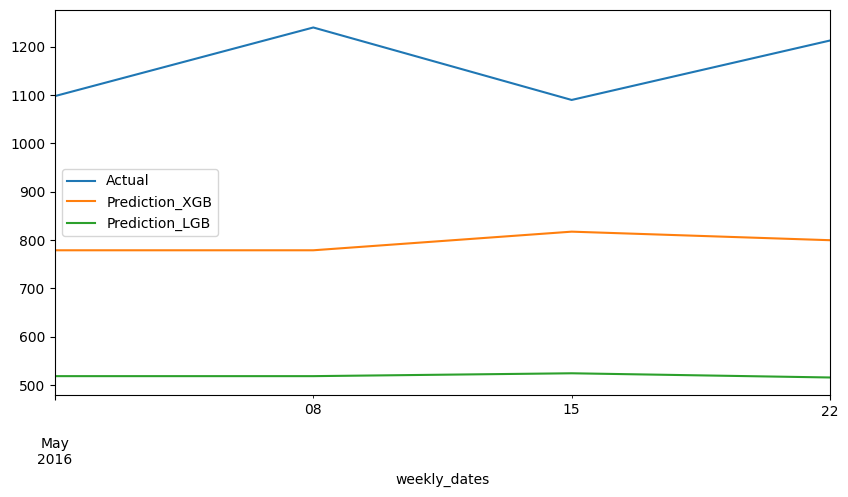

RMSSE XGB:
2.6928709826191337
RMSSE LGB:
4.6422938690365285


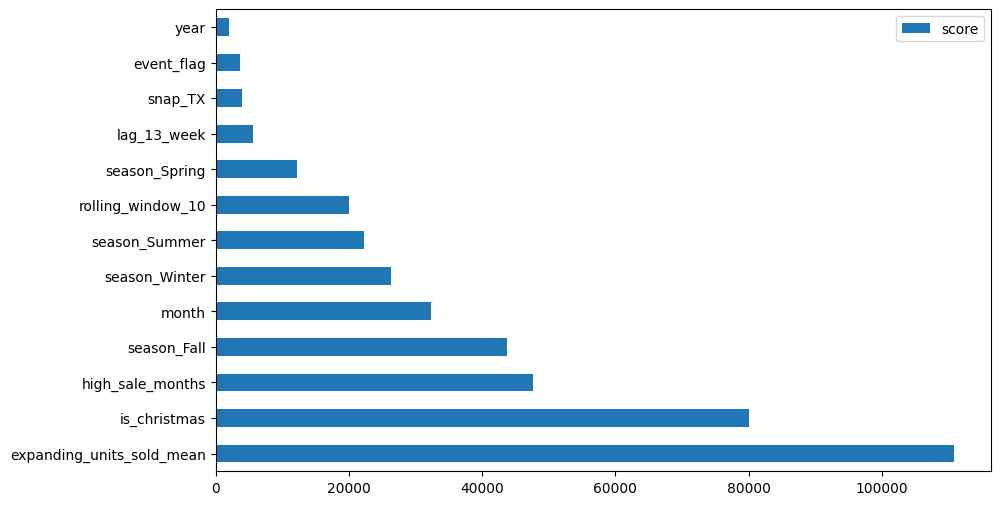

[0]	validation_0-rmse:3487.77058
[1]	validation_0-rmse:3604.93641
[2]	validation_0-rmse:3717.77847
[3]	validation_0-rmse:3826.44443
[4]	validation_0-rmse:3932.87668
[5]	validation_0-rmse:4033.55361
[6]	validation_0-rmse:4137.57060
[7]	validation_0-rmse:4237.66085
[8]	validation_0-rmse:4326.97036
[9]	validation_0-rmse:4412.93941
[10]	validation_0-rmse:4501.96074
[11]	validation_0-rmse:4578.43920
[12]	validation_0-rmse:4660.86210
[13]	validation_0-rmse:4731.54864
[14]	validation_0-rmse:4860.08822
[15]	validation_0-rmse:4927.70895
[16]	validation_0-rmse:4997.87420
[17]	validation_0-rmse:5060.41070
[18]	validation_0-rmse:5118.35149
[19]	validation_0-rmse:5224.38441
[20]	validation_0-rmse:5284.20732
[21]	validation_0-rmse:5337.44241
[22]	validation_0-rmse:5432.00230
[23]	validation_0-rmse:5484.89275
[24]	validation_0-rmse:5564.87003
[25]	validation_0-rmse:5642.24698
[26]	validation_0-rmse:5672.15933
[27]	validation_0-rmse:5741.89472
[28]	validation_0-rmse:5813.69968
[29]	validation_0-rmse:5

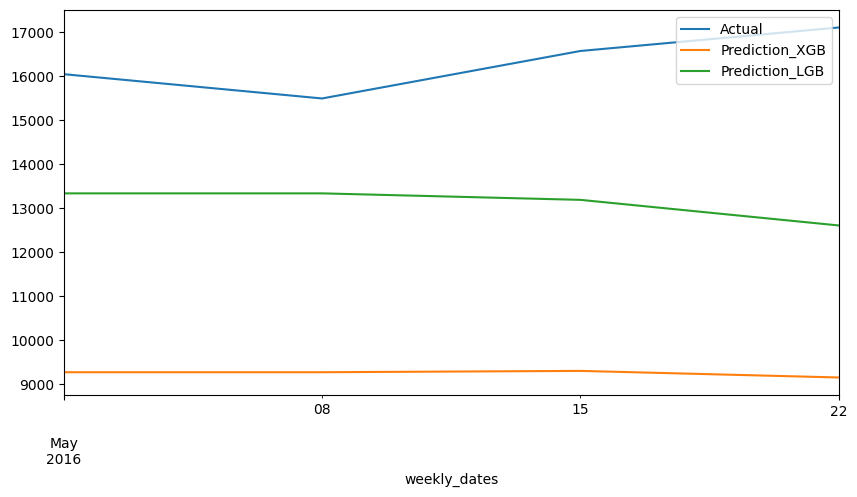

RMSSE XGB:
6.8396800175605685
RMSSE LGB:
3.190670899578689


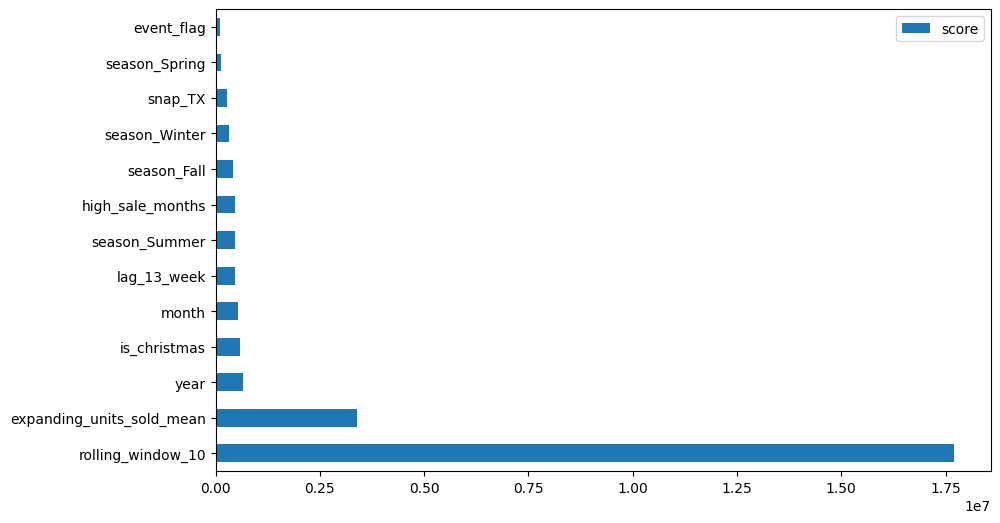

[0]	validation_0-rmse:1321.90166
[1]	validation_0-rmse:1344.41657
[2]	validation_0-rmse:1366.05313
[3]	validation_0-rmse:1387.07808
[4]	validation_0-rmse:1405.69860
[5]	validation_0-rmse:1425.11186
[6]	validation_0-rmse:1442.93533
[7]	validation_0-rmse:1460.89638
[8]	validation_0-rmse:1478.98372
[9]	validation_0-rmse:1495.62247
[10]	validation_0-rmse:1511.61190
[11]	validation_0-rmse:1527.00210
[12]	validation_0-rmse:1541.98974
[13]	validation_0-rmse:1556.39133
[14]	validation_0-rmse:1570.22960
[15]	validation_0-rmse:1584.42170
[16]	validation_0-rmse:1598.06389
[17]	validation_0-rmse:1611.17719
[18]	validation_0-rmse:1623.78215
[19]	validation_0-rmse:1635.89862
[20]	validation_0-rmse:1647.54516
[21]	validation_0-rmse:1658.74024
[22]	validation_0-rmse:1669.50125
[23]	validation_0-rmse:1679.84488
[24]	validation_0-rmse:1689.28729
[25]	validation_0-rmse:1698.36007
[26]	validation_0-rmse:1707.63539
[27]	validation_0-rmse:1716.03232
[28]	validation_0-rmse:1724.64661
[29]	validation_0-rmse:1

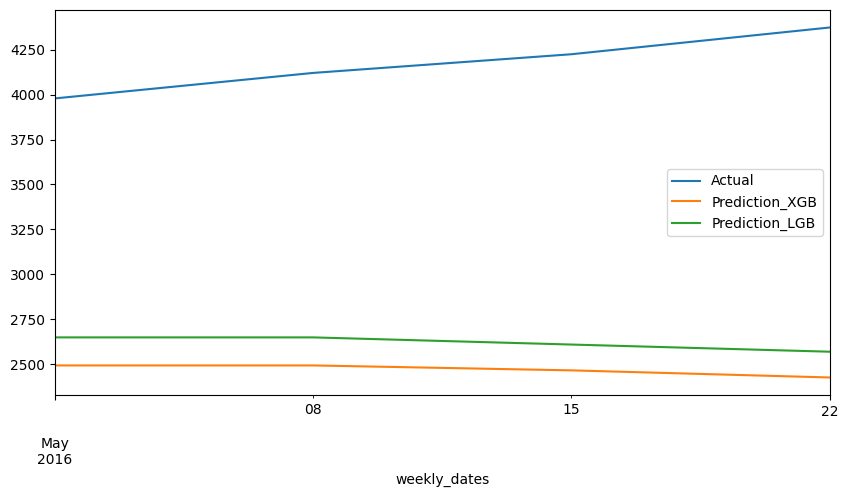

RMSSE XGB:
7.594806611488535
RMSSE LGB:
6.937125877400759


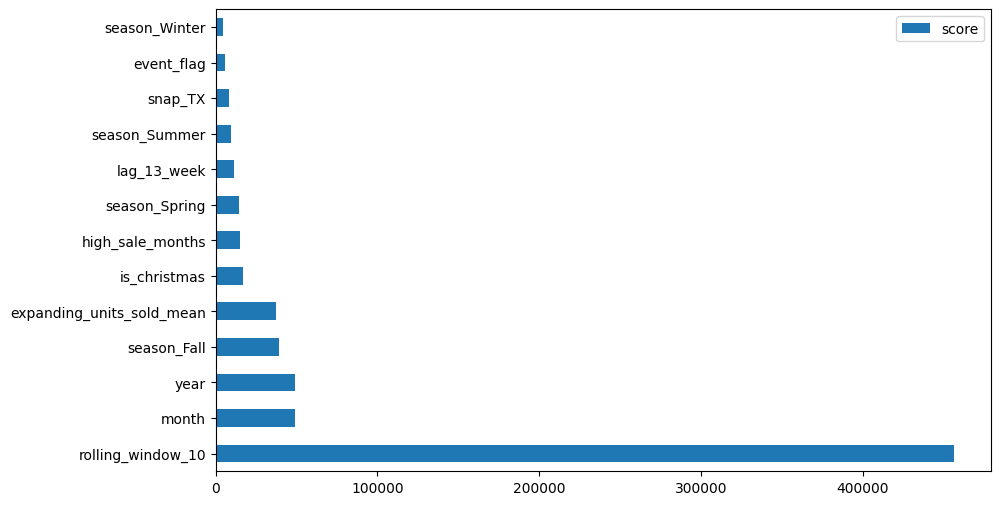

[0]	validation_0-rmse:3059.69269
[1]	validation_0-rmse:3127.44444
[2]	validation_0-rmse:3193.22331
[3]	validation_0-rmse:3256.49213
[4]	validation_0-rmse:3316.80937
[5]	validation_0-rmse:3375.54638
[6]	validation_0-rmse:3431.85771
[7]	validation_0-rmse:3486.17611
[8]	validation_0-rmse:3542.38625
[9]	validation_0-rmse:3596.45197
[10]	validation_0-rmse:3644.30215
[11]	validation_0-rmse:3694.47305
[12]	validation_0-rmse:3742.72377
[13]	validation_0-rmse:3789.12561
[14]	validation_0-rmse:3830.14977
[15]	validation_0-rmse:3873.19865
[16]	validation_0-rmse:3908.93259
[17]	validation_0-rmse:3943.33698
[18]	validation_0-rmse:3976.46033
[19]	validation_0-rmse:4008.34997
[20]	validation_0-rmse:4039.05091
[21]	validation_0-rmse:4068.60741
[22]	validation_0-rmse:4098.16560
[23]	validation_0-rmse:4133.24924
[24]	validation_0-rmse:4160.61946
[25]	validation_0-rmse:4193.35057
[26]	validation_0-rmse:4224.84804
[27]	validation_0-rmse:4255.15834
[28]	validation_0-rmse:4284.32533
[29]	validation_0-rmse:4

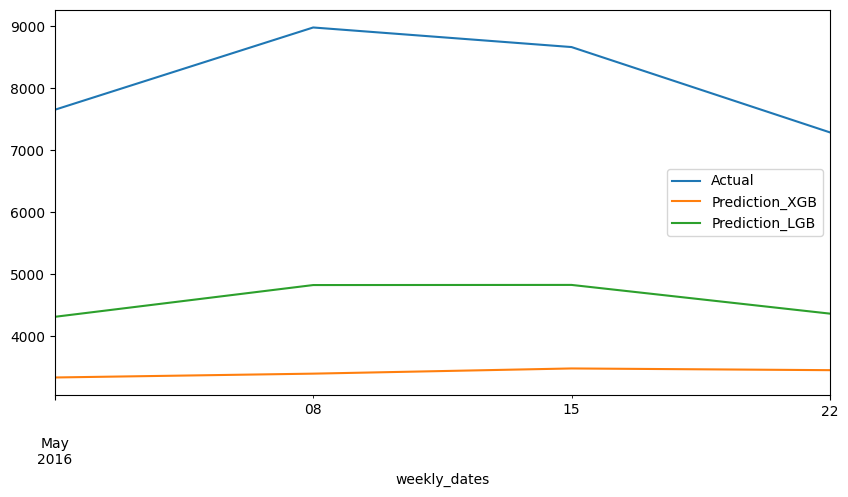

RMSSE XGB:
6.195354081538994
RMSSE LGB:
4.658370711467303


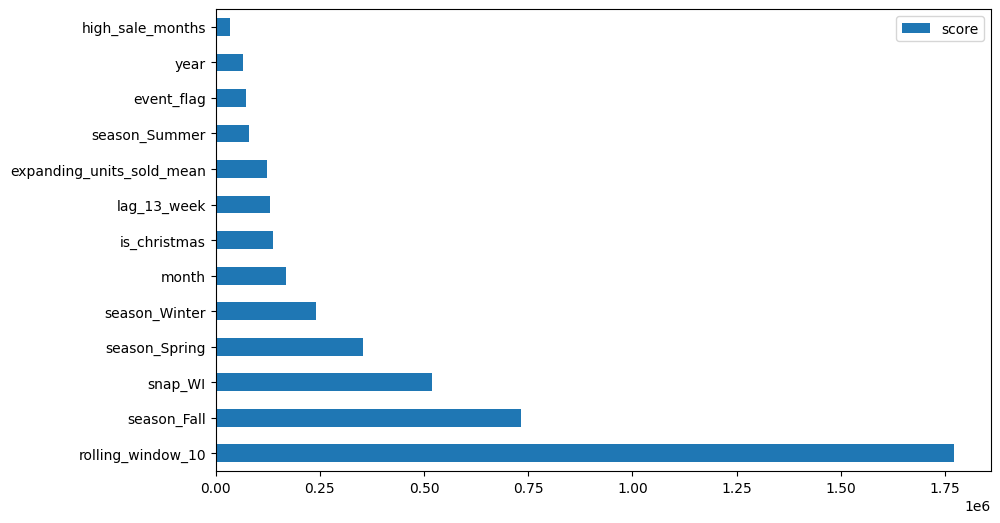

[0]	validation_0-rmse:8812.98343
[1]	validation_0-rmse:8949.14809
[2]	validation_0-rmse:9082.15236
[3]	validation_0-rmse:9209.49260
[4]	validation_0-rmse:9335.55981
[5]	validation_0-rmse:9454.46421
[6]	validation_0-rmse:9569.24469
[7]	validation_0-rmse:9682.82043
[8]	validation_0-rmse:9792.37040
[9]	validation_0-rmse:9895.60402
[10]	validation_0-rmse:9995.14162
[11]	validation_0-rmse:10093.50638
[12]	validation_0-rmse:10186.06406
[13]	validation_0-rmse:10275.25299
[14]	validation_0-rmse:10363.42381
[15]	validation_0-rmse:10446.26708
[16]	validation_0-rmse:10528.14471
[17]	validation_0-rmse:10612.10874
[18]	validation_0-rmse:10692.98027
[19]	validation_0-rmse:10764.51769
[20]	validation_0-rmse:10840.63757
[21]	validation_0-rmse:10912.76729
[22]	validation_0-rmse:10978.93437
[23]	validation_0-rmse:11032.71789
[24]	validation_0-rmse:11094.32504
[25]	validation_0-rmse:11159.01201
[26]	validation_0-rmse:11219.00896
[27]	validation_0-rmse:11274.21944
[28]	validation_0-rmse:11327.35631
[29]	v

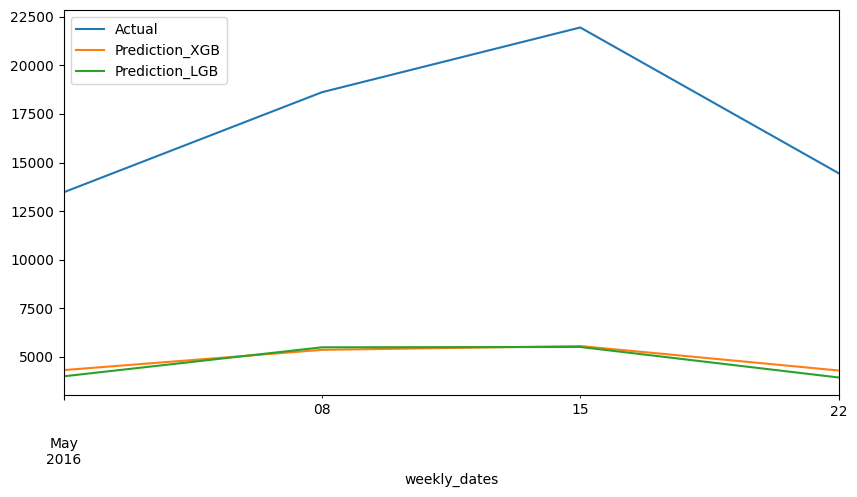

RMSSE XGB:
5.173984139253245
RMSSE LGB:
5.220930835597566


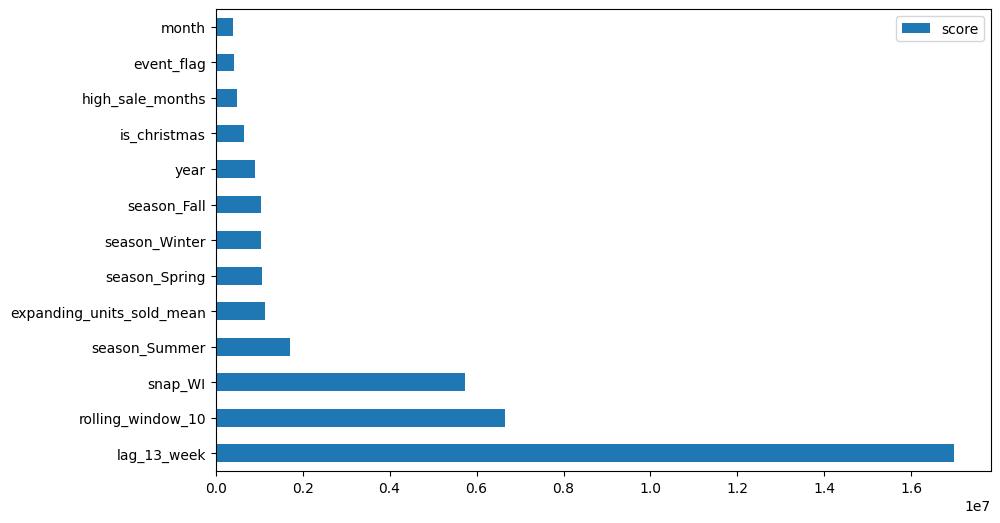

[0]	validation_0-rmse:12537.47441
[1]	validation_0-rmse:12903.68901
[2]	validation_0-rmse:13201.74428
[3]	validation_0-rmse:13547.71209
[4]	validation_0-rmse:13885.41721
[5]	validation_0-rmse:14211.92454
[6]	validation_0-rmse:14529.52759
[7]	validation_0-rmse:14827.10896
[8]	validation_0-rmse:15124.94813
[9]	validation_0-rmse:15413.05278
[10]	validation_0-rmse:15684.67781
[11]	validation_0-rmse:15954.32575
[12]	validation_0-rmse:16217.64693
[13]	validation_0-rmse:16415.28422
[14]	validation_0-rmse:16660.79668
[15]	validation_0-rmse:16889.20987
[16]	validation_0-rmse:17118.53586
[17]	validation_0-rmse:17339.86701
[18]	validation_0-rmse:17521.24801
[19]	validation_0-rmse:17740.86345
[20]	validation_0-rmse:17911.59390
[21]	validation_0-rmse:18117.06621
[22]	validation_0-rmse:18280.13381
[23]	validation_0-rmse:18431.23610
[24]	validation_0-rmse:18584.46480
[25]	validation_0-rmse:18678.19670
[26]	validation_0-rmse:18769.46456
[27]	validation_0-rmse:18909.49106
[28]	validation_0-rmse:19037.4

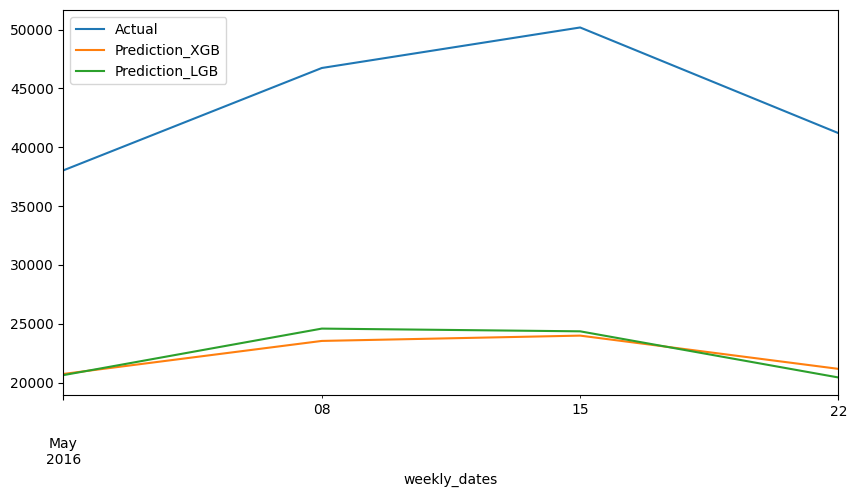

RMSSE XGB:
4.42194855215632
RMSSE LGB:
4.383650728583944


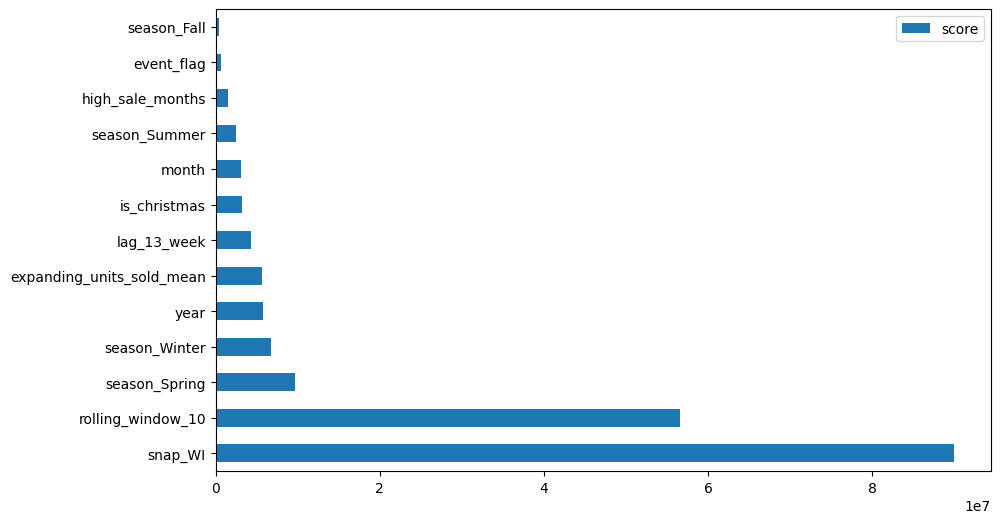

[0]	validation_0-rmse:1359.31880
[1]	validation_0-rmse:1373.08712
[2]	validation_0-rmse:1386.63852
[3]	validation_0-rmse:1399.96913
[4]	validation_0-rmse:1413.07540
[5]	validation_0-rmse:1425.95506
[6]	validation_0-rmse:1438.60663
[7]	validation_0-rmse:1451.02915
[8]	validation_0-rmse:1463.22210
[9]	validation_0-rmse:1475.18556
[10]	validation_0-rmse:1486.92034
[11]	validation_0-rmse:1498.42721
[12]	validation_0-rmse:1509.70768
[13]	validation_0-rmse:1520.76318
[14]	validation_0-rmse:1531.59597
[15]	validation_0-rmse:1542.20786
[16]	validation_0-rmse:1563.62468
[17]	validation_0-rmse:1584.23421
[18]	validation_0-rmse:1604.06642
[19]	validation_0-rmse:1602.51814
[20]	validation_0-rmse:1601.01110
[21]	validation_0-rmse:1599.54431
[22]	validation_0-rmse:1605.25201
[23]	validation_0-rmse:1603.52042
[24]	validation_0-rmse:1608.83068
[25]	validation_0-rmse:1606.86435
[26]	validation_0-rmse:1611.80428
[27]	validation_0-rmse:1611.28231
[28]	validation_0-rmse:1610.79734
[29]	validation_0-rmse:1

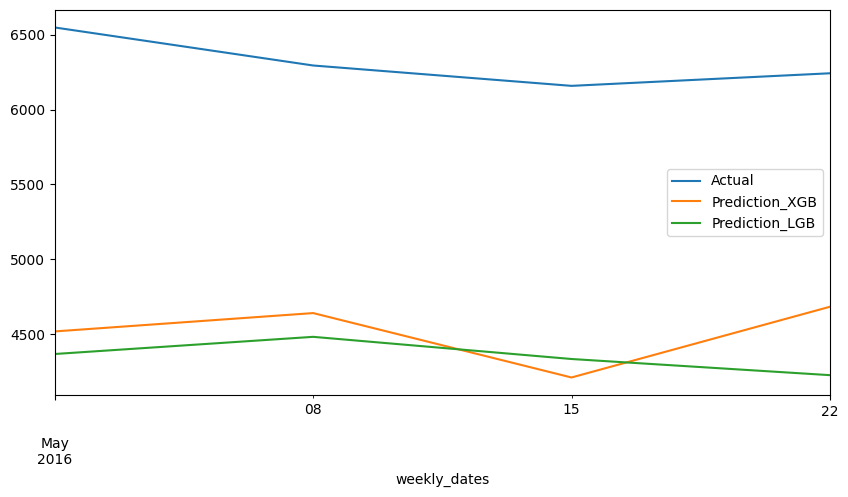

RMSSE XGB:
3.1811256254091926
RMSSE LGB:
3.4553377834287824


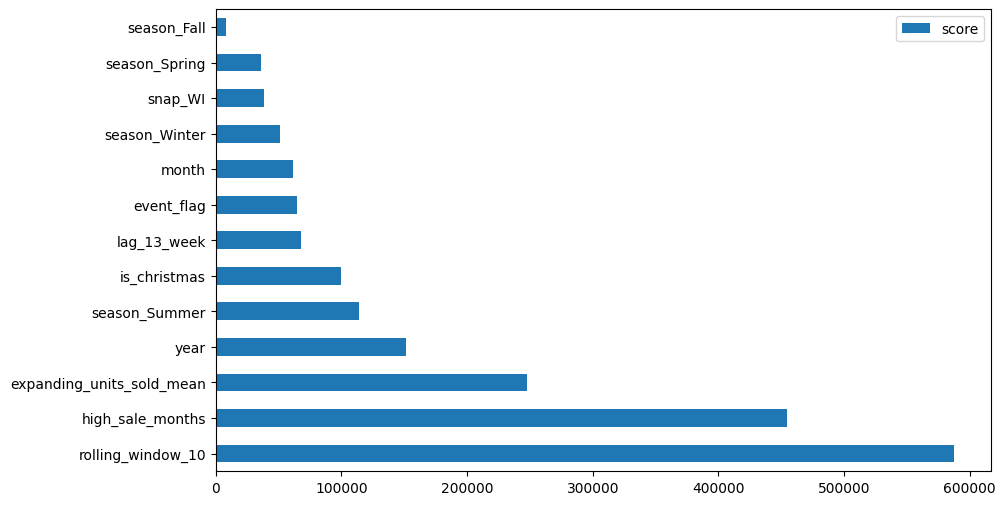

[0]	validation_0-rmse:310.10040
[1]	validation_0-rmse:309.22369
[2]	validation_0-rmse:308.37334
[3]	validation_0-rmse:307.54861
[4]	validation_0-rmse:306.74870
[5]	validation_0-rmse:303.24848
[6]	validation_0-rmse:299.87419
[7]	validation_0-rmse:296.62131
[8]	validation_0-rmse:293.03530
[9]	validation_0-rmse:289.99177
[10]	validation_0-rmse:286.61028
[11]	validation_0-rmse:283.33865
[12]	validation_0-rmse:280.57382
[13]	validation_0-rmse:280.29974
[14]	validation_0-rmse:277.29606
[15]	validation_0-rmse:277.07498
[16]	validation_0-rmse:276.86052
[17]	validation_0-rmse:276.49314
[18]	validation_0-rmse:273.79483
[19]	validation_0-rmse:273.67982
[20]	validation_0-rmse:273.45768
[21]	validation_0-rmse:273.39712
[22]	validation_0-rmse:270.97048
[23]	validation_0-rmse:270.94093
[24]	validation_0-rmse:270.92757
[25]	validation_0-rmse:268.68524
[26]	validation_0-rmse:268.74904
[27]	validation_0-rmse:266.62277
[28]	validation_0-rmse:266.75591
[29]	validation_0-rmse:264.73853
[30]	validation_0-rm

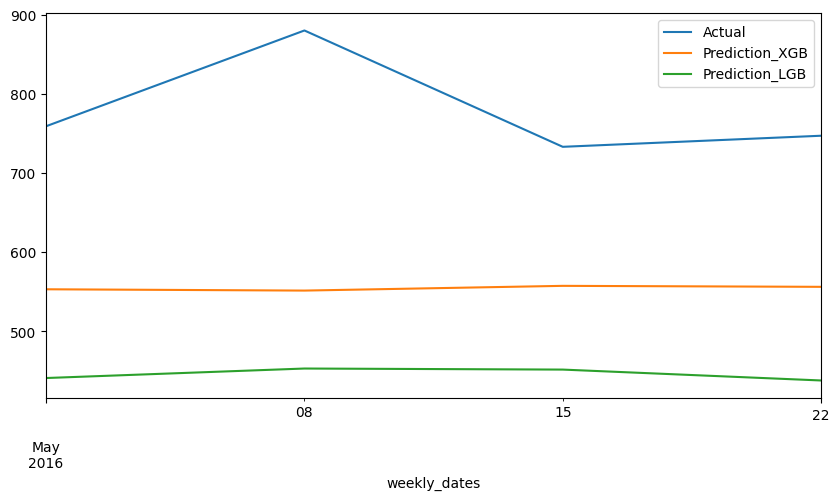

RMSSE XGB:
2.119158914167855
RMSSE LGB:
3.0750750253193244


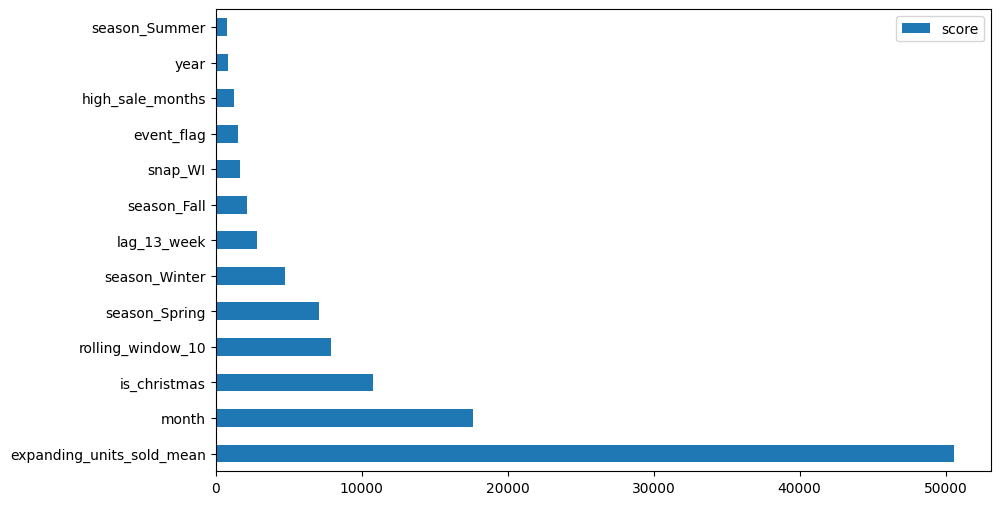

[0]	validation_0-rmse:4311.29235
[1]	validation_0-rmse:4285.62300
[2]	validation_0-rmse:4260.46852
[3]	validation_0-rmse:4235.81810
[4]	validation_0-rmse:4211.66202
[5]	validation_0-rmse:4187.98946
[6]	validation_0-rmse:4164.79162
[7]	validation_0-rmse:4142.05876
[8]	validation_0-rmse:4119.78115
[9]	validation_0-rmse:4097.95095
[10]	validation_0-rmse:4061.70066
[11]	validation_0-rmse:4026.17750
[12]	validation_0-rmse:3991.36778
[13]	validation_0-rmse:3953.51666
[14]	validation_0-rmse:3921.31021
[15]	validation_0-rmse:3889.75070
[16]	validation_0-rmse:3857.17776
[17]	validation_0-rmse:3827.95379
[18]	validation_0-rmse:3799.31606
[19]	validation_0-rmse:3771.25384
[20]	validation_0-rmse:3745.01956
[21]	validation_0-rmse:3718.98138
[22]	validation_0-rmse:3612.68425
[23]	validation_0-rmse:3590.27311
[24]	validation_0-rmse:3490.44009
[25]	validation_0-rmse:3394.06051
[26]	validation_0-rmse:3352.97182
[27]	validation_0-rmse:3262.47328
[28]	validation_0-rmse:3245.70464
[29]	validation_0-rmse:3

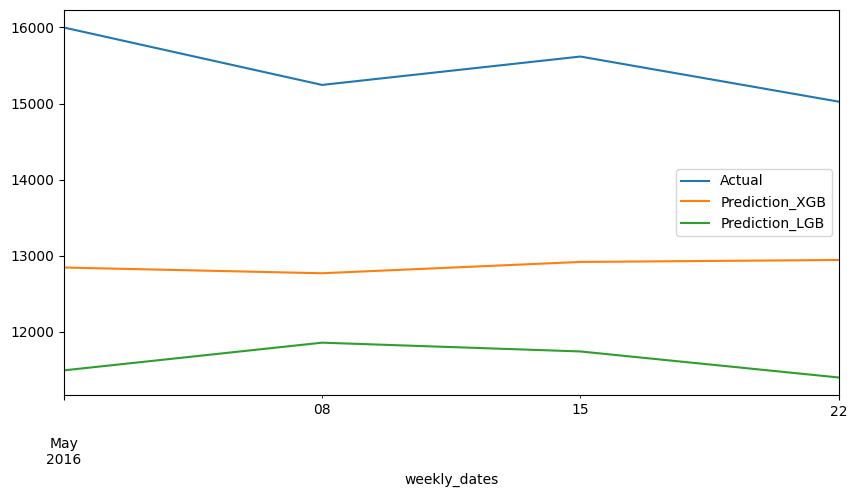

RMSSE XGB:
1.7810950966135937
RMSSE LGB:
2.6203944848769902


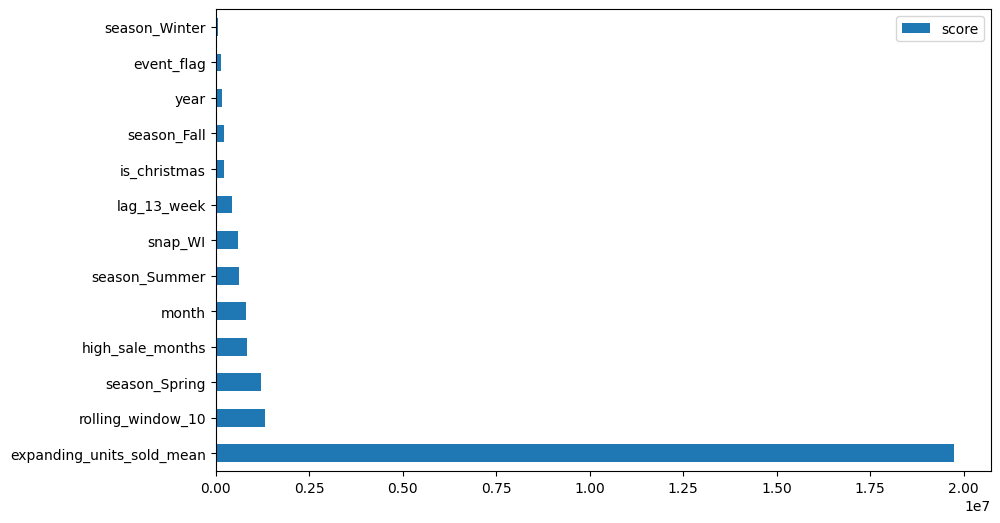

[0]	validation_0-rmse:1081.60033
[1]	validation_0-rmse:1046.81135
[2]	validation_0-rmse:1013.33484
[3]	validation_0-rmse:981.12316
[4]	validation_0-rmse:950.78927
[5]	validation_0-rmse:920.94557
[6]	validation_0-rmse:893.39618
[7]	validation_0-rmse:865.73184
[8]	validation_0-rmse:839.12088
[9]	validation_0-rmse:814.54262
[10]	validation_0-rmse:789.88534
[11]	validation_0-rmse:766.17211
[12]	validation_0-rmse:744.28985
[13]	validation_0-rmse:722.32706
[14]	validation_0-rmse:700.67979
[15]	validation_0-rmse:679.86363
[16]	validation_0-rmse:661.10897
[17]	validation_0-rmse:641.81792
[18]	validation_0-rmse:623.27309
[19]	validation_0-rmse:605.44782
[20]	validation_0-rmse:589.39993
[21]	validation_0-rmse:572.89472
[22]	validation_0-rmse:557.03556
[23]	validation_0-rmse:541.79936
[24]	validation_0-rmse:528.07791
[25]	validation_0-rmse:513.98437
[26]	validation_0-rmse:501.30631
[27]	validation_0-rmse:488.27633
[28]	validation_0-rmse:475.76680
[29]	validation_0-rmse:464.51000
[30]	validation_0

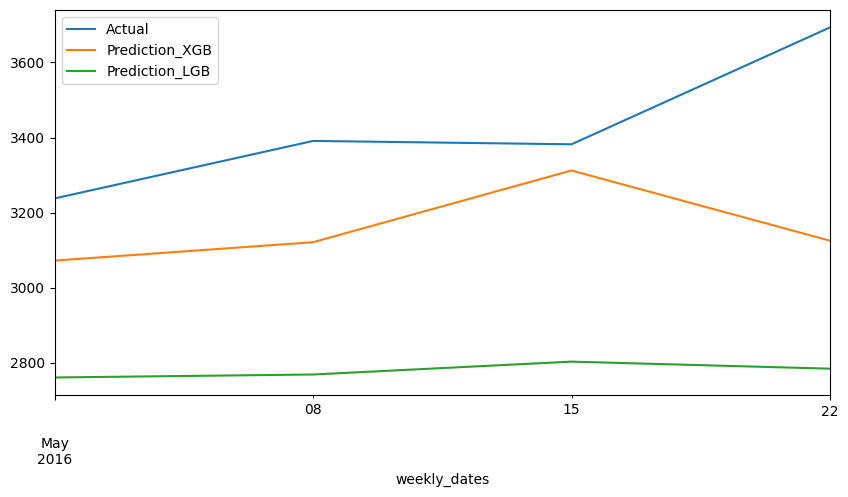

RMSSE XGB:
1.484534165617933
RMSSE LGB:
3.0255867840933792


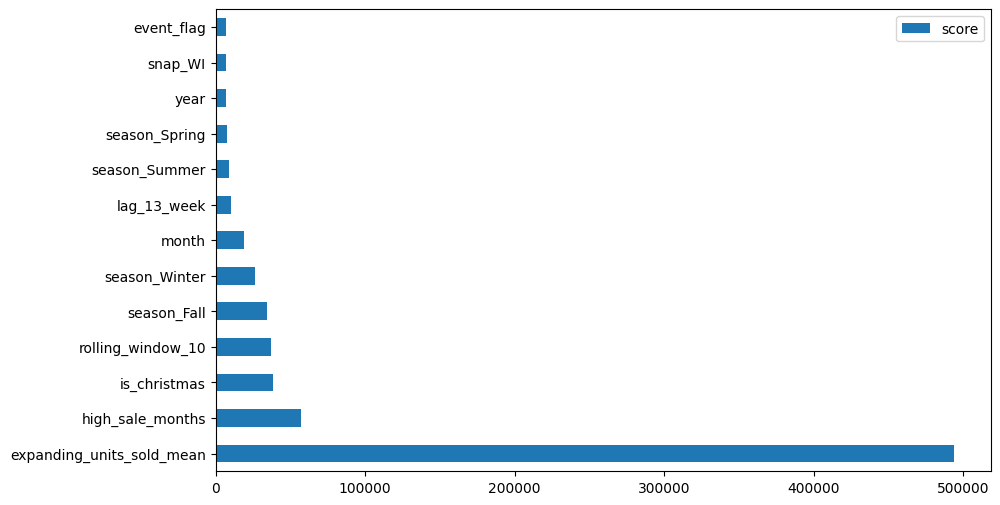

In [ ]:
# ML Models at State and Department level with rmsse values
rmsse_xgb_values = []
rmsse_lgb_values = []
rmsse_xgb_statedept,rmsse_lgb_statedept = train_and_validate_models(train_state_dept,val_state_dept,'state_id','dept_id',rmsse_xgb_values,rmsse_lgb_values)

rmsse_lgb['State and deparment'] = round(np.mean(rmsse_lgb_statedept),3)
rmsse_xgb['State and deparment'] = round(np.mean(rmsse_xgb_statedept),3)
del rmsse_xgb_values,rmsse_lgb_values,rmsse_xgb_statedept,rmsse_lgb_statedept


## Aggregation Level: Store and Category

In [ ]:
"""
Aggregation Level : Store and Category
Function agg_data: Aggregate of train and val at higher level,
                   including date features
Function price_agg: Aggregation of sell price at dynamic level

"""

groupby_store_cat = ['store_id','cat_id']

train_store_cat = agg_data(train,groupby_store_cat)
days_train = train_store_cat['d'].unique().tolist()
val_store_cat = val[~(val['d'].isin(days_train))]
val_store_cat = agg_data(val_store_cat,groupby_store_cat)
del days_train

# Store and category
price_store_cat = price_agg(price,groupby_store_cat)

# Function call to resample daily data to weekly
train_store_cat = resample_daily_to_weekly(train_store_cat,groupby_store_cat)
val_store_cat = resample_daily_to_weekly(val_store_cat,groupby_store_cat)

# Merge of train and val dataframes with price features
train_store_cat = train_store_cat.merge(price_store_cat,on=groupby_store_cat).drop_duplicates()
val_store_cat = val_store_cat.merge(price_store_cat,on=groupby_store_cat).drop_duplicates()

[0]	validation_0-rmse:3321.53150
[1]	validation_0-rmse:3479.64143
[2]	validation_0-rmse:3636.09930
[3]	validation_0-rmse:3790.20455
[4]	validation_0-rmse:3935.99551
[5]	validation_0-rmse:4069.18490
[6]	validation_0-rmse:4209.07056
[7]	validation_0-rmse:4343.91687
[8]	validation_0-rmse:4472.36154
[9]	validation_0-rmse:4597.65601
[10]	validation_0-rmse:4708.94725
[11]	validation_0-rmse:4825.61579
[12]	validation_0-rmse:4934.89420
[13]	validation_0-rmse:4962.97353
[14]	validation_0-rmse:5070.50811
[15]	validation_0-rmse:5095.89492
[16]	validation_0-rmse:5195.51646
[17]	validation_0-rmse:5218.41846
[18]	validation_0-rmse:5240.86386
[19]	validation_0-rmse:5262.86196
[20]	validation_0-rmse:5348.54046
[21]	validation_0-rmse:5433.27210
[22]	validation_0-rmse:5512.68478
[23]	validation_0-rmse:5614.48399
[24]	validation_0-rmse:5666.93233
[25]	validation_0-rmse:5762.40926
[26]	validation_0-rmse:5811.07374
[27]	validation_0-rmse:5900.63420
[28]	validation_0-rmse:5987.03549
[29]	validation_0-rmse:6

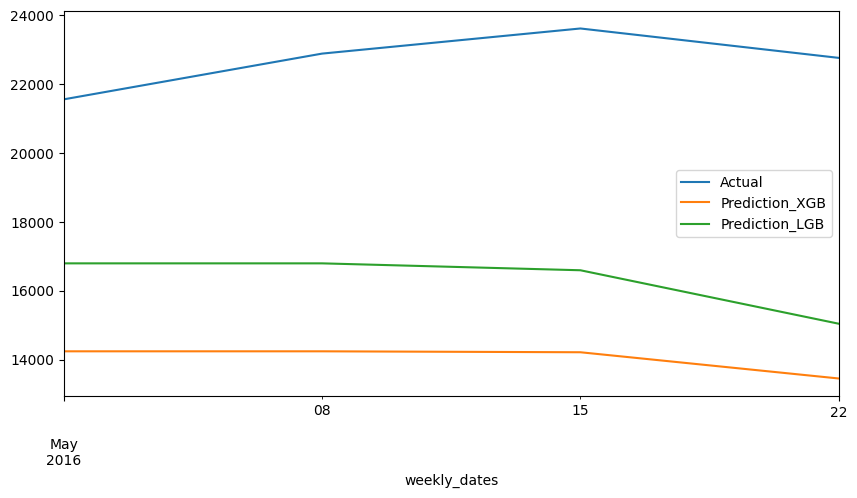

RMSSE XGB:
4.5526501230269085
RMSSE LGB:
3.394809173616081


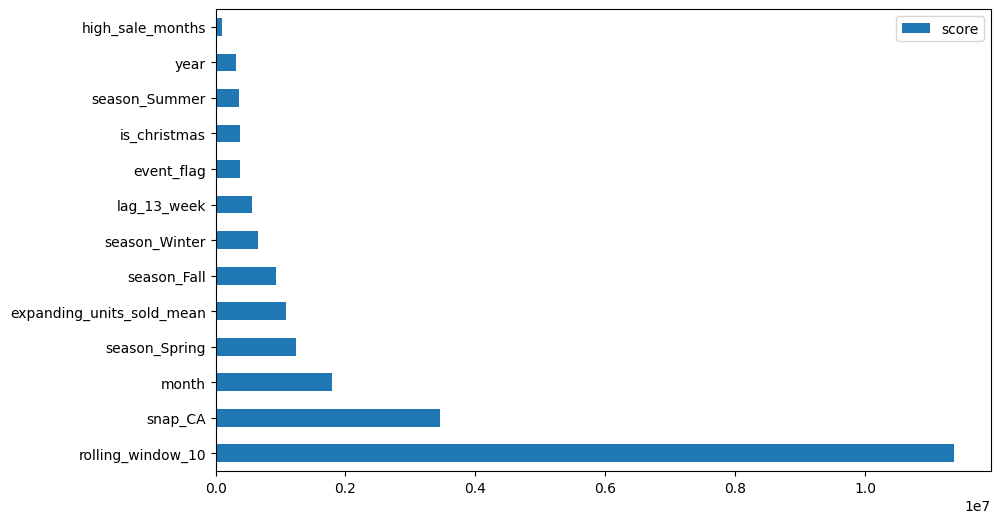

[0]	validation_0-rmse:693.93273
[1]	validation_0-rmse:688.81805
[2]	validation_0-rmse:682.26109
[3]	validation_0-rmse:677.46232
[4]	validation_0-rmse:672.80977
[5]	validation_0-rmse:668.29876
[6]	validation_0-rmse:669.01217
[7]	validation_0-rmse:663.28237
[8]	validation_0-rmse:664.05289
[9]	validation_0-rmse:658.94860
[10]	validation_0-rmse:654.02101
[11]	validation_0-rmse:654.87588
[12]	validation_0-rmse:650.13490
[13]	validation_0-rmse:651.03676
[14]	validation_0-rmse:646.47393
[15]	validation_0-rmse:647.41564
[16]	validation_0-rmse:643.02267
[17]	validation_0-rmse:643.99791
[18]	validation_0-rmse:639.76696
[19]	validation_0-rmse:640.77023
[20]	validation_0-rmse:636.69392
[21]	validation_0-rmse:632.75848
[22]	validation_0-rmse:633.87475
[23]	validation_0-rmse:632.15798
[24]	validation_0-rmse:630.48800
[25]	validation_0-rmse:631.56291
[26]	validation_0-rmse:627.98946
[27]	validation_0-rmse:626.44349
[28]	validation_0-rmse:624.93962
[29]	validation_0-rmse:623.47642
[30]	validation_0-rm

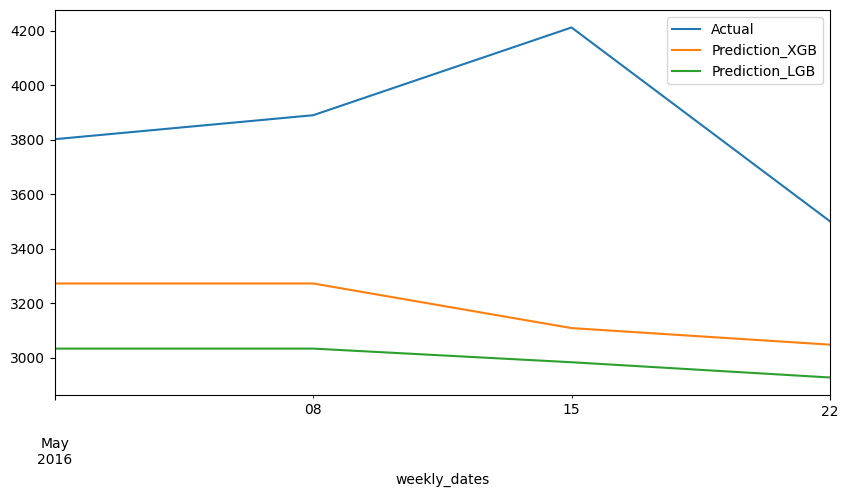

RMSSE XGB:
1.6344641591765154
RMSSE LGB:
2.013431972361385


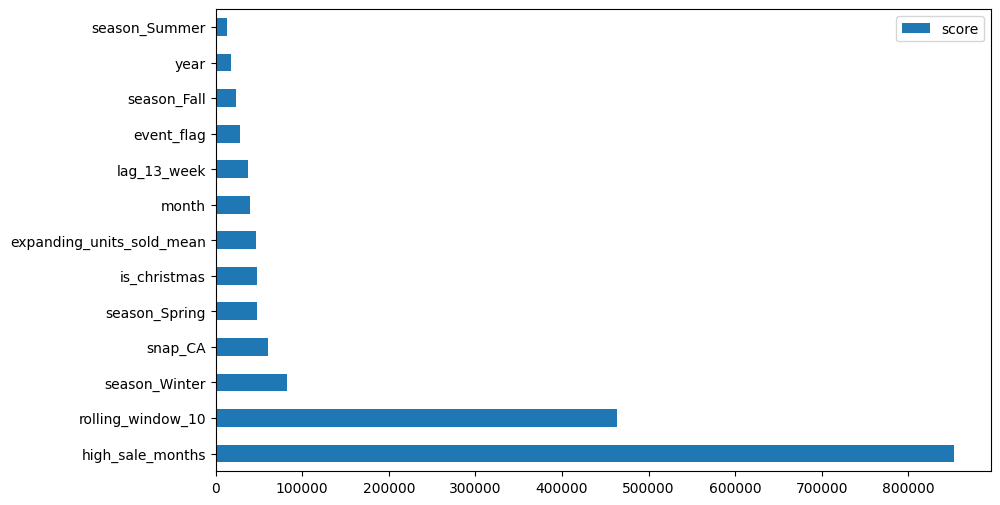

[0]	validation_0-rmse:1693.49192
[1]	validation_0-rmse:1693.94241
[2]	validation_0-rmse:1694.37826
[3]	validation_0-rmse:1679.25074
[4]	validation_0-rmse:1684.06506
[5]	validation_0-rmse:1669.91040
[6]	validation_0-rmse:1656.27096
[7]	validation_0-rmse:1643.12764
[8]	validation_0-rmse:1642.91949
[9]	validation_0-rmse:1630.64908
[10]	validation_0-rmse:1630.37122
[11]	validation_0-rmse:1618.87571
[12]	validation_0-rmse:1618.49697
[13]	validation_0-rmse:1621.49048
[14]	validation_0-rmse:1621.02836
[15]	validation_0-rmse:1614.43154
[16]	validation_0-rmse:1613.91823
[17]	validation_0-rmse:1652.97886
[18]	validation_0-rmse:1652.33344
[19]	validation_0-rmse:1693.96823
[20]	validation_0-rmse:1693.20379
[21]	validation_0-rmse:1714.45773
[22]	validation_0-rmse:1734.91189
[23]	validation_0-rmse:1754.68608
[24]	validation_0-rmse:1756.75343
[25]	validation_0-rmse:1758.74719
[26]	validation_0-rmse:1753.71188
[27]	validation_0-rmse:1752.98344
[28]	validation_0-rmse:1749.39045
[29]	validation_0-rmse:1

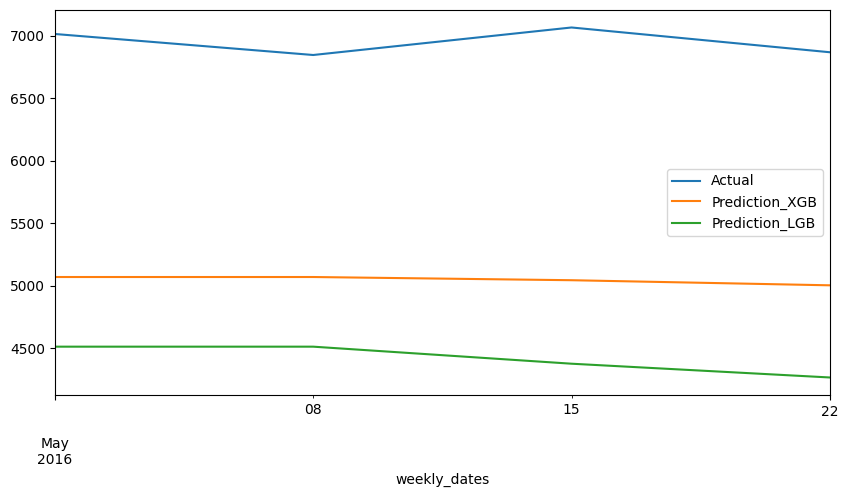

RMSSE XGB:
4.4200746786079055
RMSSE LGB:
5.8854383052293


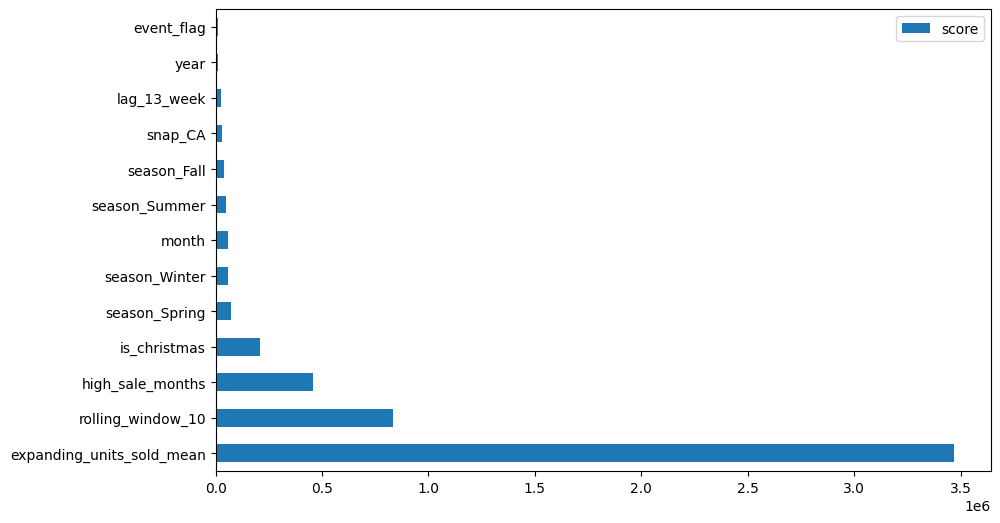

[0]	validation_0-rmse:9265.84583
[1]	validation_0-rmse:9390.37757
[2]	validation_0-rmse:9510.06625
[3]	validation_0-rmse:9558.05273
[4]	validation_0-rmse:9604.76101
[5]	validation_0-rmse:9712.37829
[6]	validation_0-rmse:9756.57891
[7]	validation_0-rmse:9856.09953
[8]	validation_0-rmse:9951.75281
[9]	validation_0-rmse:10043.68867
[10]	validation_0-rmse:10130.76532
[11]	validation_0-rmse:10186.97246
[12]	validation_0-rmse:10268.73780
[13]	validation_0-rmse:10347.33550
[14]	validation_0-rmse:10422.88741
[15]	validation_0-rmse:10467.38840
[16]	validation_0-rmse:10510.27297
[17]	validation_0-rmse:10553.06401
[18]	validation_0-rmse:10594.24504
[19]	validation_0-rmse:10633.87662
[20]	validation_0-rmse:10672.01677
[21]	validation_0-rmse:10708.72205
[22]	validation_0-rmse:10745.76512
[23]	validation_0-rmse:10779.89963
[24]	validation_0-rmse:10811.65602
[25]	validation_0-rmse:10861.68550
[26]	validation_0-rmse:10891.80977
[27]	validation_0-rmse:10920.80052
[28]	validation_0-rmse:10965.60286
[29]

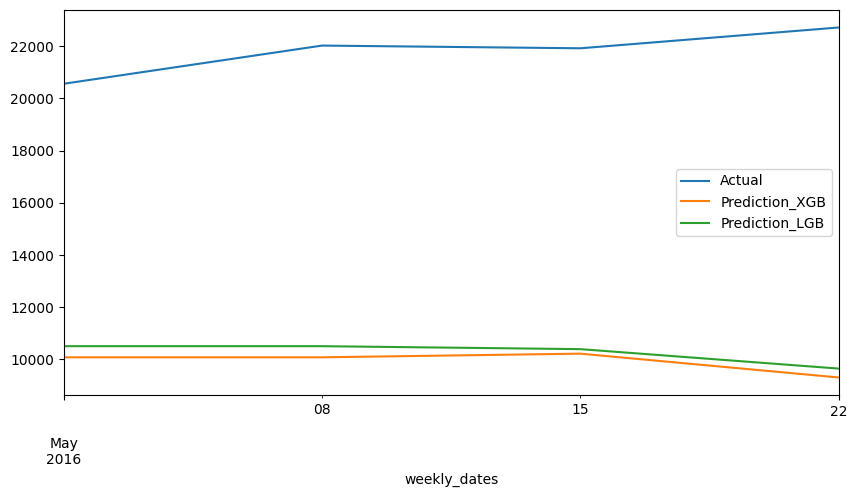

RMSSE XGB:
10.942054613993465
RMSSE LGB:
10.632128610415622


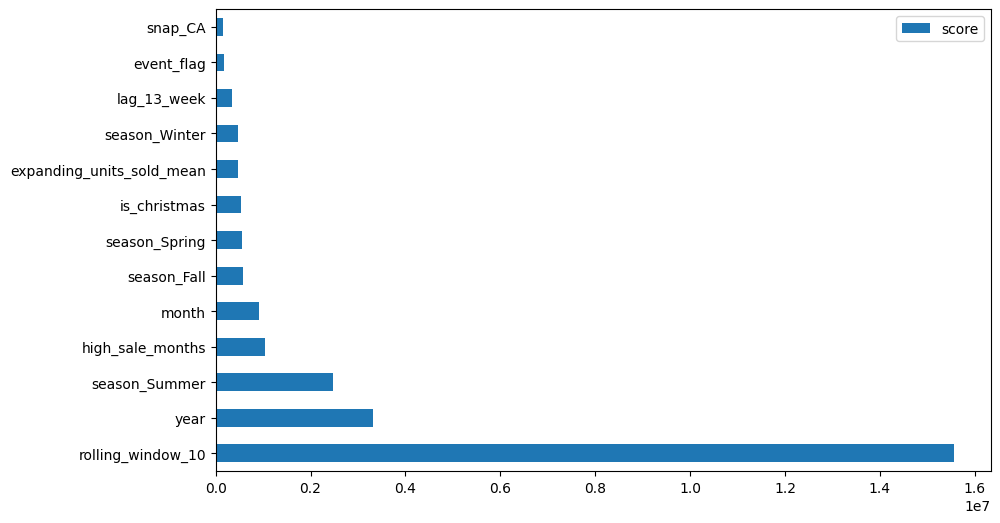

[0]	validation_0-rmse:799.93306
[1]	validation_0-rmse:785.67623
[2]	validation_0-rmse:771.84940
[3]	validation_0-rmse:758.43935
[4]	validation_0-rmse:745.62219
[5]	validation_0-rmse:732.90233
[6]	validation_0-rmse:720.56624
[7]	validation_0-rmse:708.60217
[8]	validation_0-rmse:696.99886
[9]	validation_0-rmse:685.74557
[10]	validation_0-rmse:674.83199
[11]	validation_0-rmse:664.24761
[12]	validation_0-rmse:653.98261
[13]	validation_0-rmse:644.02747
[14]	validation_0-rmse:635.21806
[15]	validation_0-rmse:625.82931
[16]	validation_0-rmse:619.60606
[17]	validation_0-rmse:610.83725
[18]	validation_0-rmse:602.36254
[19]	validation_0-rmse:597.02913
[20]	validation_0-rmse:591.87372
[21]	validation_0-rmse:586.88971
[22]	validation_0-rmse:582.07100
[23]	validation_0-rmse:583.81022
[24]	validation_0-rmse:585.51475
[25]	validation_0-rmse:587.18531
[26]	validation_0-rmse:588.82262
[27]	validation_0-rmse:582.41458
[28]	validation_0-rmse:584.03012
[29]	validation_0-rmse:578.01405
[30]	validation_0-rm

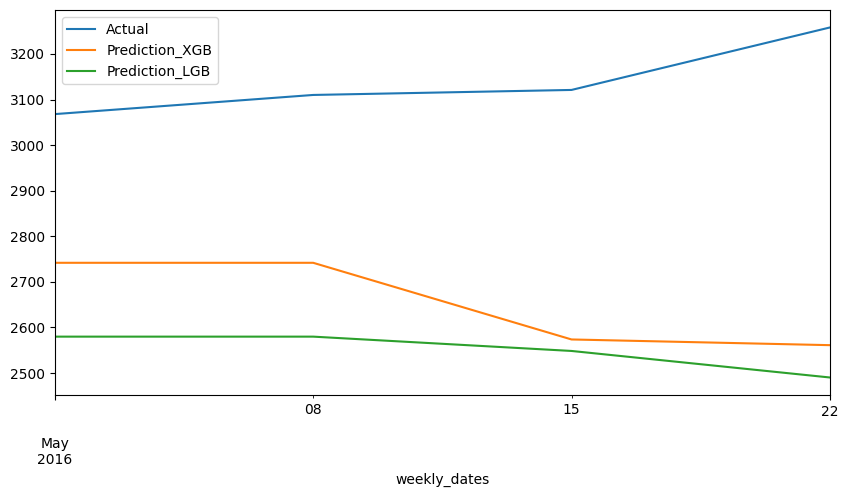

RMSSE XGB:
1.688246219886333
RMSSE LGB:
1.996607000303614


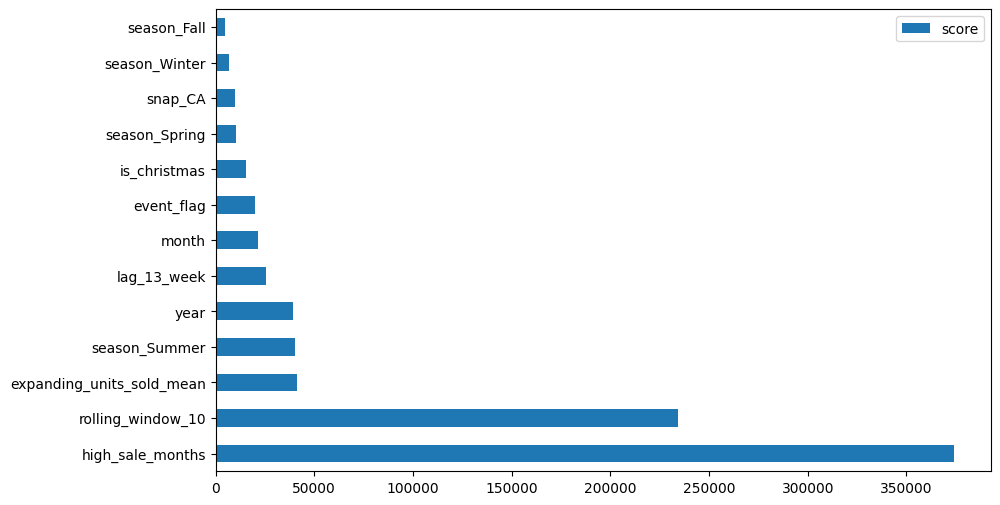

[0]	validation_0-rmse:2585.82274
[1]	validation_0-rmse:2591.25071
[2]	validation_0-rmse:2596.57005
[3]	validation_0-rmse:2620.66113
[4]	validation_0-rmse:2643.85795
[5]	validation_0-rmse:2666.19373
[6]	validation_0-rmse:2670.09445
[7]	validation_0-rmse:2673.91751
[8]	validation_0-rmse:2698.33669
[9]	validation_0-rmse:2701.71529
[10]	validation_0-rmse:2725.74070
[11]	validation_0-rmse:2733.61002
[12]	validation_0-rmse:2756.08642
[13]	validation_0-rmse:2777.74040
[14]	validation_0-rmse:2779.90697
[15]	validation_0-rmse:2786.43448
[16]	validation_0-rmse:2788.51526
[17]	validation_0-rmse:2790.55436
[18]	validation_0-rmse:2808.89019
[19]	validation_0-rmse:2826.97559
[20]	validation_0-rmse:2840.51685
[21]	validation_0-rmse:2841.72991
[22]	validation_0-rmse:2842.91875
[23]	validation_0-rmse:2844.08377
[24]	validation_0-rmse:2849.17179
[25]	validation_0-rmse:2854.12438
[26]	validation_0-rmse:2858.94493
[27]	validation_0-rmse:2863.63726
[28]	validation_0-rmse:2868.20436
[29]	validation_0-rmse:2

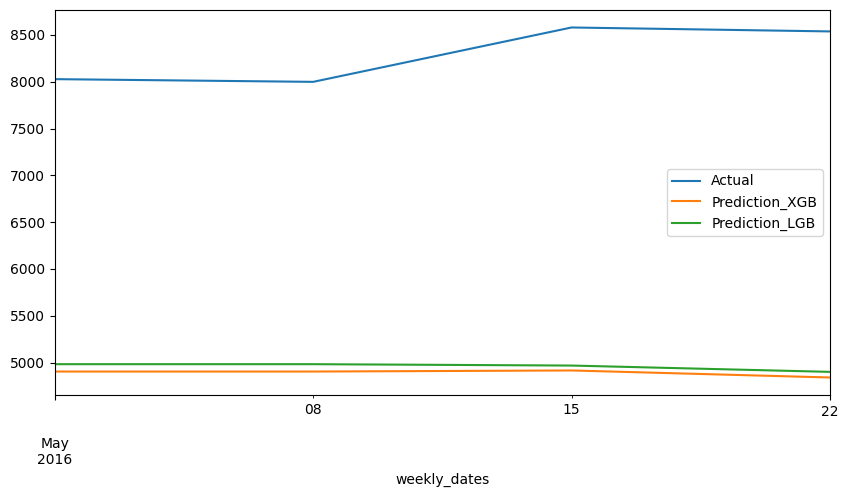

RMSSE XGB:
7.439296901499714
RMSSE LGB:
7.294610195134825


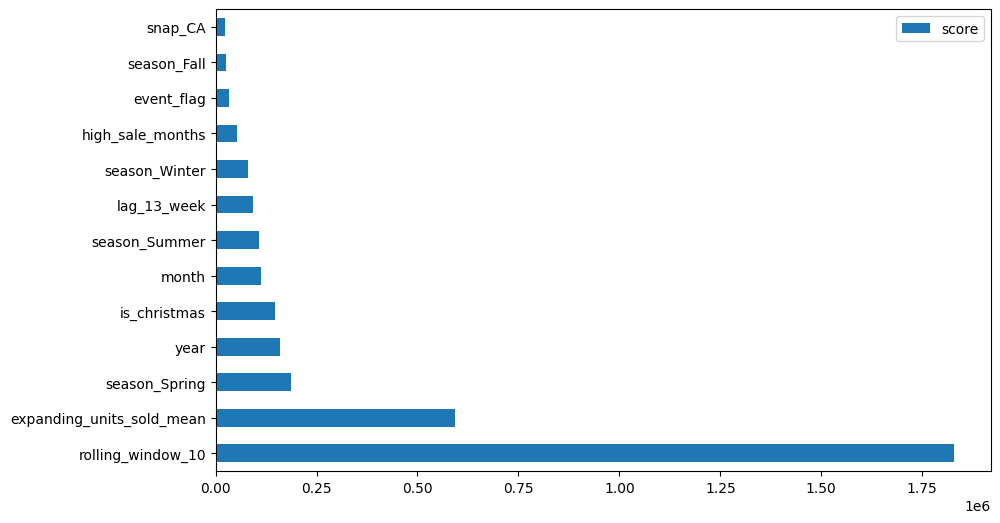

[0]	validation_0-rmse:891.67725
[1]	validation_0-rmse:997.00944
[2]	validation_0-rmse:1148.06790
[3]	validation_0-rmse:1324.05970
[4]	validation_0-rmse:1493.29666
[5]	validation_0-rmse:1685.90618
[6]	validation_0-rmse:1879.16116
[7]	validation_0-rmse:2070.49632
[8]	validation_0-rmse:2258.40328
[9]	validation_0-rmse:2445.71222
[10]	validation_0-rmse:2627.50863
[11]	validation_0-rmse:2803.57837
[12]	validation_0-rmse:2987.42259
[13]	validation_0-rmse:3152.45231
[14]	validation_0-rmse:3330.71964
[15]	validation_0-rmse:3502.89200
[16]	validation_0-rmse:3664.29089
[17]	validation_0-rmse:3808.06408
[18]	validation_0-rmse:3963.47966
[19]	validation_0-rmse:4113.34160
[20]	validation_0-rmse:4257.81420
[21]	validation_0-rmse:4382.20461
[22]	validation_0-rmse:4513.69643
[23]	validation_0-rmse:4643.64604
[24]	validation_0-rmse:4768.85060
[25]	validation_0-rmse:4920.93736
[26]	validation_0-rmse:5030.00629
[27]	validation_0-rmse:5063.97569
[28]	validation_0-rmse:5199.54058
[29]	validation_0-rmse:533

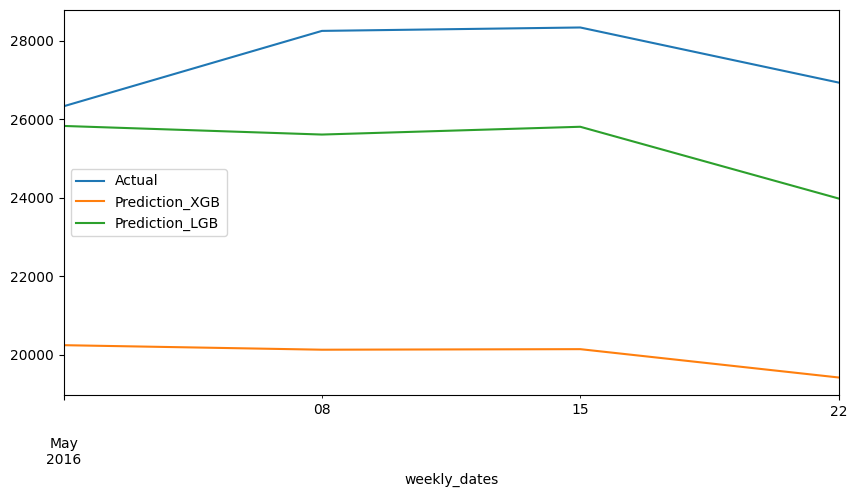

RMSSE XGB:
2.4827658780977173
RMSSE LGB:
0.7796392014920656


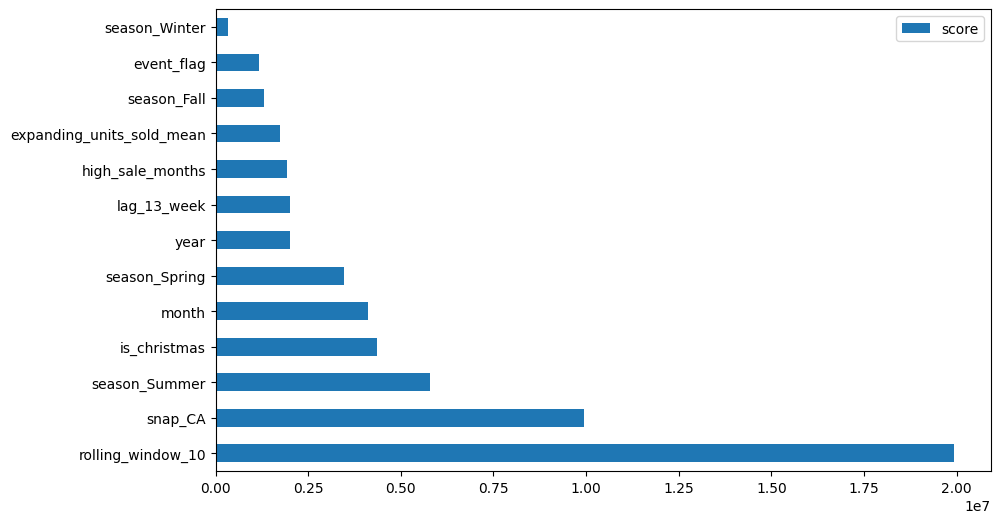

[0]	validation_0-rmse:694.35283
[1]	validation_0-rmse:723.72125
[2]	validation_0-rmse:752.05713
[3]	validation_0-rmse:779.39342
[4]	validation_0-rmse:785.34475
[5]	validation_0-rmse:796.81190
[6]	validation_0-rmse:807.91510
[7]	validation_0-rmse:818.66558
[8]	validation_0-rmse:841.37714
[9]	validation_0-rmse:851.18446
[10]	validation_0-rmse:873.62903
[11]	validation_0-rmse:895.27372
[12]	validation_0-rmse:916.14641
[13]	validation_0-rmse:942.20596
[14]	validation_0-rmse:967.49261
[15]	validation_0-rmse:992.02845
[16]	validation_0-rmse:1015.83483
[17]	validation_0-rmse:1020.84561
[18]	validation_0-rmse:1025.68958
[19]	validation_0-rmse:1030.37231
[20]	validation_0-rmse:1034.89910
[21]	validation_0-rmse:1039.27530
[22]	validation_0-rmse:1058.42109
[23]	validation_0-rmse:1077.05971
[24]	validation_0-rmse:1095.20431
[25]	validation_0-rmse:1098.64154
[26]	validation_0-rmse:1115.99744
[27]	validation_0-rmse:1124.43798
[28]	validation_0-rmse:1136.62975
[29]	validation_0-rmse:1148.36735
[30]	v

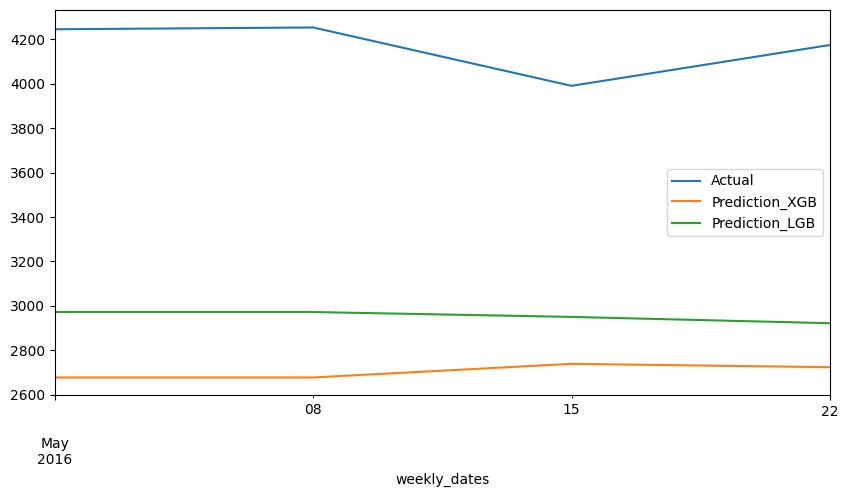

RMSSE XGB:
3.5051758392695715
RMSSE LGB:
2.904478089629385


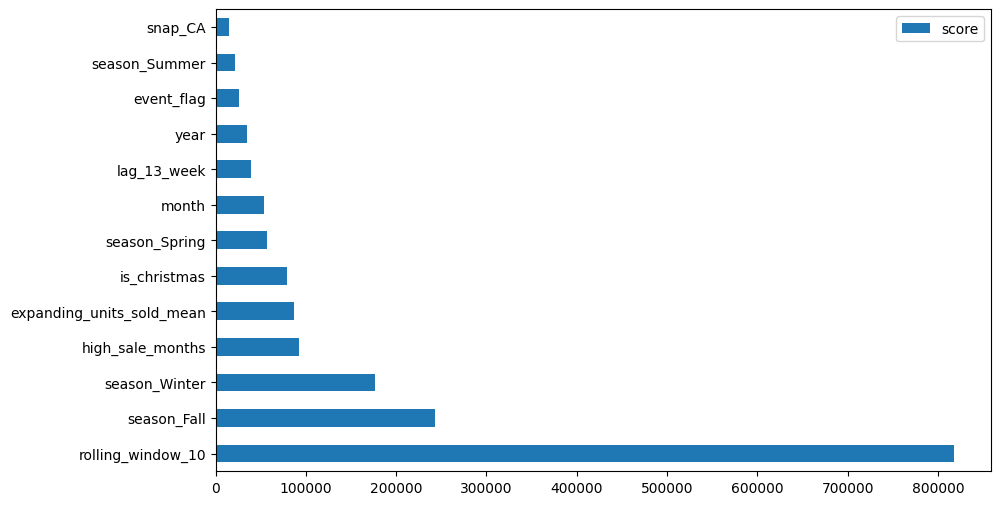

[0]	validation_0-rmse:2332.52764
[1]	validation_0-rmse:2329.51882
[2]	validation_0-rmse:2326.57001
[3]	validation_0-rmse:2323.68014
[4]	validation_0-rmse:2320.84836
[5]	validation_0-rmse:2318.07261
[6]	validation_0-rmse:2315.35301
[7]	validation_0-rmse:2312.68752
[8]	validation_0-rmse:2310.07522
[9]	validation_0-rmse:2307.51609
[10]	validation_0-rmse:2305.00826
[11]	validation_0-rmse:2302.55065
[12]	validation_0-rmse:2300.14140
[13]	validation_0-rmse:2395.84510
[14]	validation_0-rmse:2391.13844
[15]	validation_0-rmse:2458.33904
[16]	validation_0-rmse:2522.96497
[17]	validation_0-rmse:2518.62010
[18]	validation_0-rmse:2514.39146
[19]	validation_0-rmse:2571.99682
[20]	validation_0-rmse:2627.38806
[21]	validation_0-rmse:2677.38861
[22]	validation_0-rmse:2752.91591
[23]	validation_0-rmse:2800.02605
[24]	validation_0-rmse:2845.73393
[25]	validation_0-rmse:2890.08155
[26]	validation_0-rmse:2933.10831
[27]	validation_0-rmse:2974.85271
[28]	validation_0-rmse:3015.35149
[29]	validation_0-rmse:3

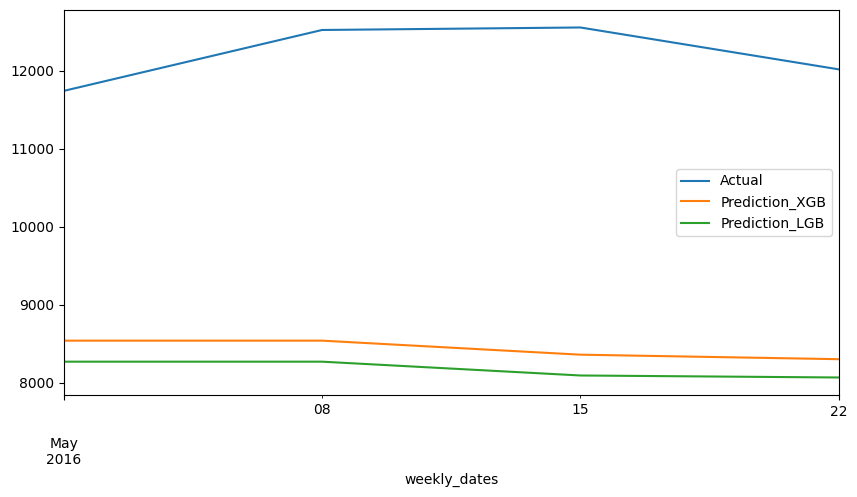

RMSSE XGB:
4.814541262911646
RMSSE LGB:
5.143352433559948


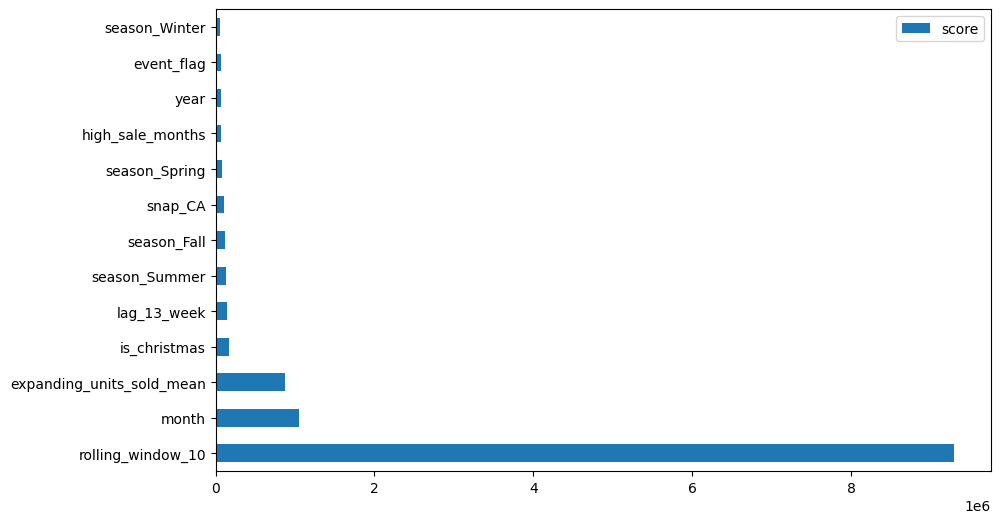

[0]	validation_0-rmse:2760.98096
[1]	validation_0-rmse:2879.36143
[2]	validation_0-rmse:2993.20238
[3]	validation_0-rmse:3100.37476
[4]	validation_0-rmse:3205.72100
[5]	validation_0-rmse:3307.01111
[6]	validation_0-rmse:3402.35507
[7]	validation_0-rmse:3496.06504
[8]	validation_0-rmse:3589.54924
[9]	validation_0-rmse:3676.24465
[10]	validation_0-rmse:3759.59054
[11]	validation_0-rmse:3833.90718
[12]	validation_0-rmse:3905.35319
[13]	validation_0-rmse:3974.95245
[14]	validation_0-rmse:4041.00857
[15]	validation_0-rmse:4105.36868
[16]	validation_0-rmse:4166.43952
[17]	validation_0-rmse:4228.60125
[18]	validation_0-rmse:4288.37635
[19]	validation_0-rmse:4345.85682
[20]	validation_0-rmse:4401.12951
[21]	validation_0-rmse:4453.46340
[22]	validation_0-rmse:4504.60370
[23]	validation_0-rmse:4553.77947
[24]	validation_0-rmse:4600.34716
[25]	validation_0-rmse:4648.95940
[26]	validation_0-rmse:4695.72130
[27]	validation_0-rmse:4732.07069
[28]	validation_0-rmse:4767.07767
[29]	validation_0-rmse:4

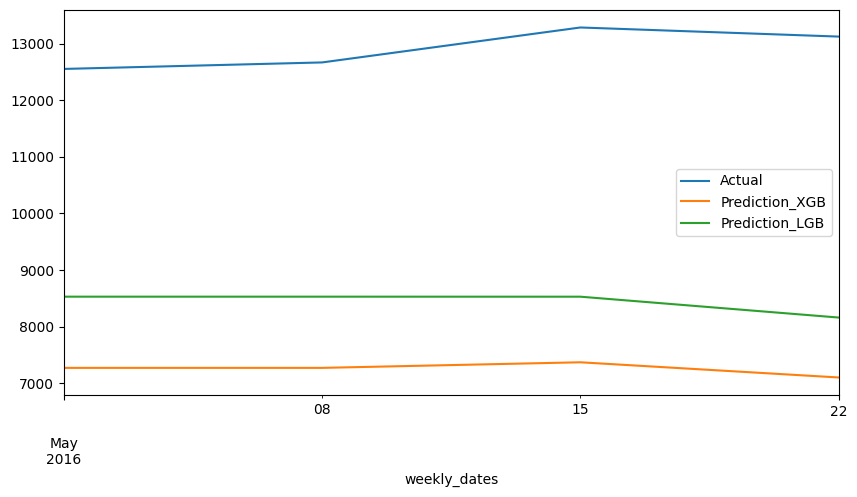

RMSSE XGB:
7.397837902202545
RMSSE LGB:
5.863148881012268


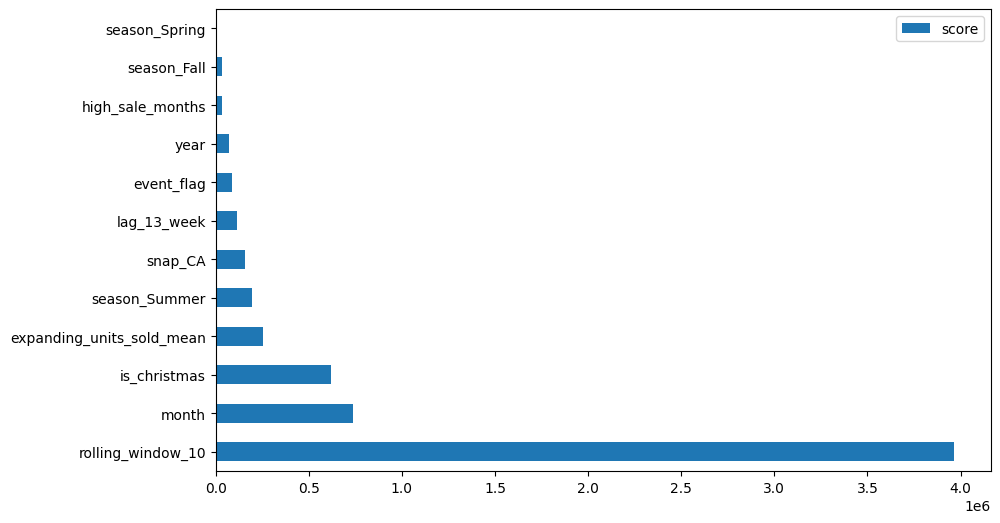

[0]	validation_0-rmse:715.27656
[1]	validation_0-rmse:716.69266
[2]	validation_0-rmse:718.10110
[3]	validation_0-rmse:719.50110
[4]	validation_0-rmse:720.89183
[5]	validation_0-rmse:725.38938
[6]	validation_0-rmse:726.80296
[7]	validation_0-rmse:726.62949
[8]	validation_0-rmse:726.46257
[9]	validation_0-rmse:726.30215
[10]	validation_0-rmse:715.87814
[11]	validation_0-rmse:705.83463
[12]	validation_0-rmse:696.15779
[13]	validation_0-rmse:685.83913
[14]	validation_0-rmse:675.88317
[15]	validation_0-rmse:666.27719
[16]	validation_0-rmse:657.86474
[17]	validation_0-rmse:648.89227
[18]	validation_0-rmse:640.23527
[19]	validation_0-rmse:632.66653
[20]	validation_0-rmse:622.45761
[21]	validation_0-rmse:615.09755
[22]	validation_0-rmse:608.29683
[23]	validation_0-rmse:600.43899
[24]	validation_0-rmse:591.76339
[25]	validation_0-rmse:589.94735
[26]	validation_0-rmse:585.15968
[27]	validation_0-rmse:585.52441
[28]	validation_0-rmse:578.85485
[29]	validation_0-rmse:582.35304
[30]	validation_0-rm

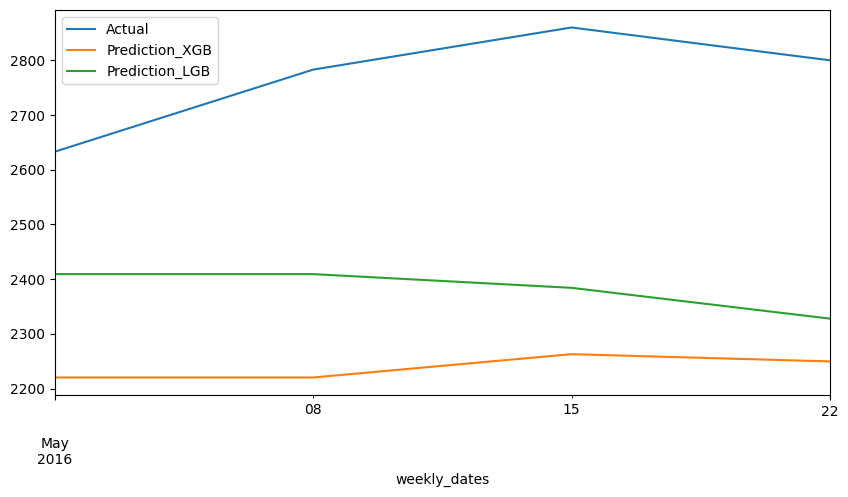

RMSSE XGB:
2.2221557050200693
RMSSE LGB:
1.659239953510185


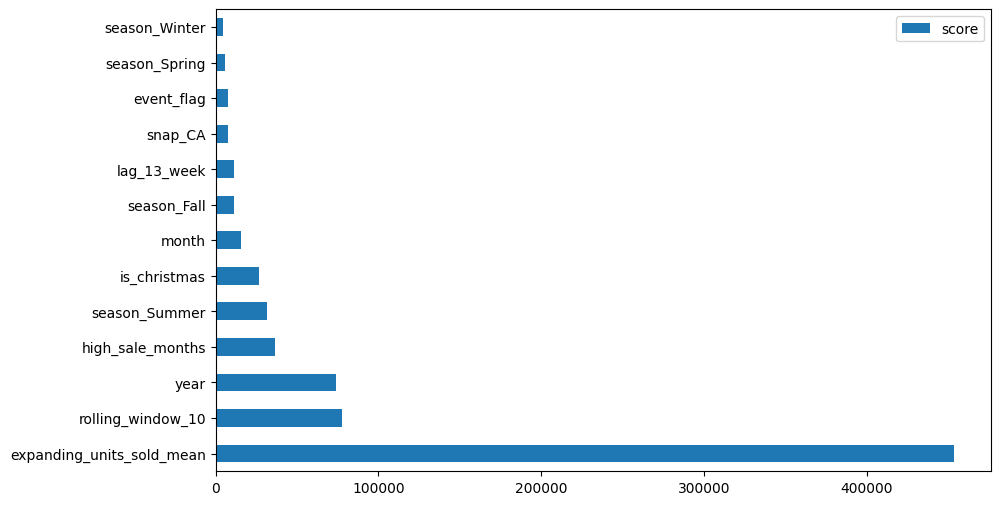

[0]	validation_0-rmse:1433.84551
[1]	validation_0-rmse:1436.09314
[2]	validation_0-rmse:1438.26908
[3]	validation_0-rmse:1437.19826
[4]	validation_0-rmse:1439.25580
[5]	validation_0-rmse:1406.04550
[6]	validation_0-rmse:1385.01790
[7]	validation_0-rmse:1386.89890
[8]	validation_0-rmse:1356.84840
[9]	validation_0-rmse:1358.64452
[10]	validation_0-rmse:1330.58327
[11]	validation_0-rmse:1333.49683
[12]	validation_0-rmse:1335.15735
[13]	validation_0-rmse:1337.98000
[14]	validation_0-rmse:1339.56695
[15]	validation_0-rmse:1315.98760
[16]	validation_0-rmse:1293.28133
[17]	validation_0-rmse:1294.77666
[18]	validation_0-rmse:1296.22417
[19]	validation_0-rmse:1275.78434
[20]	validation_0-rmse:1277.16688
[21]	validation_0-rmse:1278.50520
[22]	validation_0-rmse:1280.96223
[23]	validation_0-rmse:1282.24142
[24]	validation_0-rmse:1284.62408
[25]	validation_0-rmse:1266.39599
[26]	validation_0-rmse:1268.70520
[27]	validation_0-rmse:1270.96842
[28]	validation_0-rmse:1254.46185
[29]	validation_0-rmse:1

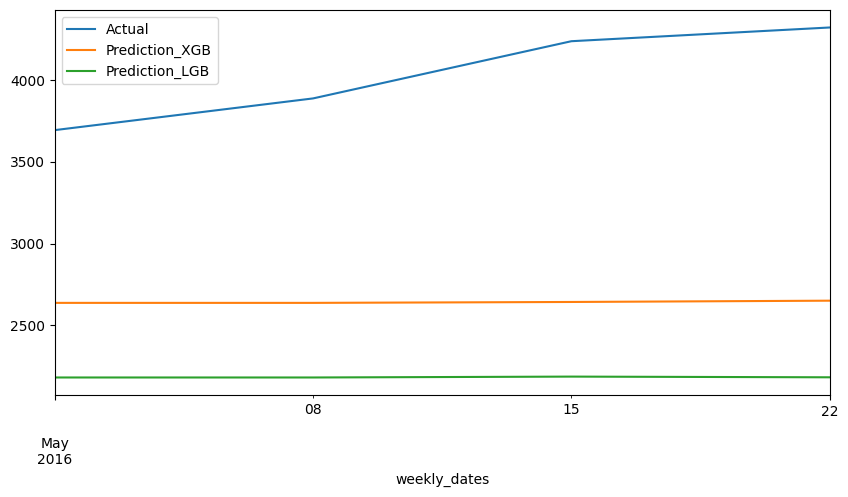

RMSSE XGB:
7.744466181628717
RMSSE LGB:
10.230357274768549


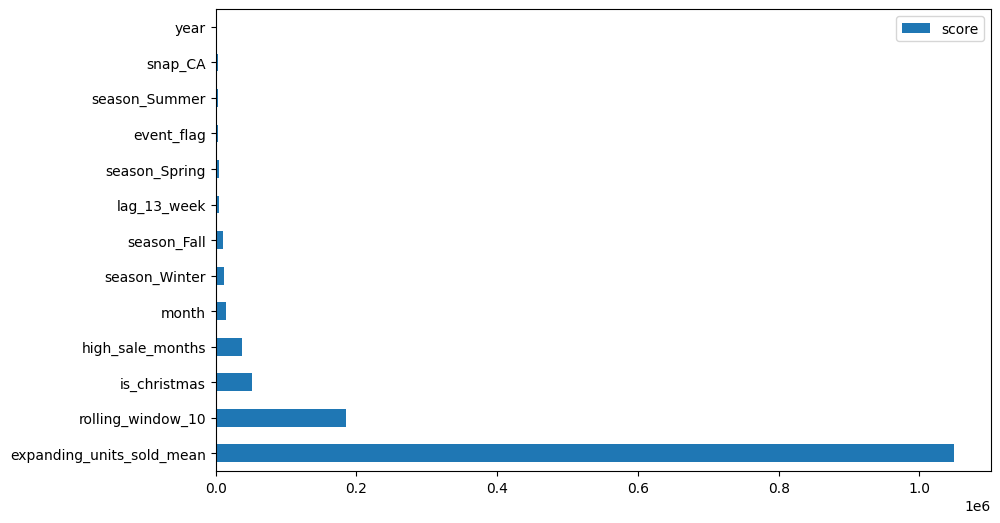

[0]	validation_0-rmse:2079.65730
[1]	validation_0-rmse:2179.77887
[2]	validation_0-rmse:2268.66813
[3]	validation_0-rmse:2354.72833
[4]	validation_0-rmse:2437.97088
[5]	validation_0-rmse:2527.31566
[6]	validation_0-rmse:2609.83485
[7]	validation_0-rmse:2694.64753
[8]	validation_0-rmse:2776.67515
[9]	validation_0-rmse:2855.97309
[10]	validation_0-rmse:2932.60406
[11]	validation_0-rmse:3006.63343
[12]	validation_0-rmse:3070.05697
[13]	validation_0-rmse:3139.37175
[14]	validation_0-rmse:3206.28800
[15]	validation_0-rmse:3270.87739
[16]	validation_0-rmse:3333.21108
[17]	validation_0-rmse:3387.09086
[18]	validation_0-rmse:3445.34469
[19]	validation_0-rmse:3501.54541
[20]	validation_0-rmse:3555.75864
[21]	validation_0-rmse:3608.05150
[22]	validation_0-rmse:3650.73856
[23]	validation_0-rmse:3690.04773
[24]	validation_0-rmse:3727.88400
[25]	validation_0-rmse:3764.36351
[26]	validation_0-rmse:3799.53306
[27]	validation_0-rmse:3833.43927
[28]	validation_0-rmse:3866.12501
[29]	validation_0-rmse:3

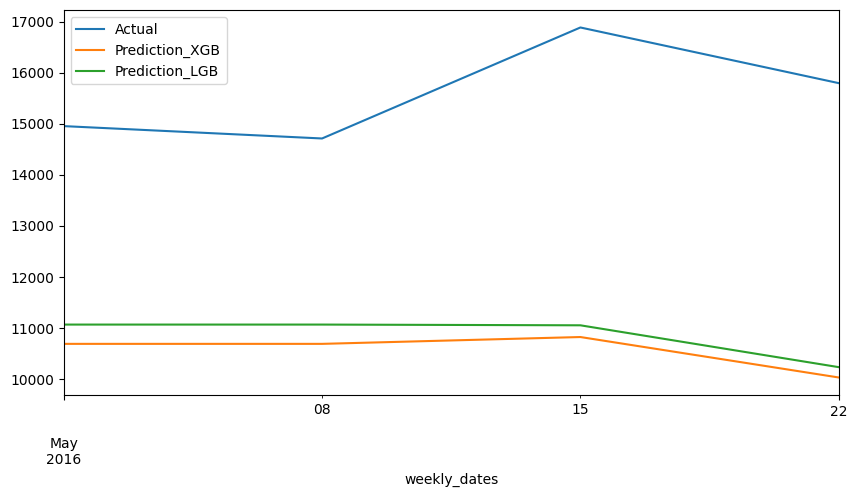

RMSSE XGB:
3.255488818763897
RMSSE LGB:
3.0791443734711312


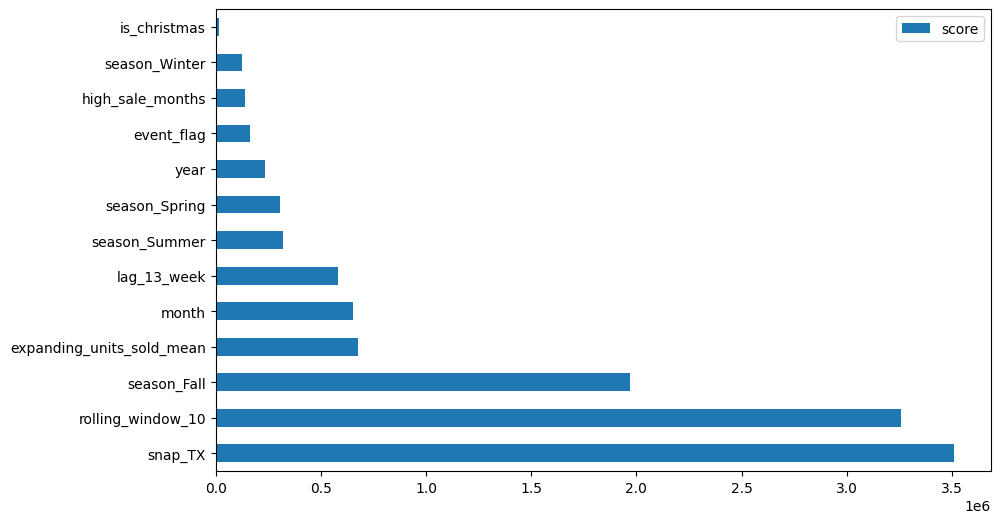

[0]	validation_0-rmse:555.11944
[1]	validation_0-rmse:565.18779
[2]	validation_0-rmse:575.29757
[3]	validation_0-rmse:584.68611
[4]	validation_0-rmse:594.11940
[5]	validation_0-rmse:603.22154
[6]	validation_0-rmse:603.75604
[7]	validation_0-rmse:613.14217
[8]	validation_0-rmse:622.21621
[9]	validation_0-rmse:630.98786
[10]	validation_0-rmse:639.46656
[11]	validation_0-rmse:647.66145
[12]	validation_0-rmse:655.58169
[13]	validation_0-rmse:663.23597
[14]	validation_0-rmse:669.98701
[15]	validation_0-rmse:677.15655
[16]	validation_0-rmse:684.08449
[17]	validation_0-rmse:690.77861
[18]	validation_0-rmse:697.24661
[19]	validation_0-rmse:696.62553
[20]	validation_0-rmse:700.99559
[21]	validation_0-rmse:706.46592
[22]	validation_0-rmse:711.62701
[23]	validation_0-rmse:716.60643
[24]	validation_0-rmse:720.27647
[25]	validation_0-rmse:723.86226
[26]	validation_0-rmse:727.31074
[27]	validation_0-rmse:730.62725
[28]	validation_0-rmse:734.93705
[29]	validation_0-rmse:738.01009
[30]	validation_0-rm

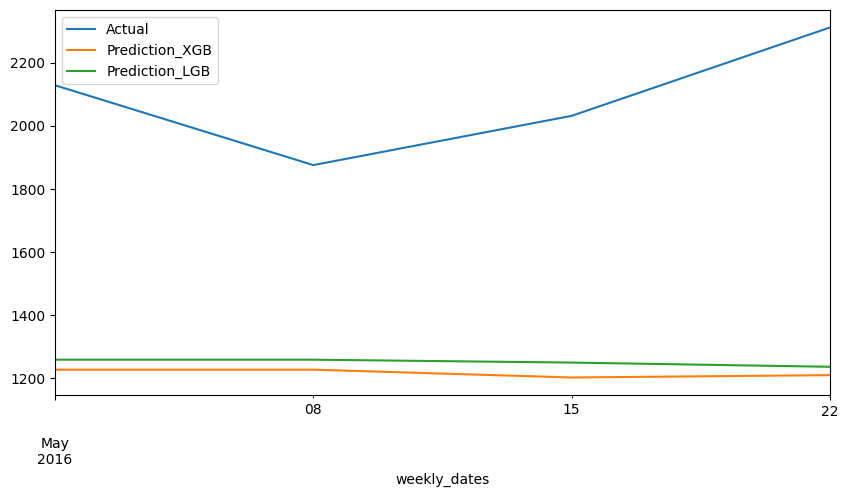

RMSSE XGB:
5.432643833559465
RMSSE LGB:
5.2296987852698775


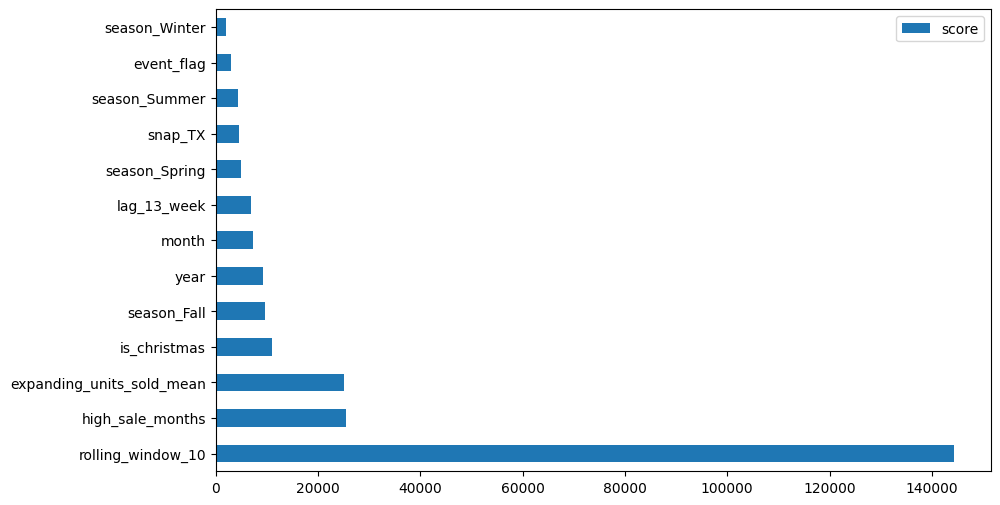

[0]	validation_0-rmse:1725.89791
[1]	validation_0-rmse:1765.62223
[2]	validation_0-rmse:1806.10205
[3]	validation_0-rmse:1845.09412
[4]	validation_0-rmse:1882.64973
[5]	validation_0-rmse:1918.26877
[6]	validation_0-rmse:1951.28211
[7]	validation_0-rmse:1984.91070
[8]	validation_0-rmse:2017.29181
[9]	validation_0-rmse:2048.47010
[10]	validation_0-rmse:2078.02851
[11]	validation_0-rmse:2107.82235
[12]	validation_0-rmse:2134.22457
[13]	validation_0-rmse:2161.94241
[14]	validation_0-rmse:2187.85227
[15]	validation_0-rmse:2213.58629
[16]	validation_0-rmse:2238.36728
[17]	validation_0-rmse:2261.16510
[18]	validation_0-rmse:2283.47296
[19]	validation_0-rmse:2304.94639
[20]	validation_0-rmse:2326.34006
[21]	validation_0-rmse:2346.93971
[22]	validation_0-rmse:2365.82841
[23]	validation_0-rmse:2384.96153
[24]	validation_0-rmse:2403.38392
[25]	validation_0-rmse:2421.44704
[26]	validation_0-rmse:2434.36749
[27]	validation_0-rmse:2451.13200
[28]	validation_0-rmse:2463.10550
[29]	validation_0-rmse:2

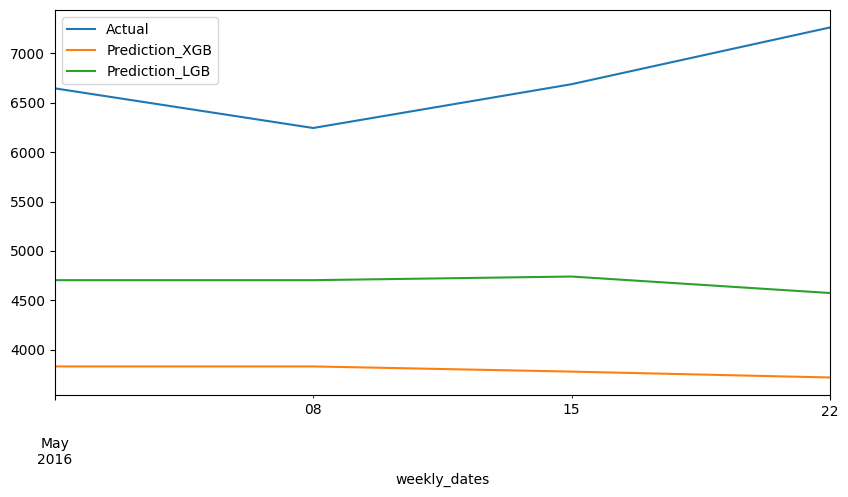

RMSSE XGB:
7.372325052509399
RMSSE LGB:
5.179177962089366


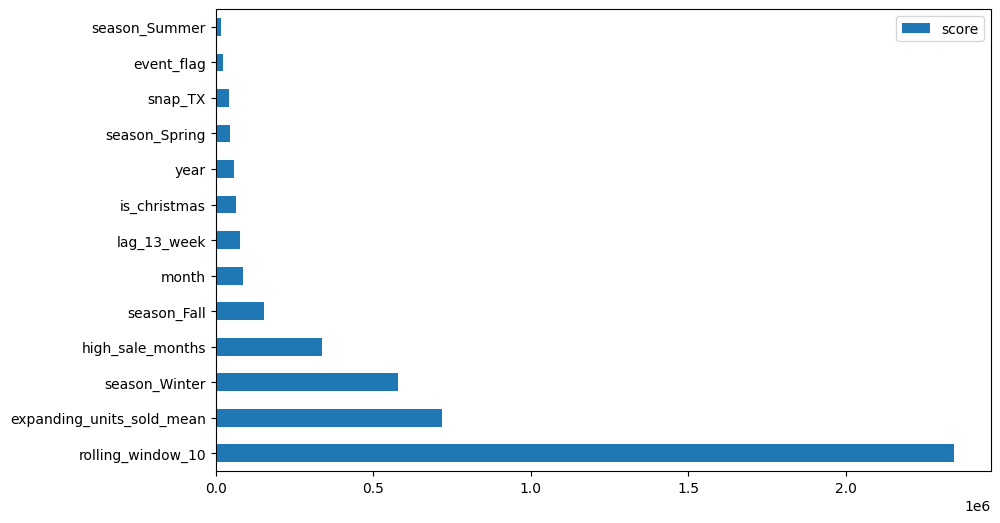

[0]	validation_0-rmse:1203.54041
[1]	validation_0-rmse:1270.51404
[2]	validation_0-rmse:1339.34227
[3]	validation_0-rmse:1411.01833
[4]	validation_0-rmse:1481.00949
[5]	validation_0-rmse:1555.16795
[6]	validation_0-rmse:1628.52913
[7]	validation_0-rmse:1691.78830
[8]	validation_0-rmse:1783.74044
[9]	validation_0-rmse:1874.04481
[10]	validation_0-rmse:1962.39418
[11]	validation_0-rmse:2048.57668
[12]	validation_0-rmse:2108.53023
[13]	validation_0-rmse:2190.07563
[14]	validation_0-rmse:2239.34923
[15]	validation_0-rmse:2293.57468
[16]	validation_0-rmse:2346.04195
[17]	validation_0-rmse:2418.31608
[18]	validation_0-rmse:2476.43570
[19]	validation_0-rmse:2523.70271
[20]	validation_0-rmse:2569.37804
[21]	validation_0-rmse:2622.92303
[22]	validation_0-rmse:2665.81224
[23]	validation_0-rmse:2707.23038
[24]	validation_0-rmse:2756.69816
[25]	validation_0-rmse:2835.31223
[26]	validation_0-rmse:2863.57271
[27]	validation_0-rmse:2884.31986
[28]	validation_0-rmse:2910.83457
[29]	validation_0-rmse:2

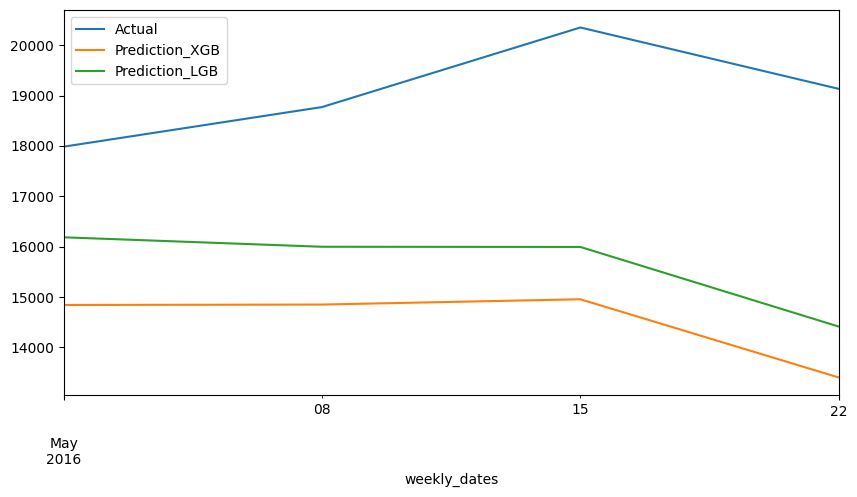

RMSSE XGB:
2.63992567915381
RMSSE LGB:
2.042232353065228


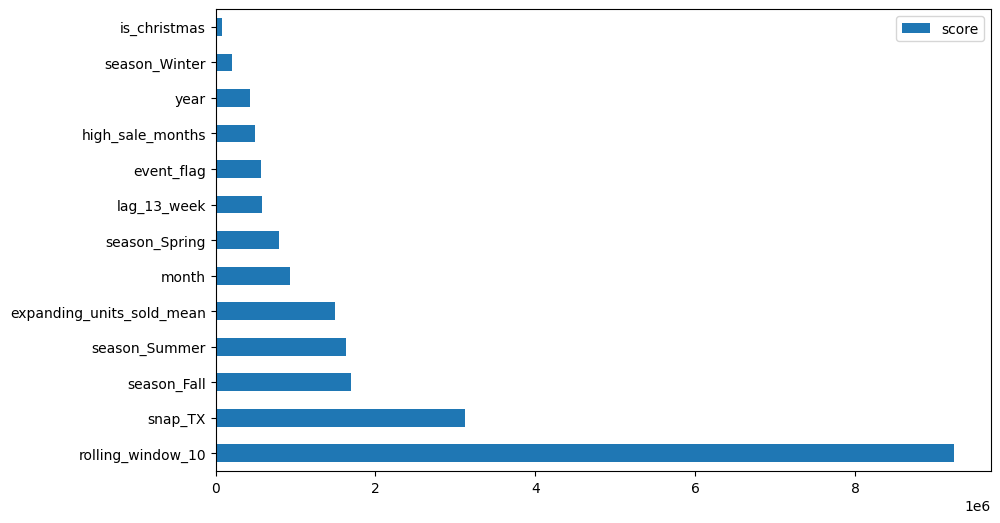

[0]	validation_0-rmse:654.14517
[1]	validation_0-rmse:669.74181
[2]	validation_0-rmse:684.75029
[3]	validation_0-rmse:699.19238
[4]	validation_0-rmse:713.08925
[5]	validation_0-rmse:726.37503
[6]	validation_0-rmse:739.15721
[7]	validation_0-rmse:751.54325
[8]	validation_0-rmse:763.38606
[9]	validation_0-rmse:774.77957
[10]	validation_0-rmse:785.74052
[11]	validation_0-rmse:796.36294
[12]	validation_0-rmse:806.58301
[13]	validation_0-rmse:816.35334
[14]	validation_0-rmse:825.75254
[15]	validation_0-rmse:835.28613
[16]	validation_0-rmse:844.56631
[17]	validation_0-rmse:845.20092
[18]	validation_0-rmse:845.81874
[19]	validation_0-rmse:847.49474
[20]	validation_0-rmse:849.13720
[21]	validation_0-rmse:849.71468
[22]	validation_0-rmse:850.27684
[23]	validation_0-rmse:857.50066
[24]	validation_0-rmse:857.85520
[25]	validation_0-rmse:863.56570
[26]	validation_0-rmse:868.14818
[27]	validation_0-rmse:868.32205
[28]	validation_0-rmse:873.39231
[29]	validation_0-rmse:873.42635
[30]	validation_0-rm

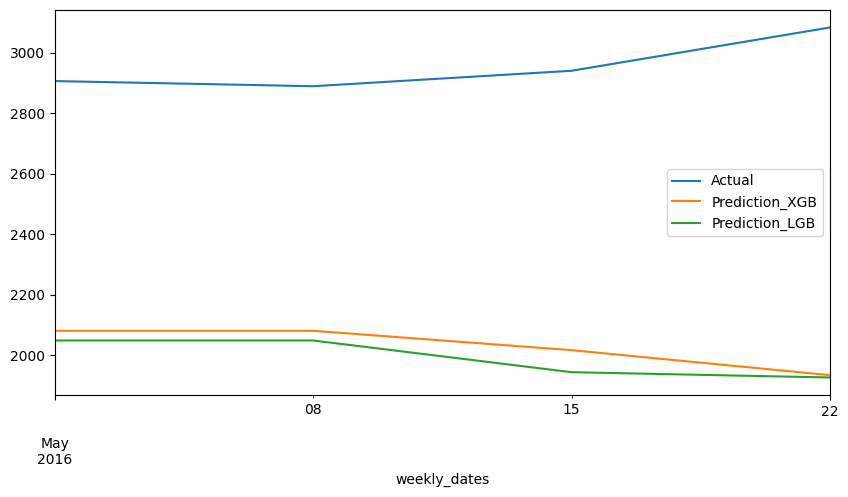

RMSSE XGB:
3.9194200899298264
RMSSE LGB:
4.0645834581994045


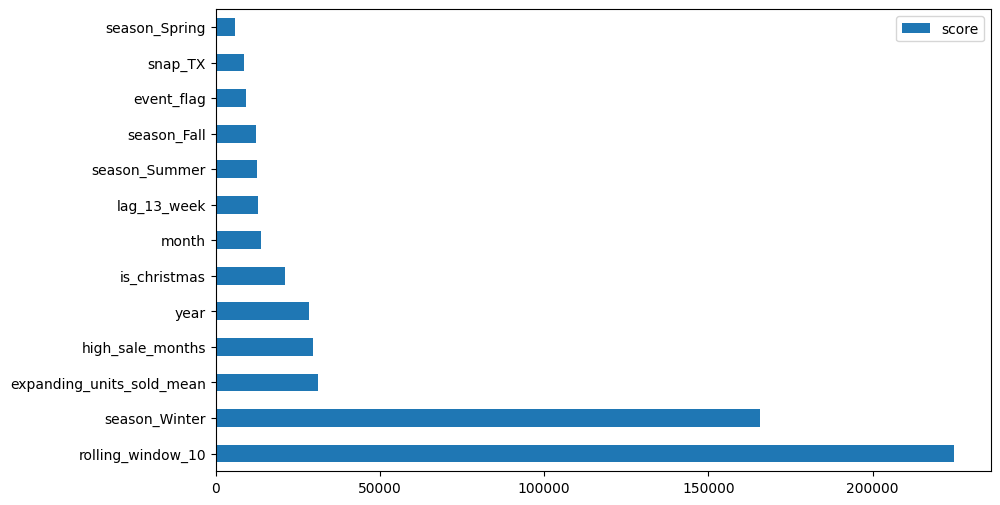

[0]	validation_0-rmse:1103.20427
[1]	validation_0-rmse:1101.08805
[2]	validation_0-rmse:1077.55389
[3]	validation_0-rmse:1054.88855
[4]	validation_0-rmse:1033.64270
[5]	validation_0-rmse:1050.57775
[6]	validation_0-rmse:1067.19292
[7]	validation_0-rmse:1083.49244
[8]	validation_0-rmse:1099.48163
[9]	validation_0-rmse:1115.16511
[10]	validation_0-rmse:1096.65656
[11]	validation_0-rmse:1096.44160
[12]	validation_0-rmse:1111.33525
[13]	validation_0-rmse:1125.94290
[14]	validation_0-rmse:1140.26957
[15]	validation_0-rmse:1172.55848
[16]	validation_0-rmse:1207.43120
[17]	validation_0-rmse:1203.99581
[18]	validation_0-rmse:1236.23677
[19]	validation_0-rmse:1244.33208
[20]	validation_0-rmse:1276.87363
[21]	validation_0-rmse:1308.18881
[22]	validation_0-rmse:1338.32025
[23]	validation_0-rmse:1367.30977
[24]	validation_0-rmse:1395.51354
[25]	validation_0-rmse:1395.63544
[26]	validation_0-rmse:1405.77958
[27]	validation_0-rmse:1415.72372
[28]	validation_0-rmse:1441.03473
[29]	validation_0-rmse:1

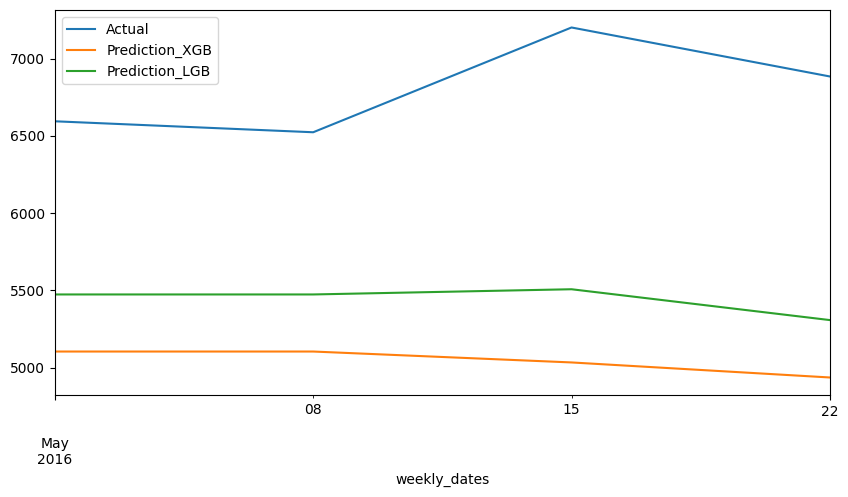

RMSSE XGB:
3.724378828678039
RMSSE LGB:
2.8992712146319315


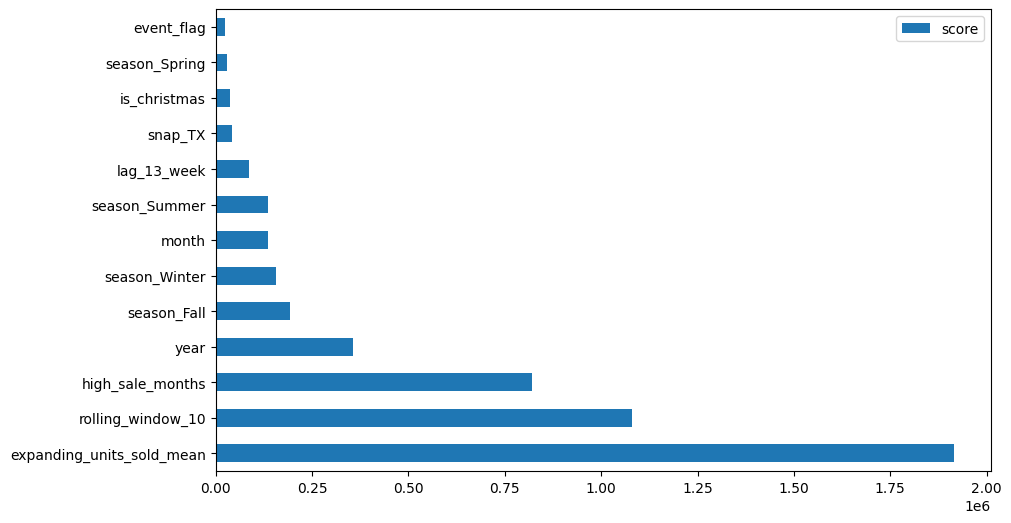

[0]	validation_0-rmse:4194.91885
[1]	validation_0-rmse:4196.31082
[2]	validation_0-rmse:4235.52982
[3]	validation_0-rmse:4236.48852
[4]	validation_0-rmse:4282.51223
[5]	validation_0-rmse:4318.08480
[6]	validation_0-rmse:4318.32871
[7]	validation_0-rmse:4368.02095
[8]	validation_0-rmse:4406.51767
[9]	validation_0-rmse:4450.28464
[10]	validation_0-rmse:4485.84911
[11]	validation_0-rmse:4520.16103
[12]	validation_0-rmse:4548.27841
[13]	validation_0-rmse:4580.49307
[14]	validation_0-rmse:4597.76764
[15]	validation_0-rmse:4638.06034
[16]	validation_0-rmse:4653.96025
[17]	validation_0-rmse:4664.94673
[18]	validation_0-rmse:4698.05715
[19]	validation_0-rmse:4725.11288
[20]	validation_0-rmse:4712.64655
[21]	validation_0-rmse:4735.19556
[22]	validation_0-rmse:4756.01088
[23]	validation_0-rmse:4754.56007
[24]	validation_0-rmse:4775.41176
[25]	validation_0-rmse:4801.80122
[26]	validation_0-rmse:4802.25127
[27]	validation_0-rmse:4839.56930
[28]	validation_0-rmse:4855.28763
[29]	validation_0-rmse:4

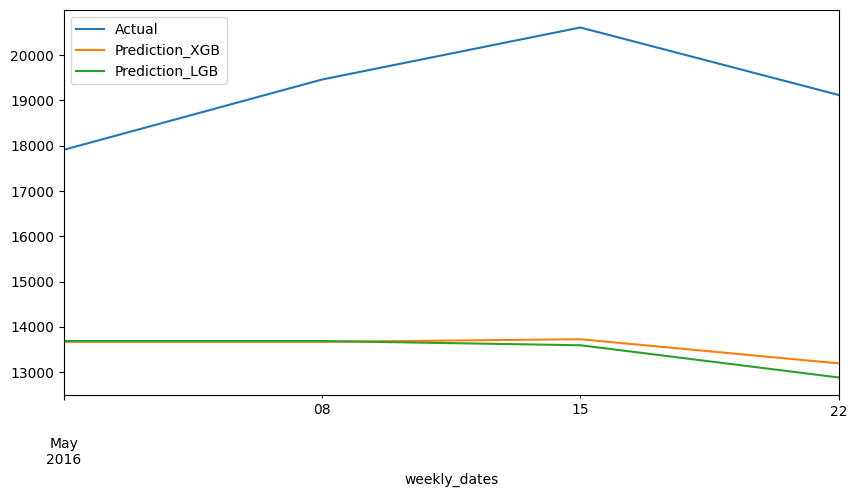

RMSSE XGB:
3.690360094127538
RMSSE LGB:
3.7620555686478325


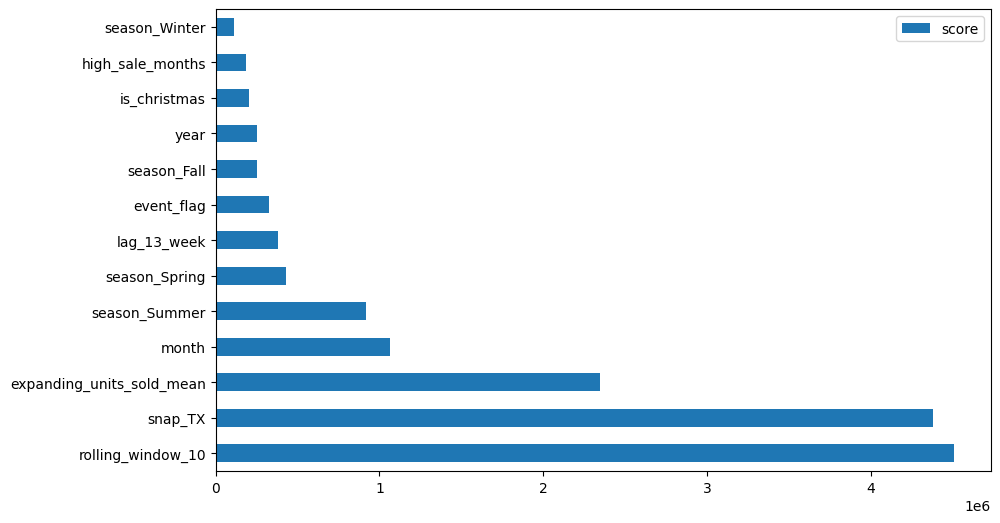

[0]	validation_0-rmse:956.38352
[1]	validation_0-rmse:926.92162
[2]	validation_0-rmse:898.62646
[3]	validation_0-rmse:871.45250
[4]	validation_0-rmse:845.35576
[5]	validation_0-rmse:820.29422
[6]	validation_0-rmse:796.22732
[7]	validation_0-rmse:773.11620
[8]	validation_0-rmse:769.59195
[9]	validation_0-rmse:748.25208
[10]	validation_0-rmse:745.02525
[11]	validation_0-rmse:741.86325
[12]	validation_0-rmse:722.92172
[13]	validation_0-rmse:720.02478
[14]	validation_0-rmse:717.18608
[15]	validation_0-rmse:700.34093
[16]	validation_0-rmse:697.61620
[17]	validation_0-rmse:694.94627
[18]	validation_0-rmse:680.93013
[19]	validation_0-rmse:667.36891
[20]	validation_0-rmse:652.23325
[21]	validation_0-rmse:635.85651
[22]	validation_0-rmse:620.07274
[23]	validation_0-rmse:621.19524
[24]	validation_0-rmse:621.76806
[25]	validation_0-rmse:624.79519
[26]	validation_0-rmse:630.40551
[27]	validation_0-rmse:631.69425
[28]	validation_0-rmse:633.93488
[29]	validation_0-rmse:635.55534
[30]	validation_0-rm

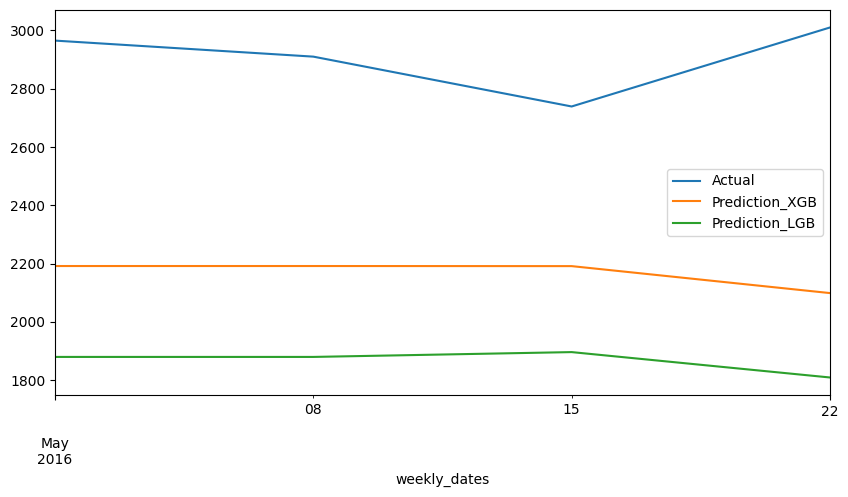

RMSSE XGB:
3.8295575993385906
RMSSE LGB:
5.356451522432464


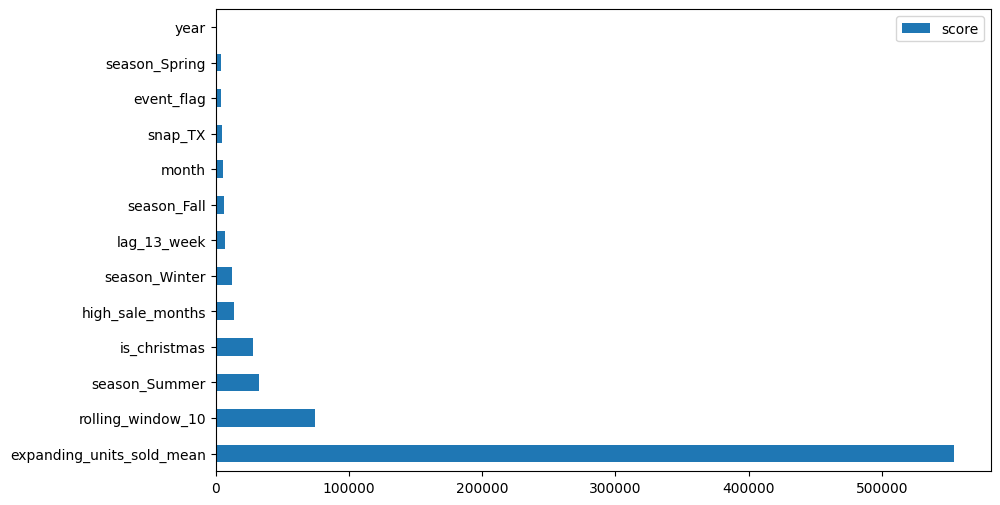

[0]	validation_0-rmse:1902.59029
[1]	validation_0-rmse:1926.62508
[2]	validation_0-rmse:1949.79797
[3]	validation_0-rmse:1972.13992
[4]	validation_0-rmse:1993.68063
[5]	validation_0-rmse:2014.44834
[6]	validation_0-rmse:2034.47077
[7]	validation_0-rmse:2053.77442
[8]	validation_0-rmse:2072.38510
[9]	validation_0-rmse:2090.32746
[10]	validation_0-rmse:2107.62541
[11]	validation_0-rmse:2124.30212
[12]	validation_0-rmse:2128.74733
[13]	validation_0-rmse:2133.10323
[14]	validation_0-rmse:2137.37229
[15]	validation_0-rmse:2141.55589
[16]	validation_0-rmse:2155.35297
[17]	validation_0-rmse:2159.17743
[18]	validation_0-rmse:2162.92568
[19]	validation_0-rmse:2189.63420
[20]	validation_0-rmse:2201.03463
[21]	validation_0-rmse:2239.35247
[22]	validation_0-rmse:2278.32589
[23]	validation_0-rmse:2303.72438
[24]	validation_0-rmse:2313.62981
[25]	validation_0-rmse:2348.38740
[26]	validation_0-rmse:2373.96849
[27]	validation_0-rmse:2395.85457
[28]	validation_0-rmse:2416.93419
[29]	validation_0-rmse:2

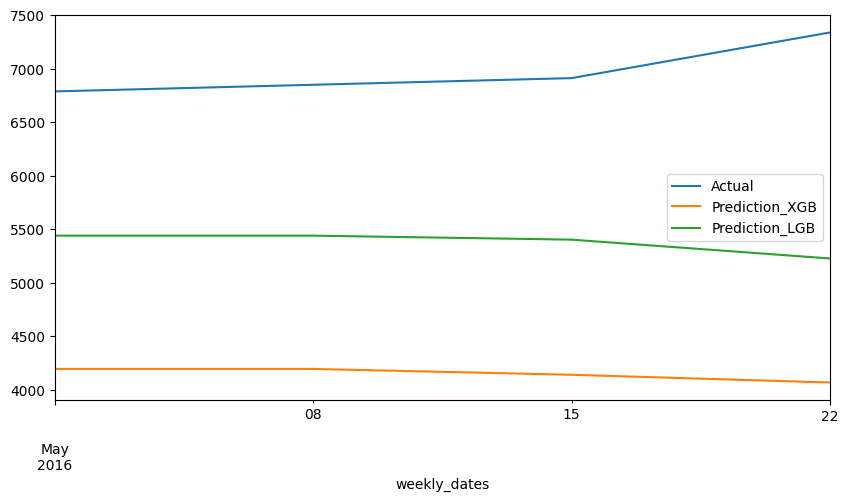

RMSSE XGB:
5.759185986654672
RMSSE LGB:
3.2974516275082077


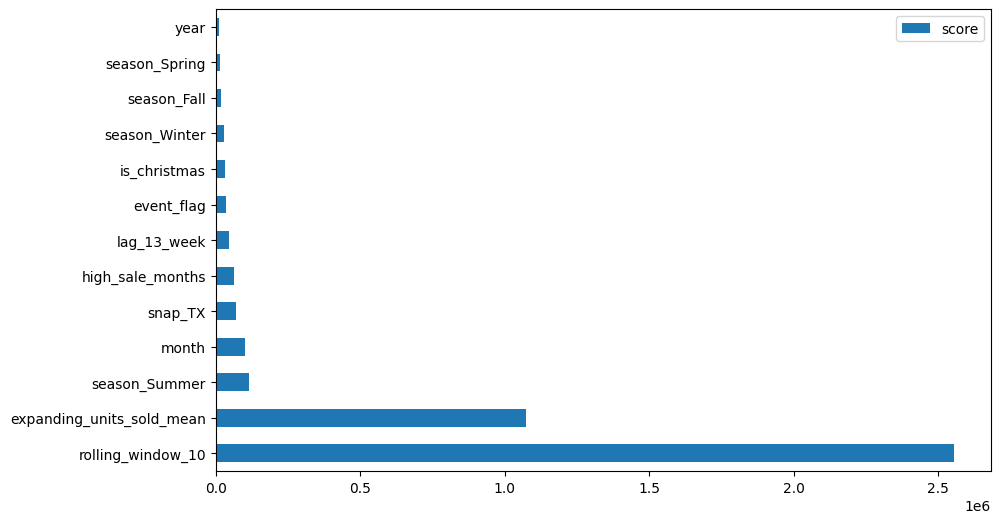

[0]	validation_0-rmse:7173.66308
[1]	validation_0-rmse:7112.97378
[2]	validation_0-rmse:7052.45340
[3]	validation_0-rmse:6998.94156
[4]	validation_0-rmse:6955.18677
[5]	validation_0-rmse:6902.62906
[6]	validation_0-rmse:6861.96561
[7]	validation_0-rmse:6833.69512
[8]	validation_0-rmse:6806.28357
[9]	validation_0-rmse:6766.86648
[10]	validation_0-rmse:6728.89463
[11]	validation_0-rmse:6589.53784
[12]	validation_0-rmse:6546.11106
[13]	validation_0-rmse:6523.99172
[14]	validation_0-rmse:6483.51313
[15]	validation_0-rmse:6471.58721
[16]	validation_0-rmse:6399.05196
[17]	validation_0-rmse:6388.51313
[18]	validation_0-rmse:6378.29150
[19]	validation_0-rmse:6345.42765
[20]	validation_0-rmse:6317.90962
[21]	validation_0-rmse:6309.39161
[22]	validation_0-rmse:6274.72856
[23]	validation_0-rmse:6250.77511
[24]	validation_0-rmse:6162.38623
[25]	validation_0-rmse:6128.87249
[26]	validation_0-rmse:6096.51044
[27]	validation_0-rmse:6080.48304
[28]	validation_0-rmse:6052.69386
[29]	validation_0-rmse:6

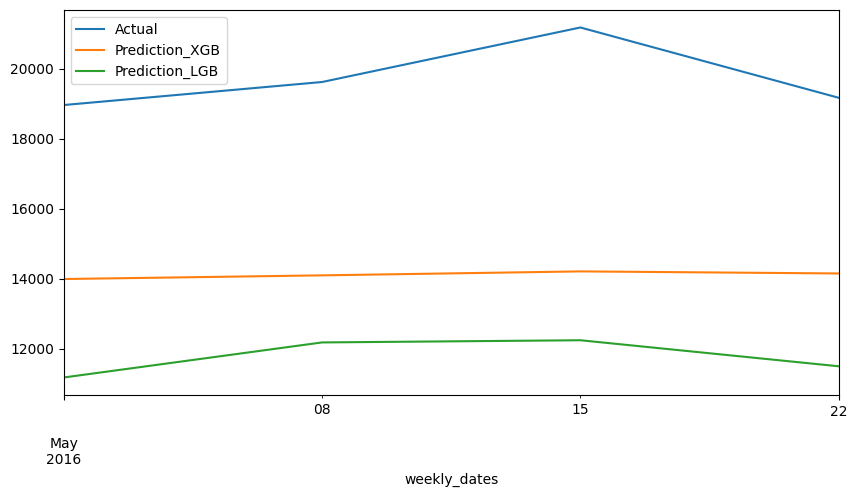

RMSSE XGB:
5.054967100015199
RMSSE LGB:
7.102653634345703


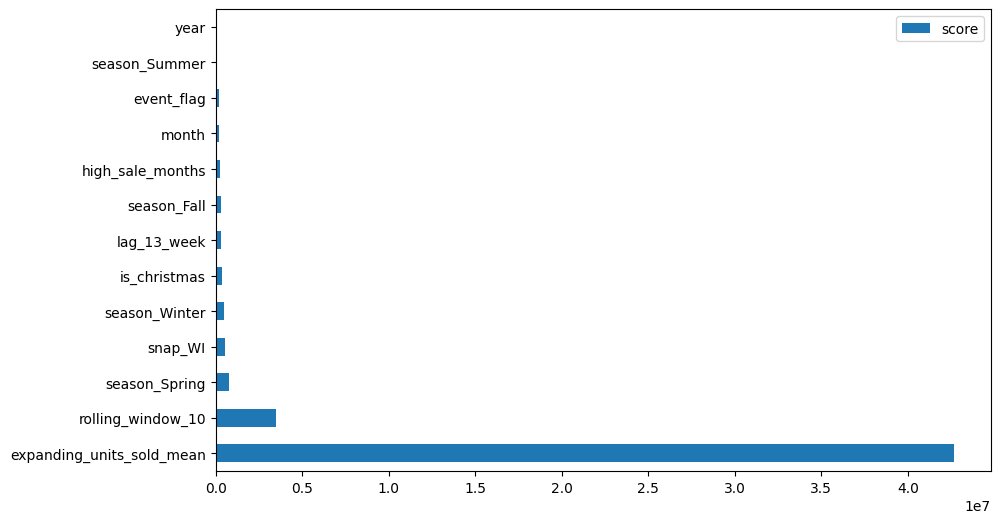

[0]	validation_0-rmse:640.15513
[1]	validation_0-rmse:654.93066
[2]	validation_0-rmse:665.90114
[3]	validation_0-rmse:676.88132
[4]	validation_0-rmse:680.66086
[5]	validation_0-rmse:679.17359
[6]	validation_0-rmse:677.73919
[7]	validation_0-rmse:676.35597
[8]	validation_0-rmse:675.02200
[9]	validation_0-rmse:673.73560
[10]	validation_0-rmse:672.49507
[11]	validation_0-rmse:671.29873
[12]	validation_0-rmse:675.13495
[13]	validation_0-rmse:672.40403
[14]	validation_0-rmse:676.05774
[15]	validation_0-rmse:674.73646
[16]	validation_0-rmse:678.22301
[17]	validation_0-rmse:676.87479
[18]	validation_0-rmse:675.44604
[19]	validation_0-rmse:677.35664
[20]	validation_0-rmse:679.19519
[21]	validation_0-rmse:680.45913
[22]	validation_0-rmse:678.81514
[23]	validation_0-rmse:680.41340
[24]	validation_0-rmse:681.95148
[25]	validation_0-rmse:680.16851
[26]	validation_0-rmse:681.55287
[27]	validation_0-rmse:679.50511
[28]	validation_0-rmse:680.24877
[29]	validation_0-rmse:678.37905
[30]	validation_0-rm

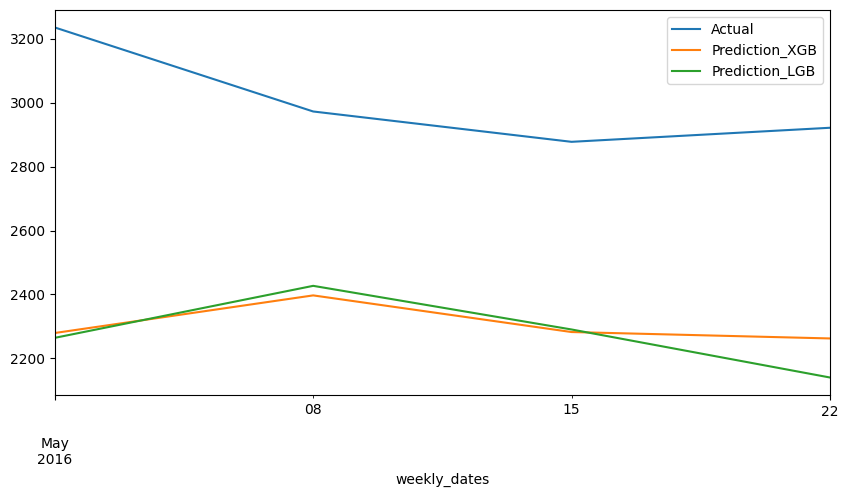

RMSSE XGB:
2.4690265532396882
RMSSE LGB:
2.565551274842802


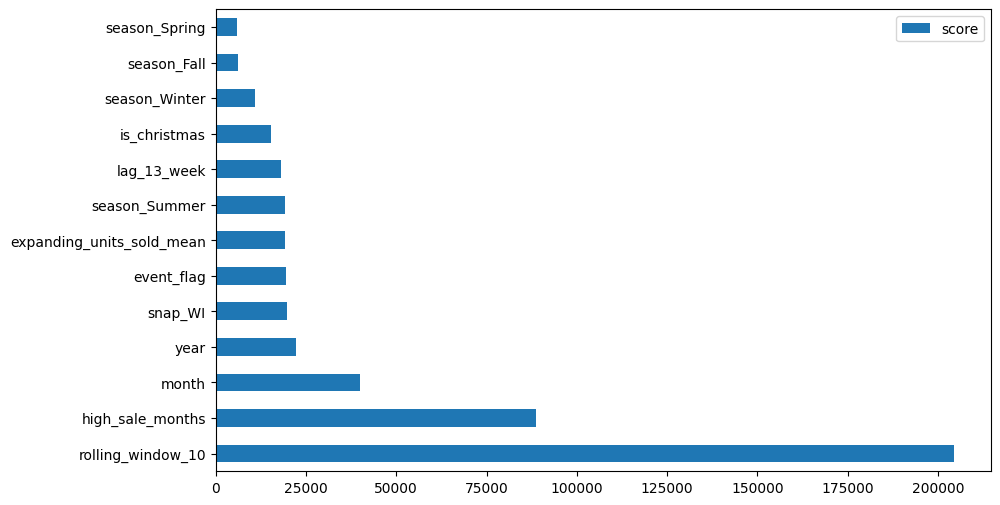

[0]	validation_0-rmse:1487.73558
[1]	validation_0-rmse:1440.48624
[2]	validation_0-rmse:1394.61791
[3]	validation_0-rmse:1351.05849
[4]	validation_0-rmse:1308.76639
[5]	validation_0-rmse:1268.36270
[6]	validation_0-rmse:1229.38352
[7]	validation_0-rmse:1192.59698
[8]	validation_0-rmse:1156.65896
[9]	validation_0-rmse:1122.54496
[10]	validation_0-rmse:1089.63284
[11]	validation_0-rmse:1061.89191
[12]	validation_0-rmse:1035.25734
[13]	validation_0-rmse:1009.68634
[14]	validation_0-rmse:980.96874
[15]	validation_0-rmse:953.41221
[16]	validation_0-rmse:930.53808
[17]	validation_0-rmse:908.95701
[18]	validation_0-rmse:884.50986
[19]	validation_0-rmse:863.67698
[20]	validation_0-rmse:845.40573
[21]	validation_0-rmse:826.58045
[22]	validation_0-rmse:809.72233
[23]	validation_0-rmse:791.94078
[24]	validation_0-rmse:776.37155
[25]	validation_0-rmse:761.41767
[26]	validation_0-rmse:744.63340
[27]	validation_0-rmse:736.25740
[28]	validation_0-rmse:723.85946
[29]	validation_0-rmse:709.88914
[30]	v

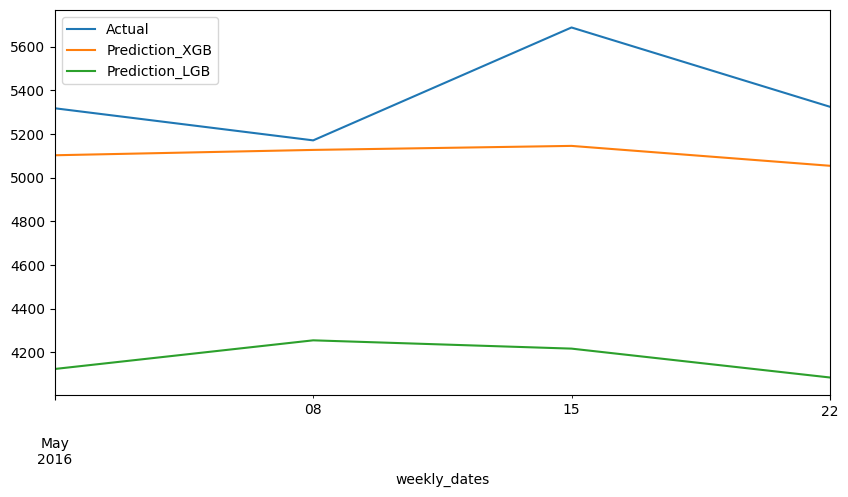

RMSSE XGB:
0.8621002853655014
RMSSE LGB:
3.2667432388153164


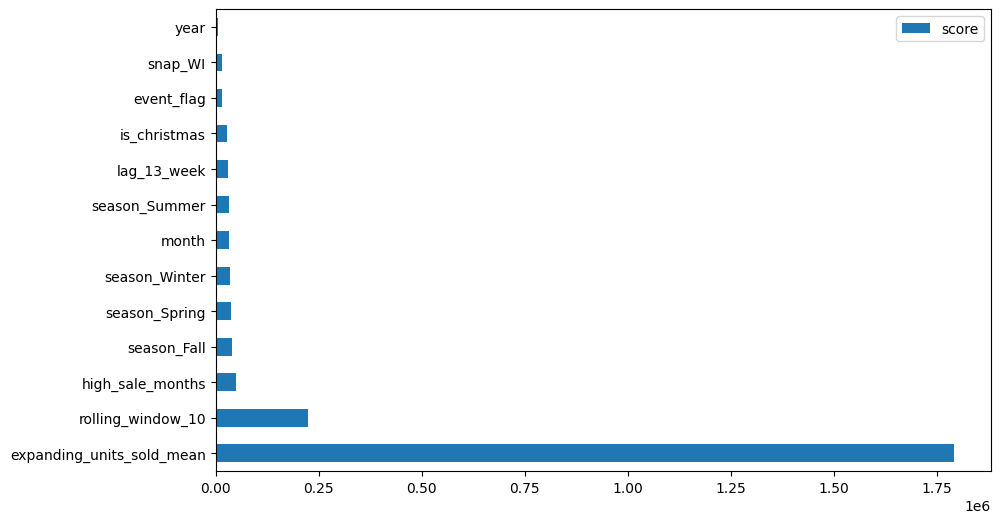

[0]	validation_0-rmse:12419.84219
[1]	validation_0-rmse:12472.19648
[2]	validation_0-rmse:12523.55227
[3]	validation_0-rmse:12573.92697
[4]	validation_0-rmse:12623.33837
[5]	validation_0-rmse:12671.80305
[6]	validation_0-rmse:12719.33933
[7]	validation_0-rmse:12765.96166
[8]	validation_0-rmse:12811.68732
[9]	validation_0-rmse:12856.53260
[10]	validation_0-rmse:13076.72780
[11]	validation_0-rmse:13174.08354
[12]	validation_0-rmse:13379.70803
[13]	validation_0-rmse:13427.40407
[14]	validation_0-rmse:13618.50150
[15]	validation_0-rmse:13750.64544
[16]	validation_0-rmse:13793.03618
[17]	validation_0-rmse:13955.74753
[18]	validation_0-rmse:14073.36744
[19]	validation_0-rmse:14234.75223
[20]	validation_0-rmse:14283.52803
[21]	validation_0-rmse:14331.12867
[22]	validation_0-rmse:14465.86299
[23]	validation_0-rmse:14612.20285
[24]	validation_0-rmse:14654.37651
[25]	validation_0-rmse:14780.26262
[26]	validation_0-rmse:14819.81795
[27]	validation_0-rmse:14946.44423
[28]	validation_0-rmse:15015.6

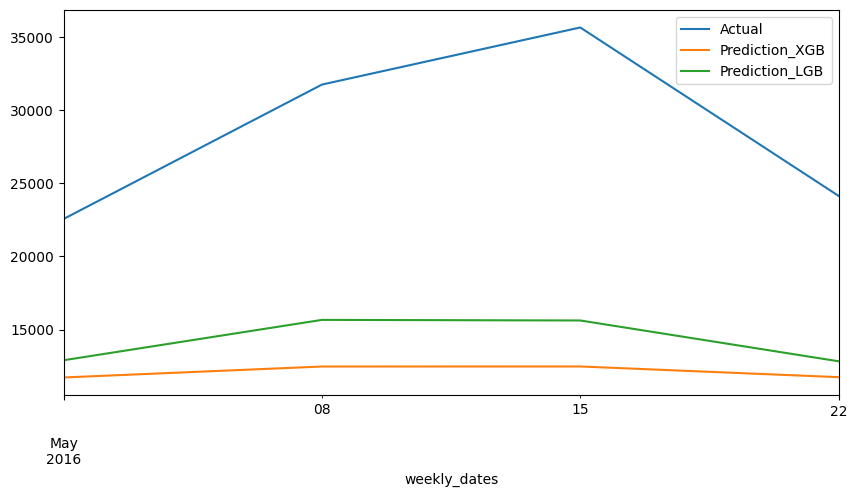

RMSSE XGB:
4.2648669008735105
RMSSE LGB:
3.686060711652851


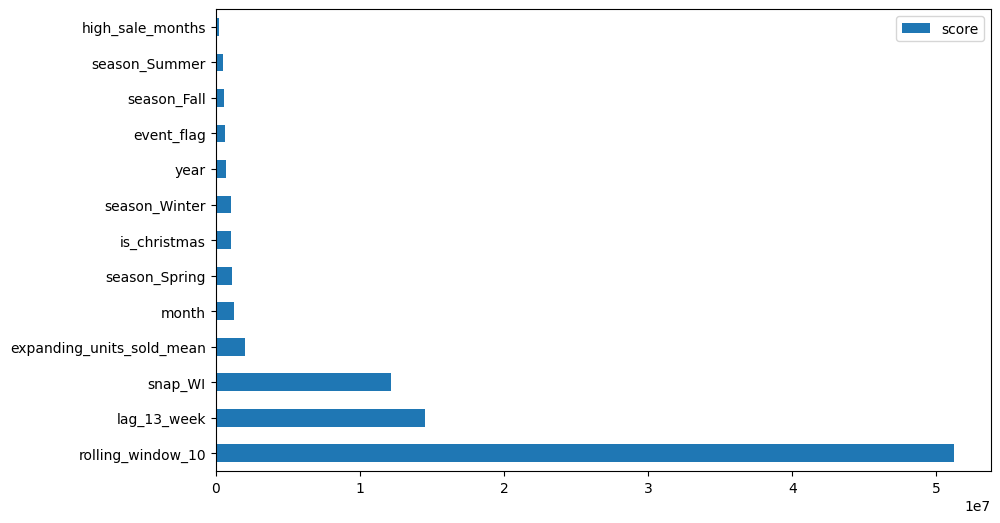

[0]	validation_0-rmse:739.79374
[1]	validation_0-rmse:742.50095
[2]	validation_0-rmse:731.87084
[3]	validation_0-rmse:734.60536
[4]	validation_0-rmse:737.28519
[5]	validation_0-rmse:727.60017
[6]	validation_0-rmse:730.29784
[7]	validation_0-rmse:721.21031
[8]	validation_0-rmse:720.47502
[9]	validation_0-rmse:719.76427
[10]	validation_0-rmse:715.43545
[11]	validation_0-rmse:711.19336
[12]	validation_0-rmse:707.03615
[13]	validation_0-rmse:702.96223
[14]	validation_0-rmse:698.96990
[15]	validation_0-rmse:691.73043
[16]	validation_0-rmse:687.89649
[17]	validation_0-rmse:684.13935
[18]	validation_0-rmse:677.44289
[19]	validation_0-rmse:674.00461
[20]	validation_0-rmse:672.14667
[21]	validation_0-rmse:670.32590
[22]	validation_0-rmse:667.24579
[23]	validation_0-rmse:668.16809
[24]	validation_0-rmse:660.90363
[25]	validation_0-rmse:658.13960
[26]	validation_0-rmse:655.43089
[27]	validation_0-rmse:646.56842
[28]	validation_0-rmse:642.92629
[29]	validation_0-rmse:645.02596
[30]	validation_0-rm

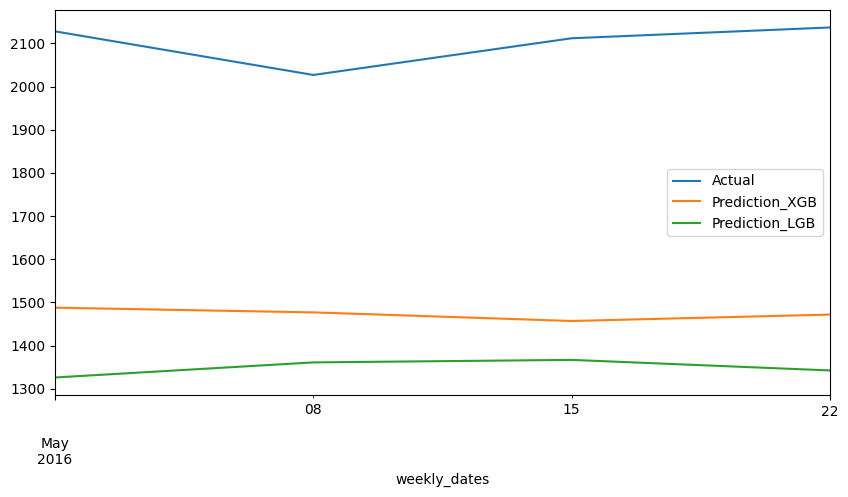

RMSSE XGB:
3.207576363512
RMSSE LGB:
3.8426151047354105


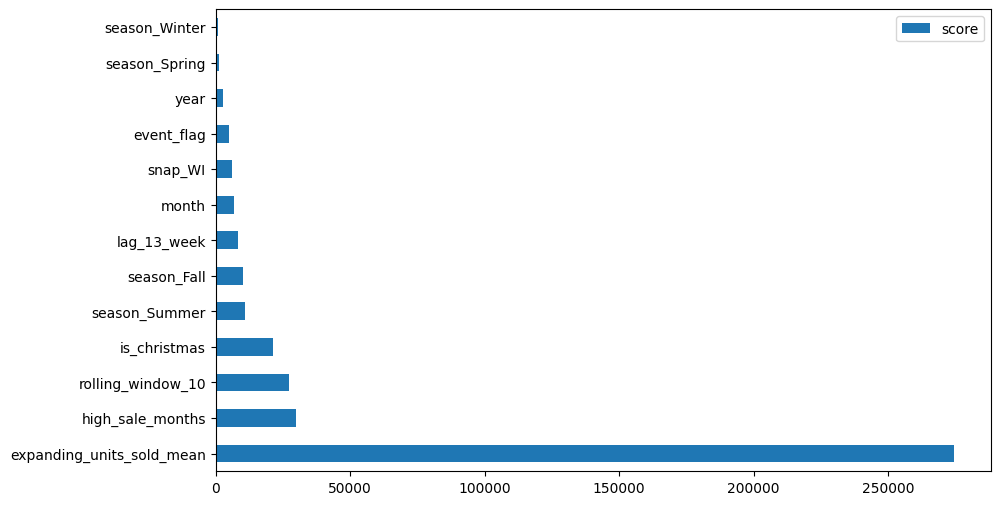

[0]	validation_0-rmse:2731.18672
[1]	validation_0-rmse:2613.87739
[2]	validation_0-rmse:2601.72993
[3]	validation_0-rmse:2593.91726
[4]	validation_0-rmse:2588.96488
[5]	validation_0-rmse:2581.66424
[6]	validation_0-rmse:2581.46056
[7]	validation_0-rmse:2574.81482
[8]	validation_0-rmse:2560.12209
[9]	validation_0-rmse:2560.06755
[10]	validation_0-rmse:2543.17285
[11]	validation_0-rmse:2535.12224
[12]	validation_0-rmse:2545.56646
[13]	validation_0-rmse:2533.20207
[14]	validation_0-rmse:2521.86367
[15]	validation_0-rmse:2510.88879
[16]	validation_0-rmse:2500.26514
[17]	validation_0-rmse:2489.98210
[18]	validation_0-rmse:2476.59666
[19]	validation_0-rmse:2492.37475
[20]	validation_0-rmse:2509.39253
[21]	validation_0-rmse:2525.86666
[22]	validation_0-rmse:2541.81446
[23]	validation_0-rmse:2557.25290
[24]	validation_0-rmse:2572.19833
[25]	validation_0-rmse:2586.66629
[26]	validation_0-rmse:2600.67169
[27]	validation_0-rmse:2638.21182
[28]	validation_0-rmse:2674.28042
[29]	validation_0-rmse:2

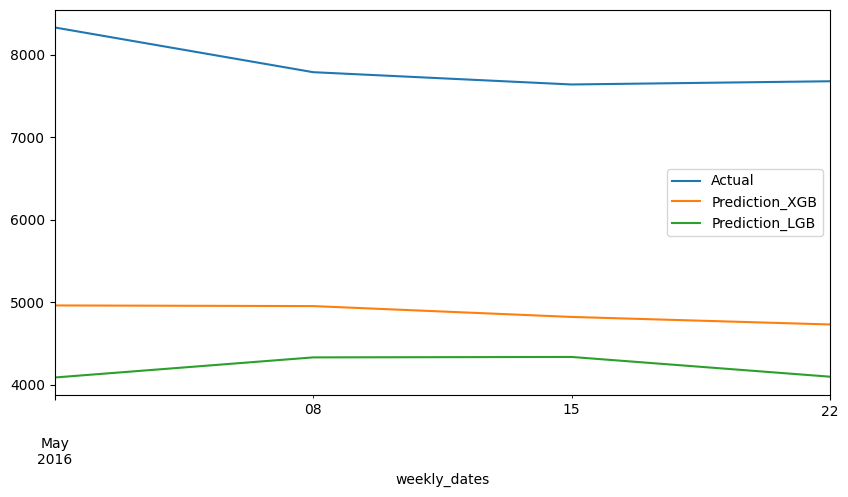

RMSSE XGB:
3.332380049705214
RMSSE LGB:
4.0680718658202855


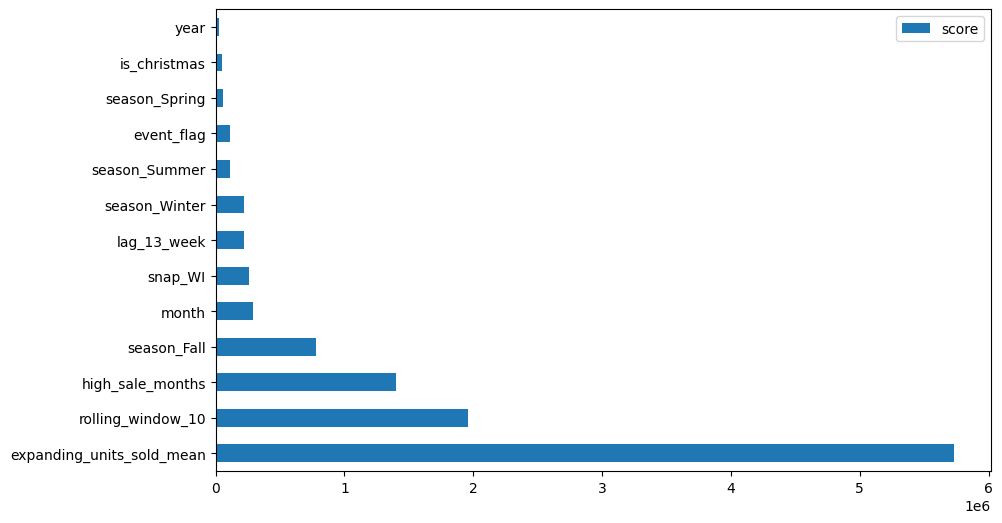

[0]	validation_0-rmse:4637.63165
[1]	validation_0-rmse:4721.75000
[2]	validation_0-rmse:4807.31076
[3]	validation_0-rmse:4888.71770
[4]	validation_0-rmse:4993.42887
[5]	validation_0-rmse:5093.95238
[6]	validation_0-rmse:5194.47370
[7]	validation_0-rmse:5231.78905
[8]	validation_0-rmse:5271.17758
[9]	validation_0-rmse:5364.25392
[10]	validation_0-rmse:5457.62113
[11]	validation_0-rmse:5480.24054
[12]	validation_0-rmse:5488.84577
[13]	validation_0-rmse:5560.47352
[14]	validation_0-rmse:5622.36502
[15]	validation_0-rmse:5630.67294
[16]	validation_0-rmse:5688.61007
[17]	validation_0-rmse:5744.61557
[18]	validation_0-rmse:5751.90717
[19]	validation_0-rmse:5804.34119
[20]	validation_0-rmse:5855.02717
[21]	validation_0-rmse:5861.41105
[22]	validation_0-rmse:5908.87131
[23]	validation_0-rmse:5954.75061
[24]	validation_0-rmse:5979.39262
[25]	validation_0-rmse:5999.96511
[26]	validation_0-rmse:6013.50718
[27]	validation_0-rmse:6025.43799
[28]	validation_0-rmse:6036.01331
[29]	validation_0-rmse:6

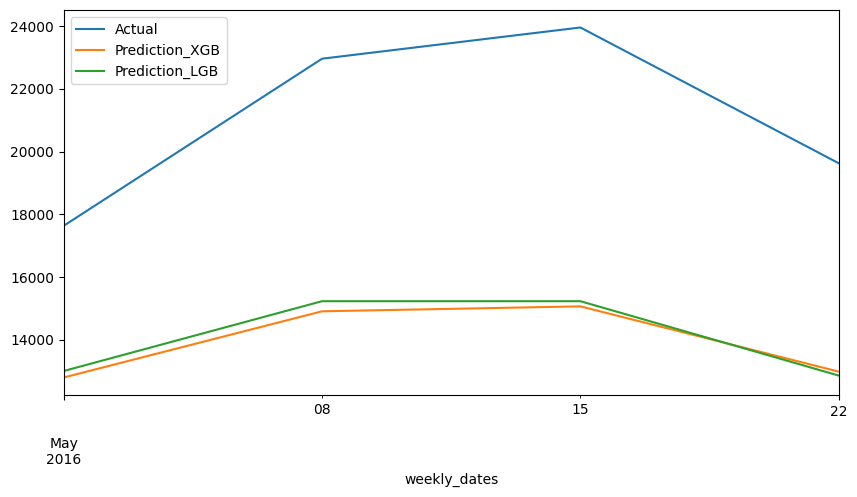

RMSSE XGB:
2.2813777630875665
RMSSE LGB:
2.236373907379878


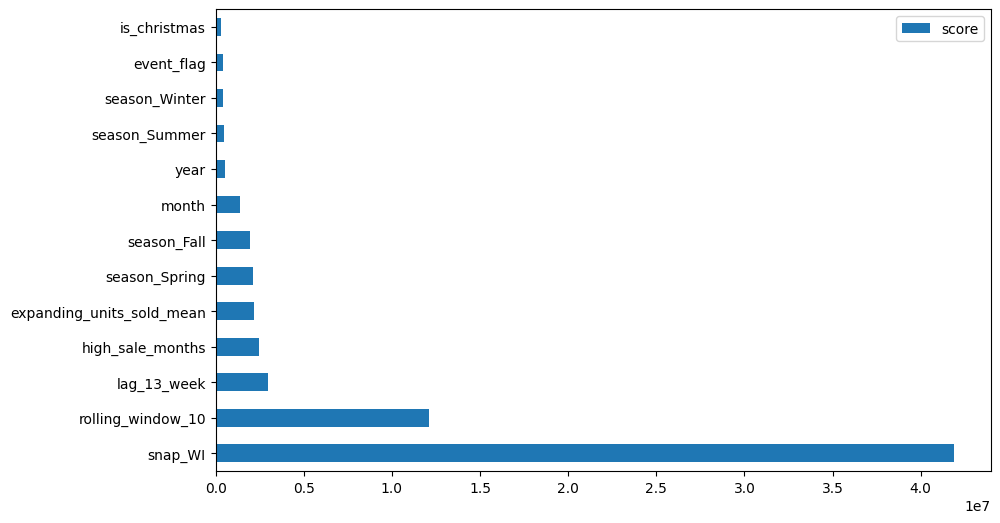

[0]	validation_0-rmse:306.48462
[1]	validation_0-rmse:308.87033
[2]	validation_0-rmse:311.21087
[3]	validation_0-rmse:313.50707
[4]	validation_0-rmse:315.75953
[5]	validation_0-rmse:317.96910
[6]	validation_0-rmse:320.13642
[7]	validation_0-rmse:328.63789
[8]	validation_0-rmse:336.87387
[9]	validation_0-rmse:345.38390
[10]	validation_0-rmse:354.98465
[11]	validation_0-rmse:364.29119
[12]	validation_0-rmse:373.30980
[13]	validation_0-rmse:382.04730
[14]	validation_0-rmse:378.79844
[15]	validation_0-rmse:375.65595
[16]	validation_0-rmse:372.61626
[17]	validation_0-rmse:379.09538
[18]	validation_0-rmse:377.48398
[19]	validation_0-rmse:383.29639
[20]	validation_0-rmse:381.79605
[21]	validation_0-rmse:387.23631
[22]	validation_0-rmse:392.57083
[23]	validation_0-rmse:396.50258
[24]	validation_0-rmse:400.21397
[25]	validation_0-rmse:403.84084
[26]	validation_0-rmse:407.33553
[27]	validation_0-rmse:410.60203
[28]	validation_0-rmse:407.95705
[29]	validation_0-rmse:406.50478
[30]	validation_0-rm

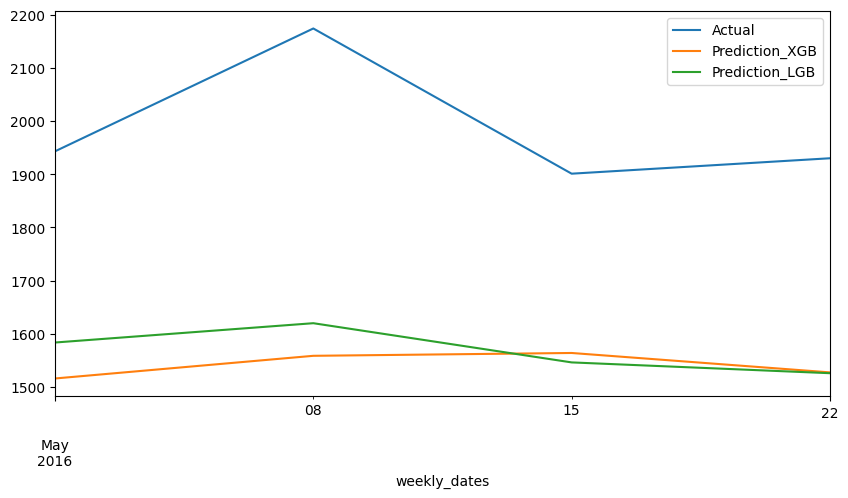

RMSSE XGB:
2.0388771616114845
RMSSE LGB:
1.8983520376545353


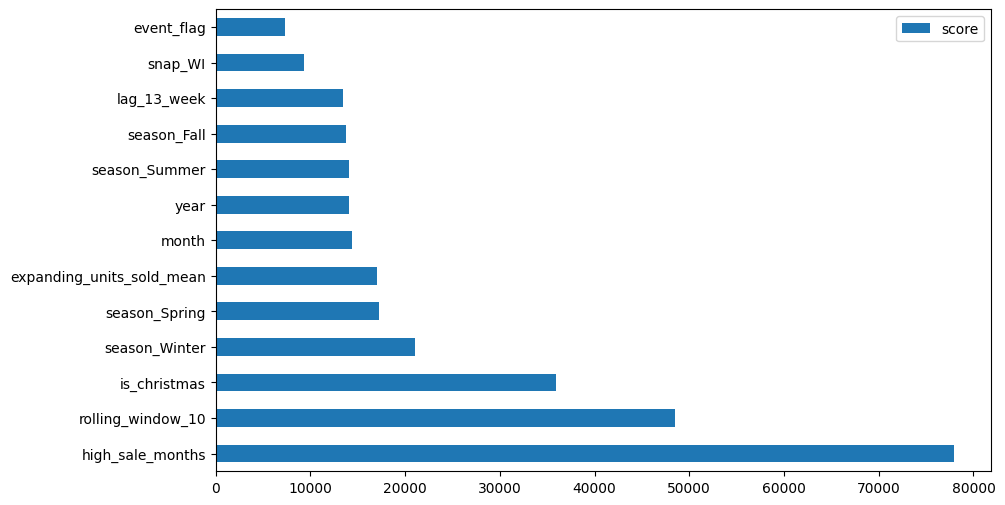

[0]	validation_0-rmse:1186.51001
[1]	validation_0-rmse:1217.66633
[2]	validation_0-rmse:1247.66065
[3]	validation_0-rmse:1276.53618
[4]	validation_0-rmse:1304.33472
[5]	validation_0-rmse:1336.31840
[6]	validation_0-rmse:1362.21781
[7]	validation_0-rmse:1387.15103
[8]	validation_0-rmse:1414.17576
[9]	validation_0-rmse:1437.41339
[10]	validation_0-rmse:1459.78412
[11]	validation_0-rmse:1473.26131
[12]	validation_0-rmse:1497.97861
[13]	validation_0-rmse:1521.74271
[14]	validation_0-rmse:1533.52245
[15]	validation_0-rmse:1555.60647
[16]	validation_0-rmse:1576.83893
[17]	validation_0-rmse:1589.95623
[18]	validation_0-rmse:1607.35546
[19]	validation_0-rmse:1622.63549
[20]	validation_0-rmse:1641.14040
[21]	validation_0-rmse:1656.76277
[22]	validation_0-rmse:1672.39690
[23]	validation_0-rmse:1686.90578
[24]	validation_0-rmse:1702.51318
[25]	validation_0-rmse:1707.69322
[26]	validation_0-rmse:1722.37233
[27]	validation_0-rmse:1736.99129
[28]	validation_0-rmse:1743.29037
[29]	validation_0-rmse:1

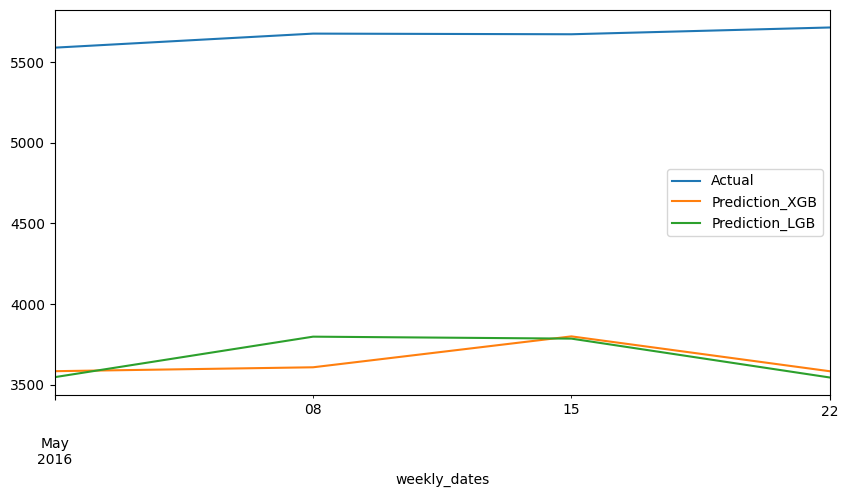

RMSSE XGB:
3.7435049024540055
RMSSE LGB:
3.6996476925822463


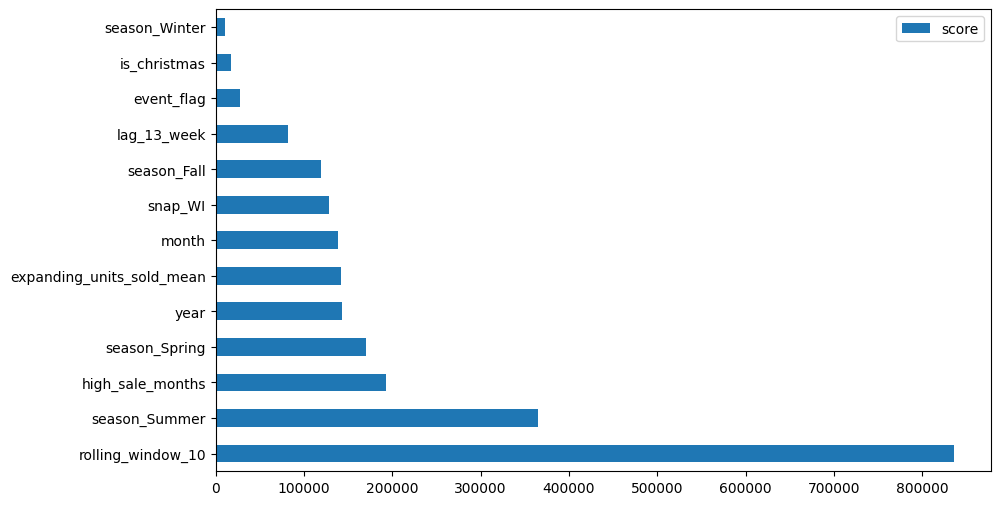

In [ ]:
# ML Models at Store and Category level with rmsse values
rmsse_xgb_values = []
rmsse_lgb_values = []
rmsse_xgb_storecat,rmsse_lgb_storecat = train_and_validate_models(train_store_cat,val_store_cat,'store_id','cat_id',rmsse_xgb_values,rmsse_lgb_values)
rmsse_lgb['Store and category'] = round(np.mean(rmsse_xgb_storecat),3)
rmsse_xgb['Store and category'] = round(np.mean(rmsse_lgb_storecat),3)
del rmsse_xgb_values,rmsse_lgb_values,rmsse_xgb_storecat,rmsse_lgb_storecat

## Aggregation Level : State

In [ ]:
rmsse_lgb

{'State and category': 4.334,
 'State and deparment': 4.315,
 'Store and category': 4.632}

In [ ]:
"""
Aggregation Level : State
Function agg_data: Aggregate of train and val at higher level,
                   including date features
Function price_agg: Aggregation of sell price at dynamic level

"""
groupby_state = ['state_id']

train_state = agg_data(train,groupby_state)
days_train = train_state['d'].unique().tolist()
val_state = val[~(val['d'].isin(days_train))]
val_state = agg_data(val_state,groupby_state)
del days_train

# Price state level
price_state = price_agg(price,['state_id'])

# Function call to resample daily data to weekly
train_state = resample_daily_to_weekly(train_state,['state_id'])
val_state = resample_daily_to_weekly(val_state,['state_id'])

# Merge of train and val dataframes with price features
train_state = train_state.merge(price_state,on=['state_id']).drop_duplicates()
val_state = val_state.merge(price_state,on=['state_id']).drop_duplicates()

[0]	validation_0-rmse:26890.52517
[1]	validation_0-rmse:27913.32241
[2]	validation_0-rmse:28896.82280
[3]	validation_0-rmse:29842.48542
[4]	validation_0-rmse:30760.01977
[5]	validation_0-rmse:31642.20169
[6]	validation_0-rmse:32430.64230
[7]	validation_0-rmse:33188.67253
[8]	validation_0-rmse:33917.44401
[9]	validation_0-rmse:34618.07528
[10]	validation_0-rmse:35332.42228
[11]	validation_0-rmse:36026.97323
[12]	validation_0-rmse:36650.25621
[13]	validation_0-rmse:37294.37191
[14]	validation_0-rmse:37913.83241
[15]	validation_0-rmse:38509.57491
[16]	validation_0-rmse:39044.03135
[17]	validation_0-rmse:39596.47904
[18]	validation_0-rmse:40127.75957
[19]	validation_0-rmse:40638.67557
[20]	validation_0-rmse:41122.26531
[21]	validation_0-rmse:41595.05971
[22]	validation_0-rmse:42042.44103
[23]	validation_0-rmse:42459.19340
[24]	validation_0-rmse:42860.02259
[25]	validation_0-rmse:43246.33626
[26]	validation_0-rmse:43695.31490
[27]	validation_0-rmse:44053.15262
[28]	validation_0-rmse:44448.6

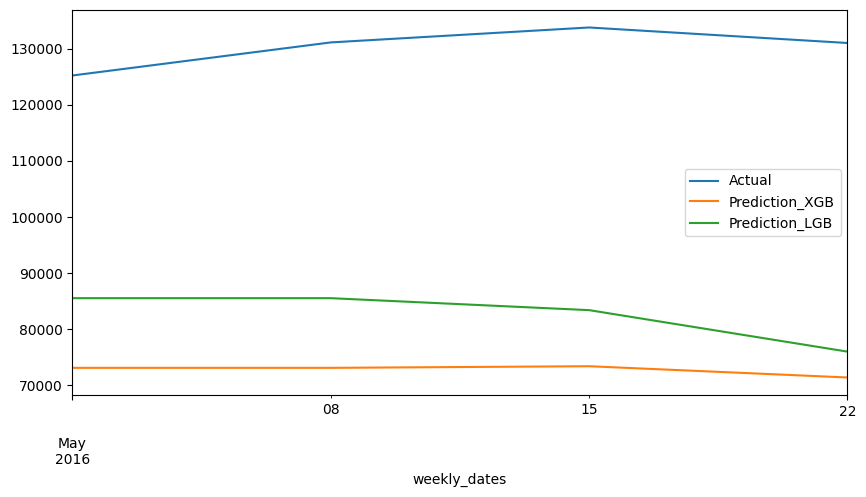

RMSSE XGB:
7.494894677889727
RMSSE LGB:
6.244277640326988


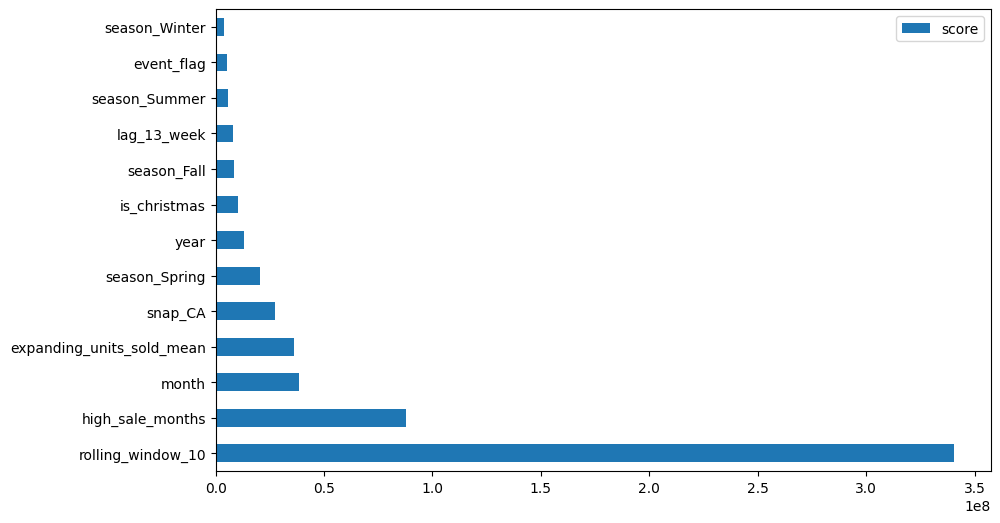

[0]	validation_0-rmse:14378.87117
[1]	validation_0-rmse:15033.66941
[2]	validation_0-rmse:15714.42802
[3]	validation_0-rmse:16370.49822
[4]	validation_0-rmse:17002.62780
[5]	validation_0-rmse:17522.30887
[6]	validation_0-rmse:18034.52012
[7]	validation_0-rmse:18528.63816
[8]	validation_0-rmse:18966.39860
[9]	validation_0-rmse:19402.19503
[10]	validation_0-rmse:19821.55433
[11]	validation_0-rmse:20225.07493
[12]	validation_0-rmse:20613.33646
[13]	validation_0-rmse:20986.90315
[14]	validation_0-rmse:21374.40394
[15]	validation_0-rmse:21747.57954
[16]	validation_0-rmse:22105.62951
[17]	validation_0-rmse:22451.73668
[18]	validation_0-rmse:22762.86731
[19]	validation_0-rmse:22900.79440
[20]	validation_0-rmse:23035.05850
[21]	validation_0-rmse:23334.09540
[22]	validation_0-rmse:23456.84906
[23]	validation_0-rmse:23749.37220
[24]	validation_0-rmse:23862.90125
[25]	validation_0-rmse:23973.40944
[26]	validation_0-rmse:24202.37922
[27]	validation_0-rmse:24473.67729
[28]	validation_0-rmse:24570.3

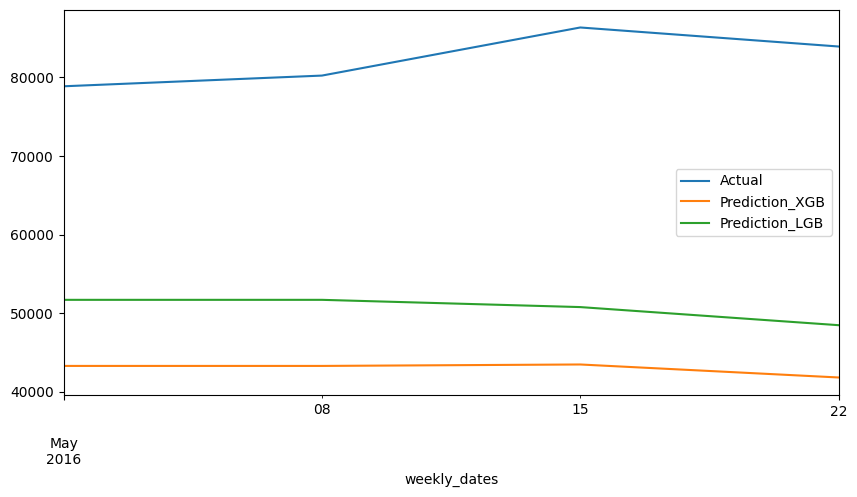

RMSSE XGB:
7.237356256153917
RMSSE LGB:
5.847557480817623


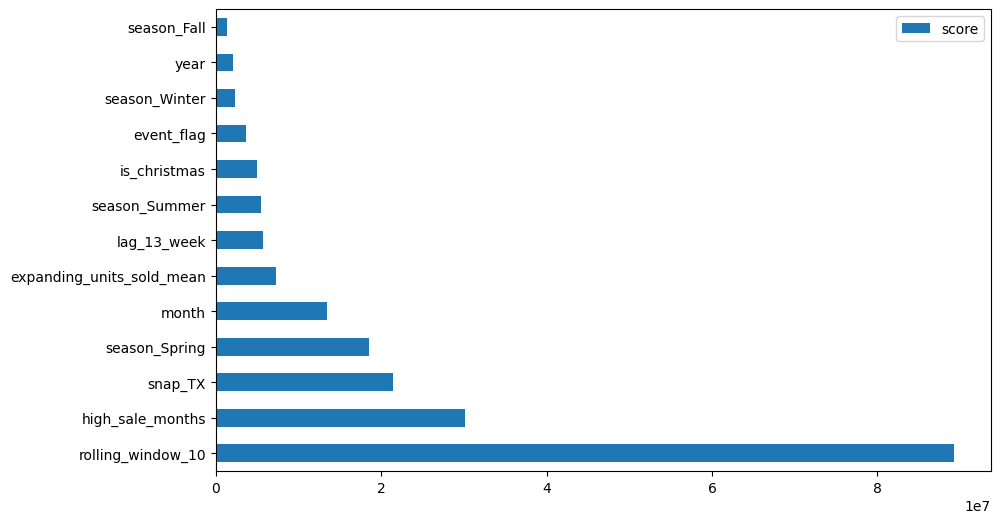

[0]	validation_0-rmse:30855.78558
[1]	validation_0-rmse:31325.18016
[2]	validation_0-rmse:31786.87905
[3]	validation_0-rmse:32240.17171
[4]	validation_0-rmse:32939.08414
[5]	validation_0-rmse:33366.79259
[6]	validation_0-rmse:34026.83341
[7]	validation_0-rmse:34468.26088
[8]	validation_0-rmse:34897.94309
[9]	validation_0-rmse:35297.62168
[10]	validation_0-rmse:35704.34528
[11]	validation_0-rmse:36063.85847
[12]	validation_0-rmse:36446.12923
[13]	validation_0-rmse:36934.07662
[14]	validation_0-rmse:37308.77752
[15]	validation_0-rmse:37672.58420
[16]	validation_0-rmse:38025.66502
[17]	validation_0-rmse:38368.20559
[18]	validation_0-rmse:38700.40413
[19]	validation_0-rmse:39022.47188
[20]	validation_0-rmse:39334.62759
[21]	validation_0-rmse:39612.37867
[22]	validation_0-rmse:39751.68605
[23]	validation_0-rmse:39887.28158
[24]	validation_0-rmse:40019.26616
[25]	validation_0-rmse:40448.09335
[26]	validation_0-rmse:40864.51370
[27]	validation_0-rmse:41188.03283
[28]	validation_0-rmse:41298.5

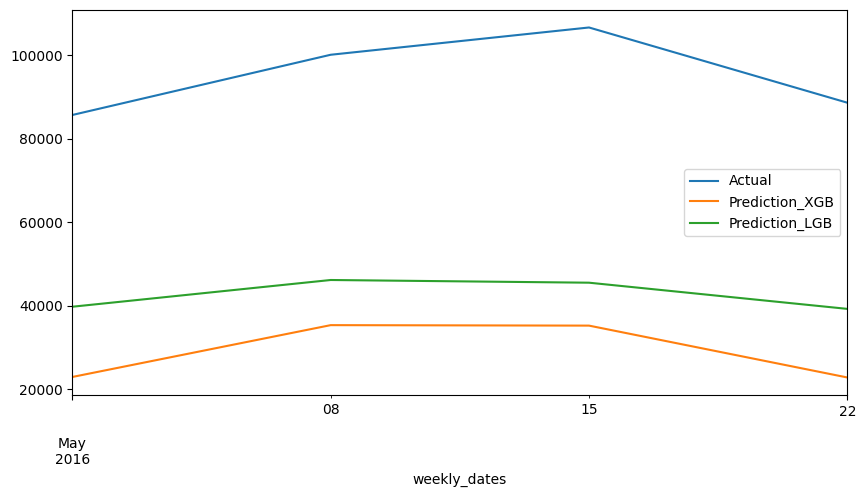

RMSSE XGB:
7.754827245992739
RMSSE LGB:
6.191489378464663


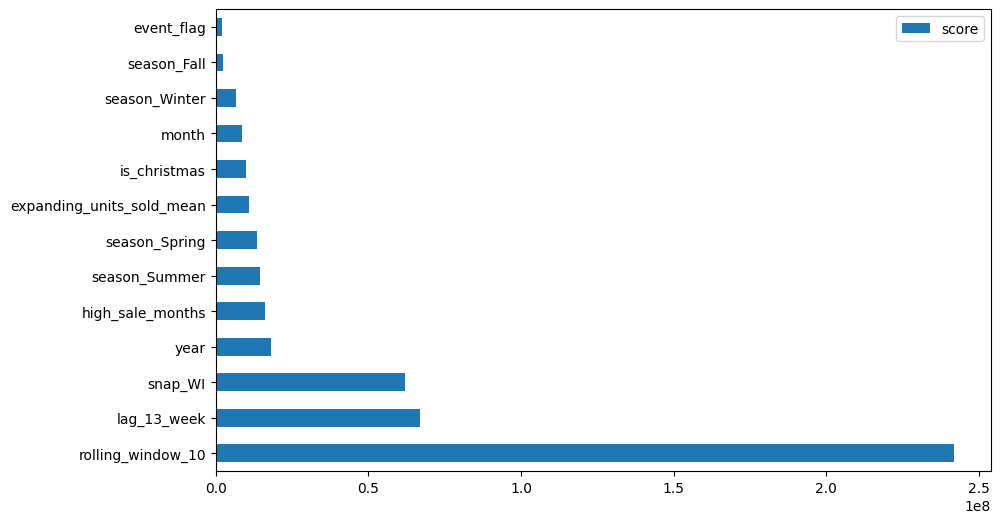

In [ ]:
# ML Models at State level with rmsse values
rmsse_xgb_values = []
rmsse_lgb_values = []
rmsse_xgb_state,rmsse_lgb_state =train_and_validate_models(train_state,val_state,'state_id',rmsse_xgb_values,rmsse_lgb_values)
rmsse_lgb['State'] = round(np.mean(rmsse_xgb_state),3)
rmsse_xgb['State'] = round(np.mean(rmsse_lgb_state),3)
del rmsse_xgb_values,rmsse_lgb_values,rmsse_xgb_state,rmsse_lgb_state


## Aggregation Level: Department

In [ ]:
"""
Aggregation Level : Department
Function agg_data: Aggregate of train and val at higher level,
                   including date features
Function price_agg: Aggregation of sell price at dynamic level

"""
groupby_dept = ['dept_id']

train_dept = agg_data(train,groupby_dept)
days_train = train_dept['d'].unique().tolist()
val_dept = val[~(val['d'].isin(days_train))]
val_dept = agg_data(val_dept,groupby_dept)
del days_train

# Price department level
price_dept = price_agg(price,['dept_id'])

# Function call to resample daily data to weekly
train_dept = resample_daily_to_weekly(train_dept,['dept_id'])
val_dept = resample_daily_to_weekly(val_dept,['dept_id'])

# Merge of train and val dataframes with price features
train_dept = train_dept.merge(price_dept,on=['dept_id']).drop_duplicates()
val_dept = val_dept.merge(price_dept,on=['dept_id']).drop_duplicates()

[0]	validation_0-rmse:7394.92556
[1]	validation_0-rmse:7647.34457
[2]	validation_0-rmse:7890.19562
[3]	validation_0-rmse:8128.30425
[4]	validation_0-rmse:8353.16054
[5]	validation_0-rmse:8573.66614
[6]	validation_0-rmse:8785.76240
[7]	validation_0-rmse:8986.02359
[8]	validation_0-rmse:9182.35351
[9]	validation_0-rmse:9371.16113
[10]	validation_0-rmse:9549.42271
[11]	validation_0-rmse:9599.65760
[12]	validation_0-rmse:9648.89284
[13]	validation_0-rmse:9807.55576
[14]	validation_0-rmse:9852.65213
[15]	validation_0-rmse:10002.19776
[16]	validation_0-rmse:10043.41705
[17]	validation_0-rmse:10083.81426
[18]	validation_0-rmse:10205.03846
[19]	validation_0-rmse:10321.55366
[20]	validation_0-rmse:10443.30570
[21]	validation_0-rmse:10568.19105
[22]	validation_0-rmse:10681.19993
[23]	validation_0-rmse:10708.87594
[24]	validation_0-rmse:10735.99991
[25]	validation_0-rmse:10834.78722
[26]	validation_0-rmse:10908.22974
[27]	validation_0-rmse:10978.92508
[28]	validation_0-rmse:11045.60157
[29]	valid

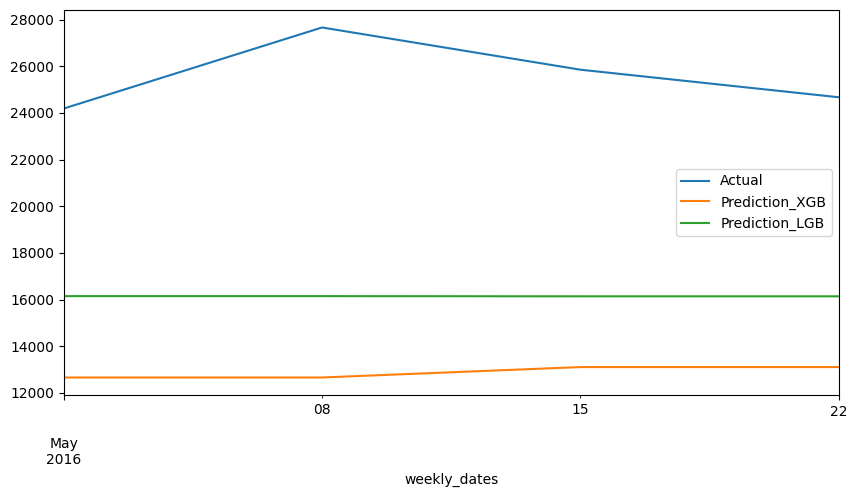

RMSSE XGB:
5.597482803984504
RMSSE LGB:
4.17785072279376


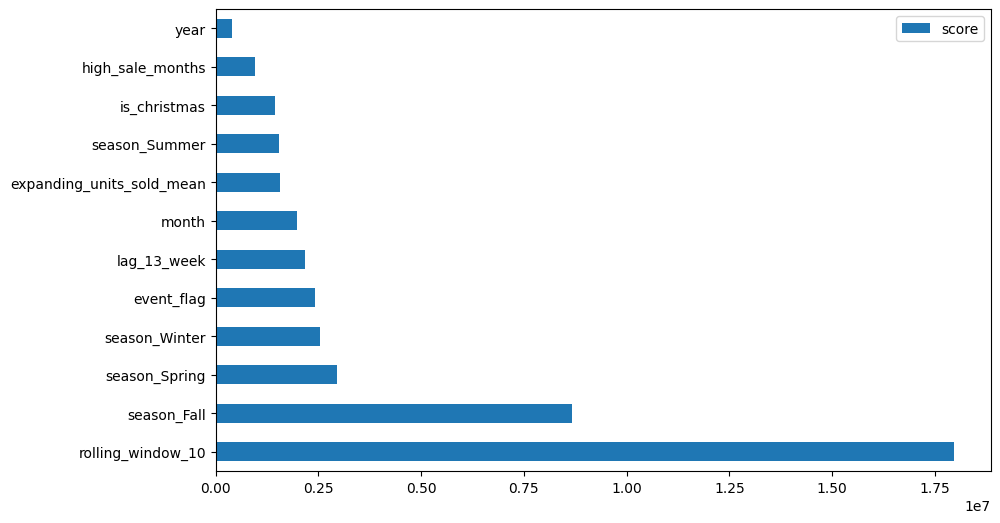

[0]	validation_0-rmse:14520.47613
[1]	validation_0-rmse:14718.40813
[2]	validation_0-rmse:14909.23070
[3]	validation_0-rmse:15093.17641
[4]	validation_0-rmse:15270.47236
[5]	validation_0-rmse:15514.88917
[6]	validation_0-rmse:15678.68049
[7]	validation_0-rmse:15847.97179
[8]	validation_0-rmse:16066.83149
[9]	validation_0-rmse:16241.40388
[10]	validation_0-rmse:16446.25568
[11]	validation_0-rmse:16606.72099
[12]	validation_0-rmse:16798.76263
[13]	validation_0-rmse:16983.95578
[14]	validation_0-rmse:17162.53210
[15]	validation_0-rmse:17321.93961
[16]	validation_0-rmse:17466.53921
[17]	validation_0-rmse:17597.71747
[18]	validation_0-rmse:17741.25661
[19]	validation_0-rmse:17902.49011
[20]	validation_0-rmse:18036.46185
[21]	validation_0-rmse:18187.85540
[22]	validation_0-rmse:18338.14058
[23]	validation_0-rmse:18475.82106
[24]	validation_0-rmse:18627.08394
[25]	validation_0-rmse:18704.24262
[26]	validation_0-rmse:18837.73320
[27]	validation_0-rmse:18966.42560
[28]	validation_0-rmse:19109.9

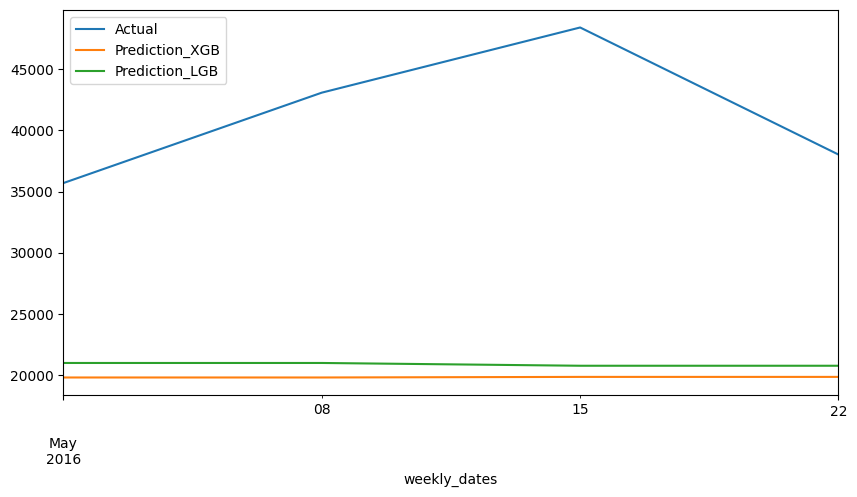

RMSSE XGB:
4.396352306951839
RMSSE LGB:
4.195025452796667


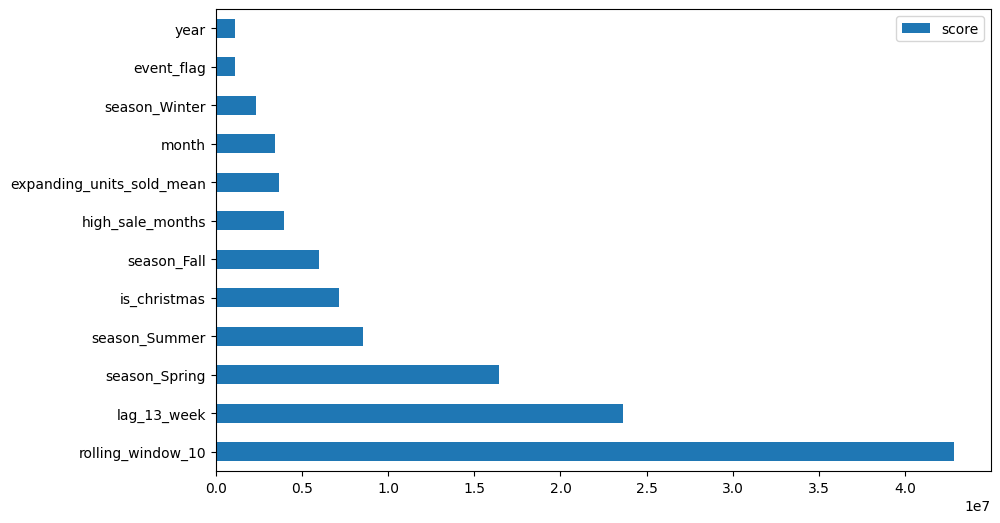

[0]	validation_0-rmse:25428.14574
[1]	validation_0-rmse:26607.94723
[2]	validation_0-rmse:27746.26634
[3]	validation_0-rmse:28843.95951
[4]	validation_0-rmse:29902.00341
[5]	validation_0-rmse:30921.47332
[6]	validation_0-rmse:31903.48997
[7]	validation_0-rmse:32859.20376
[8]	validation_0-rmse:33779.46287
[9]	validation_0-rmse:34586.45978
[10]	validation_0-rmse:35490.49270
[11]	validation_0-rmse:36362.10533
[12]	validation_0-rmse:37202.35950
[13]	validation_0-rmse:38012.30811
[14]	validation_0-rmse:38792.97173
[15]	validation_0-rmse:39545.35138
[16]	validation_0-rmse:40270.42627
[17]	validation_0-rmse:40969.14956
[18]	validation_0-rmse:41642.43816
[19]	validation_0-rmse:42291.19852
[20]	validation_0-rmse:42852.86940
[21]	validation_0-rmse:43457.45064
[22]	validation_0-rmse:44039.93860
[23]	validation_0-rmse:44677.66977
[24]	validation_0-rmse:45344.08116
[25]	validation_0-rmse:45987.88641
[26]	validation_0-rmse:46562.90713
[27]	validation_0-rmse:47165.32964
[28]	validation_0-rmse:47747.2

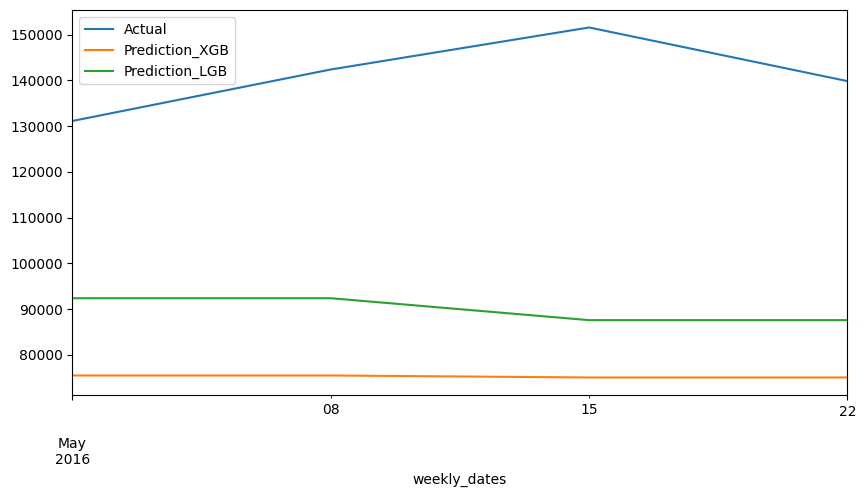

RMSSE XGB:
5.702455953580167
RMSSE LGB:
4.469652675441478


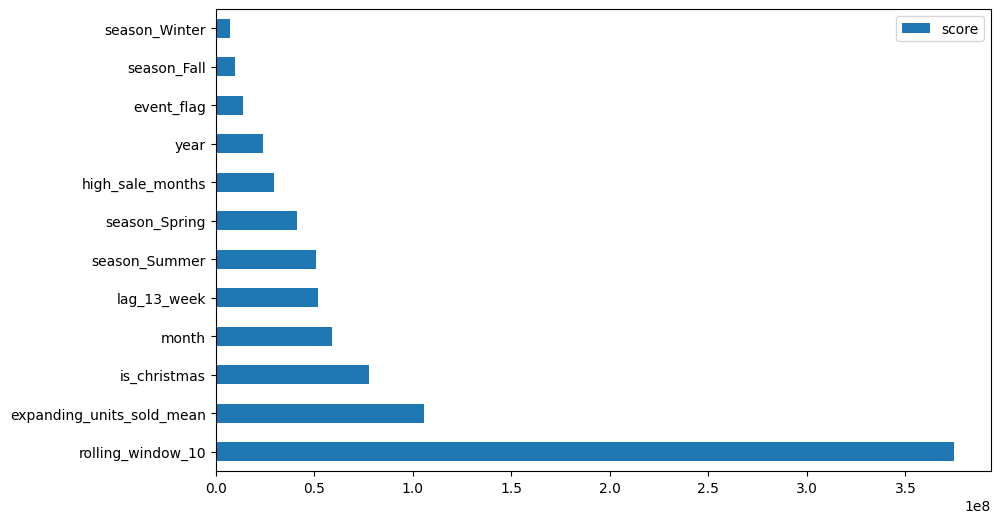

[0]	validation_0-rmse:5222.33157
[1]	validation_0-rmse:5228.29054
[2]	validation_0-rmse:5234.74751
[3]	validation_0-rmse:5241.66400
[4]	validation_0-rmse:5249.00148
[5]	validation_0-rmse:5256.72507
[6]	validation_0-rmse:5264.80161
[7]	validation_0-rmse:5273.19822
[8]	validation_0-rmse:5311.11274
[9]	validation_0-rmse:5356.28355
[10]	validation_0-rmse:5364.87940
[11]	validation_0-rmse:5373.70082
[12]	validation_0-rmse:5413.44959
[13]	validation_0-rmse:5436.75464
[14]	validation_0-rmse:5473.84138
[15]	validation_0-rmse:5509.69527
[16]	validation_0-rmse:5544.35668
[17]	validation_0-rmse:5577.86451
[18]	validation_0-rmse:5610.25708
[19]	validation_0-rmse:5596.02015
[20]	validation_0-rmse:5582.06911
[21]	validation_0-rmse:5623.88424
[22]	validation_0-rmse:5610.74090
[23]	validation_0-rmse:5597.86013
[24]	validation_0-rmse:5585.23827
[25]	validation_0-rmse:5572.86914
[26]	validation_0-rmse:5560.74707
[27]	validation_0-rmse:5548.86813
[28]	validation_0-rmse:5537.22652
[29]	validation_0-rmse:5

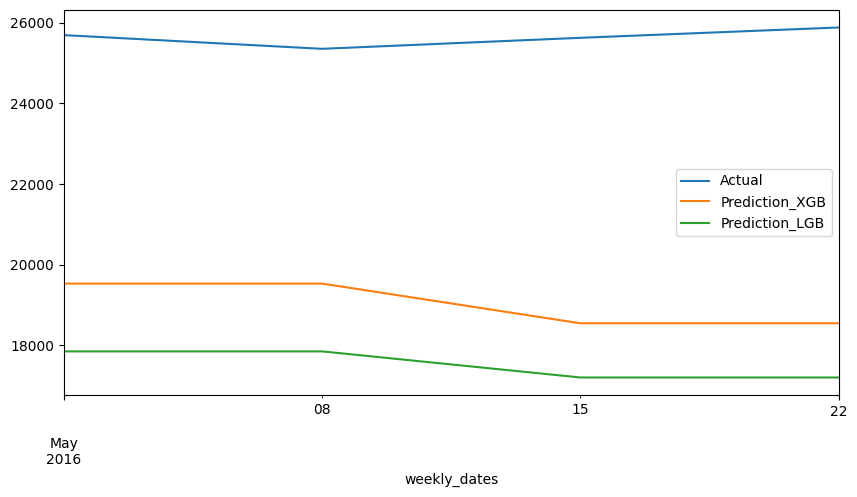

RMSSE XGB:
3.3868143602586596
RMSSE LGB:
4.151364028426503


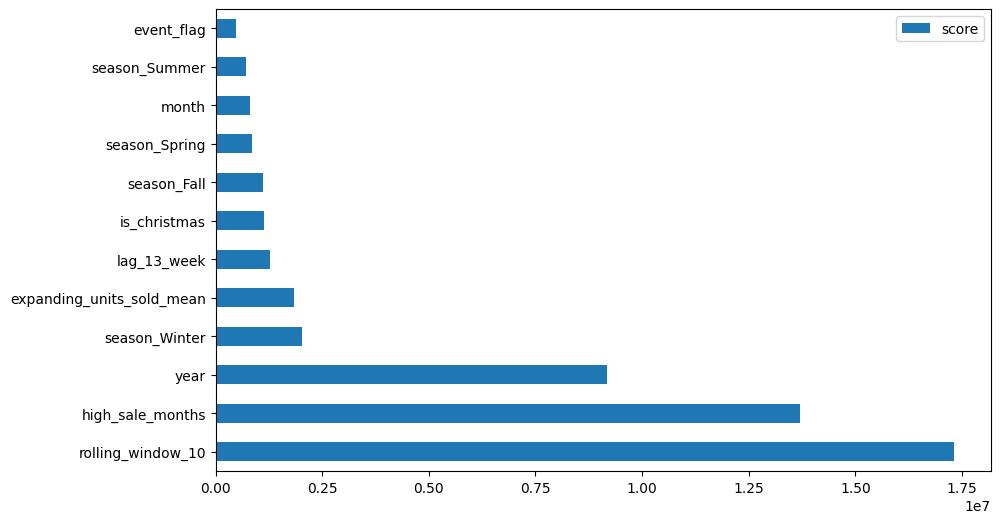

[0]	validation_0-rmse:1384.98460
[1]	validation_0-rmse:1366.46548
[2]	validation_0-rmse:1358.88448
[3]	validation_0-rmse:1343.33011
[4]	validation_0-rmse:1336.27389
[5]	validation_0-rmse:1321.89535
[6]	validation_0-rmse:1308.02979
[7]	validation_0-rmse:1294.65876
[8]	validation_0-rmse:1281.76477
[9]	validation_0-rmse:1267.56000
[10]	validation_0-rmse:1262.13055
[11]	validation_0-rmse:1256.84628
[12]	validation_0-rmse:1243.75482
[13]	validation_0-rmse:1238.84971
[14]	validation_0-rmse:1226.83662
[15]	validation_0-rmse:1228.04405
[16]	validation_0-rmse:1229.21535
[17]	validation_0-rmse:1230.00575
[18]	validation_0-rmse:1222.00315
[19]	validation_0-rmse:1225.62944
[20]	validation_0-rmse:1226.21700
[21]	validation_0-rmse:1226.79897
[22]	validation_0-rmse:1217.97460
[23]	validation_0-rmse:1218.41965
[24]	validation_0-rmse:1210.19810
[25]	validation_0-rmse:1210.52183
[26]	validation_0-rmse:1201.69824
[27]	validation_0-rmse:1193.19642
[28]	validation_0-rmse:1189.95306
[29]	validation_0-rmse:1

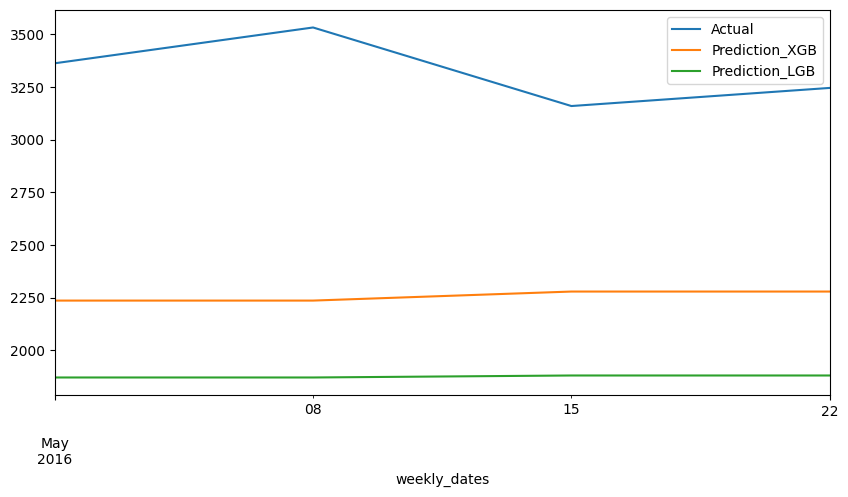

RMSSE XGB:
3.1177258131590424
RMSSE LGB:
4.207088053451929


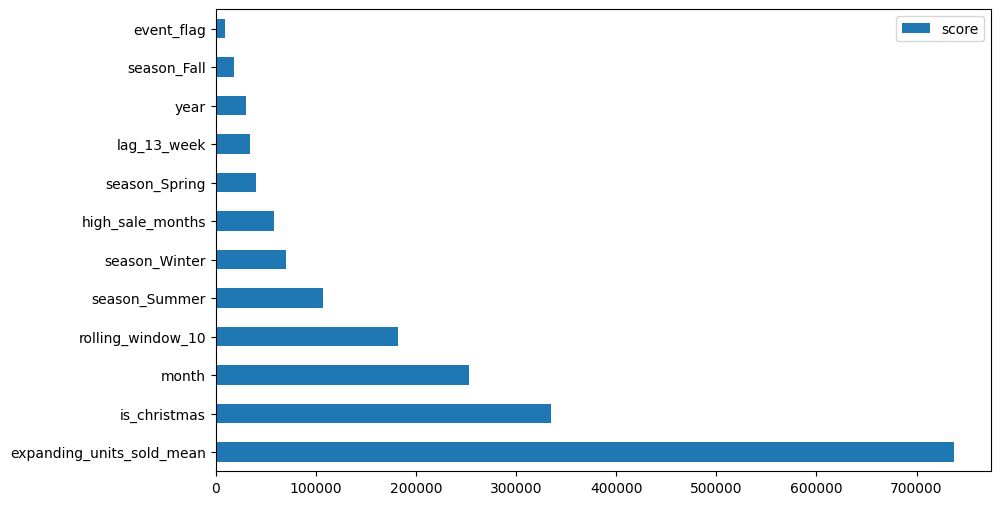

[0]	validation_0-rmse:14068.92292
[1]	validation_0-rmse:14752.90141
[2]	validation_0-rmse:15410.41064
[3]	validation_0-rmse:16042.46515
[4]	validation_0-rmse:16412.16463
[5]	validation_0-rmse:16997.75491
[6]	validation_0-rmse:17560.65352
[7]	validation_0-rmse:17886.77813
[8]	validation_0-rmse:18408.29357
[9]	validation_0-rmse:18726.52045
[10]	validation_0-rmse:19209.97324
[11]	validation_0-rmse:19674.67550
[12]	validation_0-rmse:20007.77409
[13]	validation_0-rmse:20275.67192
[14]	validation_0-rmse:20582.35536
[15]	validation_0-rmse:20981.62472
[16]	validation_0-rmse:21217.24676
[17]	validation_0-rmse:21429.60270
[18]	validation_0-rmse:21633.89248
[19]	validation_0-rmse:21830.42043
[20]	validation_0-rmse:22072.11327
[21]	validation_0-rmse:22194.00928
[22]	validation_0-rmse:22367.90111
[23]	validation_0-rmse:22535.18937
[24]	validation_0-rmse:22696.11967
[25]	validation_0-rmse:22796.62642
[26]	validation_0-rmse:22893.68629
[27]	validation_0-rmse:22987.41847
[28]	validation_0-rmse:23197.4

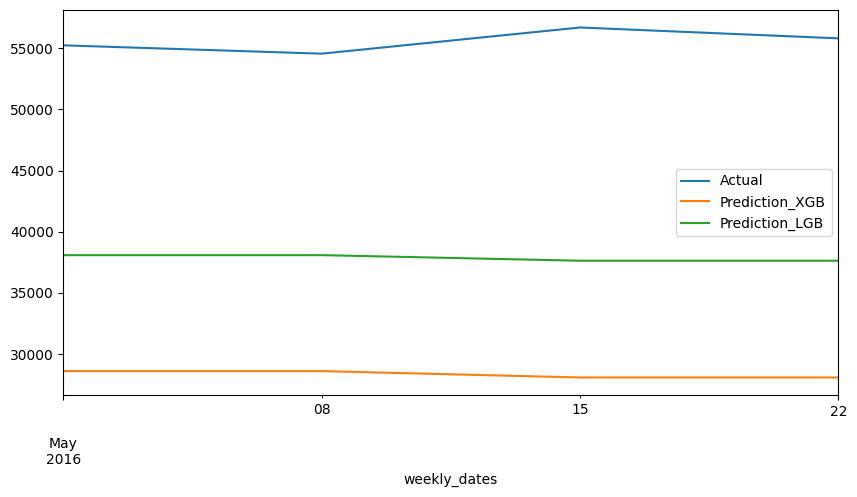

RMSSE XGB:
8.32718461581377
RMSSE LGB:
5.422755181371713


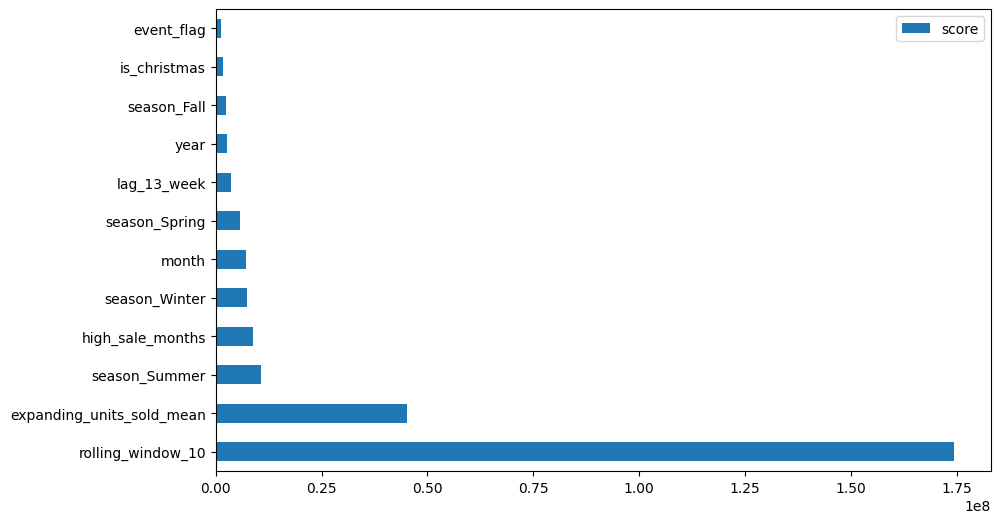

[0]	validation_0-rmse:4467.83840
[1]	validation_0-rmse:4495.09054
[2]	validation_0-rmse:4521.43738
[3]	validation_0-rmse:4546.90862
[4]	validation_0-rmse:4571.53287
[5]	validation_0-rmse:4595.33883
[6]	validation_0-rmse:4618.35352
[7]	validation_0-rmse:4646.91368
[8]	validation_0-rmse:4674.71510
[9]	validation_0-rmse:4701.77783
[10]	validation_0-rmse:4722.34436
[11]	validation_0-rmse:4748.14140
[12]	validation_0-rmse:4773.25230
[13]	validation_0-rmse:4797.69617
[14]	validation_0-rmse:4821.49033
[15]	validation_0-rmse:4826.31961
[16]	validation_0-rmse:4831.05227
[17]	validation_0-rmse:4835.69000
[18]	validation_0-rmse:4856.12876
[19]	validation_0-rmse:4860.58183
[20]	validation_0-rmse:4864.94591
[21]	validation_0-rmse:4899.77543
[22]	validation_0-rmse:4933.29692
[23]	validation_0-rmse:4965.56029
[24]	validation_0-rmse:4996.61170
[25]	validation_0-rmse:5036.82728
[26]	validation_0-rmse:5075.61799
[27]	validation_0-rmse:5113.03340
[28]	validation_0-rmse:5152.89045
[29]	validation_0-rmse:5

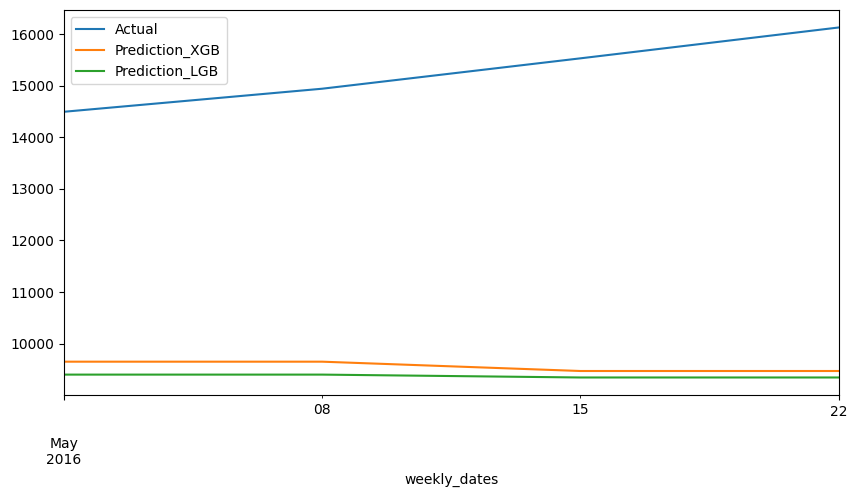

RMSSE XGB:
8.04202742802385
RMSSE LGB:
8.29391025903397


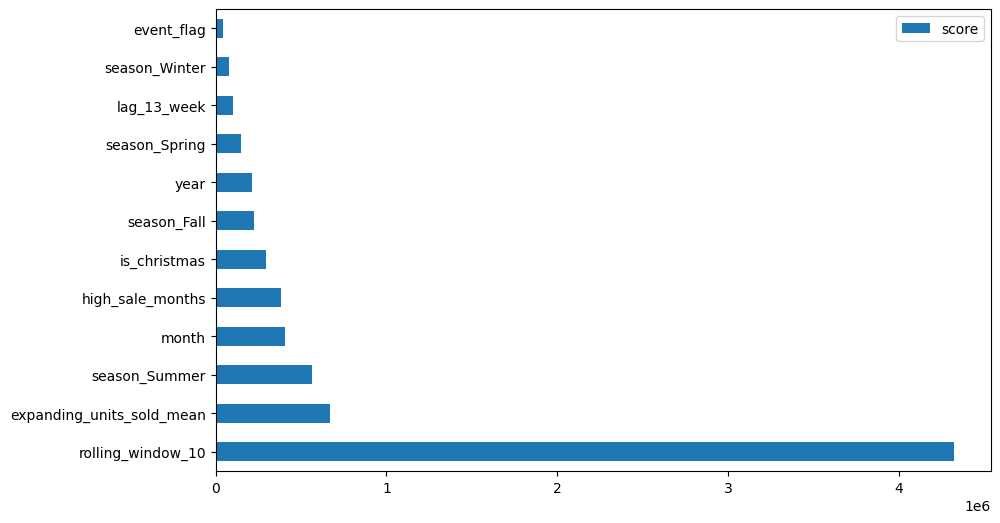

In [ ]:
# ML Models at department level with rmsse values
rmsse_xgb_values = []
rmsse_lgb_values = []
rmsse_xgb_department,rmsse_lgb_department = train_and_validate_models(train_dept,val_dept,'dept_id')
rmsse_lgb['Department'] = round(np.mean(rmsse_xgb_department),3)
rmsse_xgb['Department'] = round(np.mean(rmsse_lgb_department),3)
del rmsse_xgb_values,rmsse_lgb_values,rmsse_xgb_department,rmsse_lgb_department


## Aggregate Level : Category

In [ ]:
"""
Aggregation Level : Category
Function agg_data: Aggregate of train and val at higher level,
                   including date features
Function price_agg: Aggregation of sell price at dynamic level

"""
groupby_cat = ['cat_id']

train_cat = agg_data(train,groupby_cat)
days_train = train_cat['d'].unique().tolist()
val_cat = val[~(val['d'].isin(days_train))]
val_cat = agg_data(val_cat,groupby_cat)
del days_train

# Price for category
price_cat = price_agg(price,['cat_id'])

# Function call to resample daily data to weekly
train_cat = resample_daily_to_weekly(train_cat,['cat_id'])
val_cat = resample_daily_to_weekly(val_cat,['cat_id'])

# Merge of train and val dataframes with price features
train_cat = train_cat.merge(price_cat,on=['cat_id']).drop_duplicates()
val_cat = val_cat.merge(price_cat,on=['cat_id']).drop_duplicates()

[0]	validation_0-rmse:47023.47193
[1]	validation_0-rmse:48569.64682
[2]	validation_0-rmse:50059.30930
[3]	validation_0-rmse:51548.76837
[4]	validation_0-rmse:52983.34199
[5]	validation_0-rmse:54364.74063
[6]	validation_0-rmse:55694.69490
[7]	validation_0-rmse:56873.98590
[8]	validation_0-rmse:58008.97806
[9]	validation_0-rmse:59120.10934
[10]	validation_0-rmse:60198.84889
[11]	validation_0-rmse:61223.12217
[12]	validation_0-rmse:62282.21704
[13]	validation_0-rmse:63293.31238
[14]	validation_0-rmse:64383.76441
[15]	validation_0-rmse:65324.20611
[16]	validation_0-rmse:66342.30988
[17]	validation_0-rmse:67323.40384
[18]	validation_0-rmse:68268.77752
[19]	validation_0-rmse:69197.25359
[20]	validation_0-rmse:70091.66296
[21]	validation_0-rmse:71051.83910
[22]	validation_0-rmse:71977.86415
[23]	validation_0-rmse:72870.92369
[24]	validation_0-rmse:73742.95031
[25]	validation_0-rmse:74579.16277
[26]	validation_0-rmse:75385.53113
[27]	validation_0-rmse:76179.19086
[28]	validation_0-rmse:76934.1

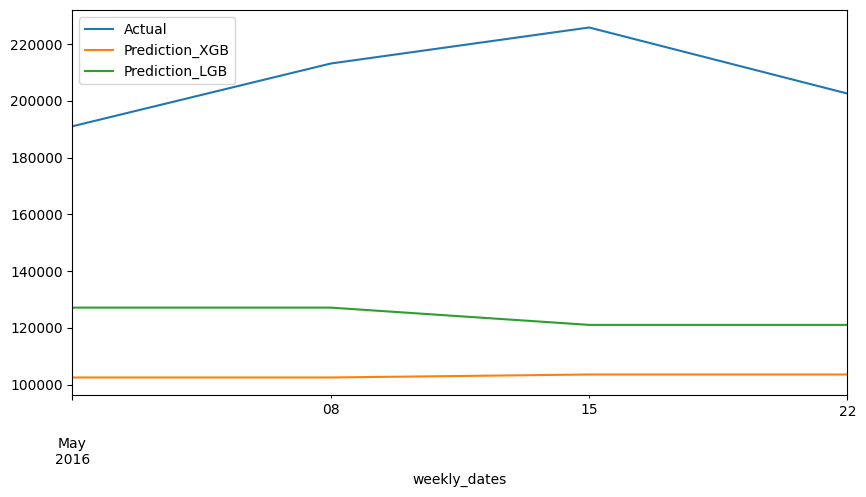

RMSSE XGB:
6.193135264830762
RMSSE LGB:
4.990600790142234


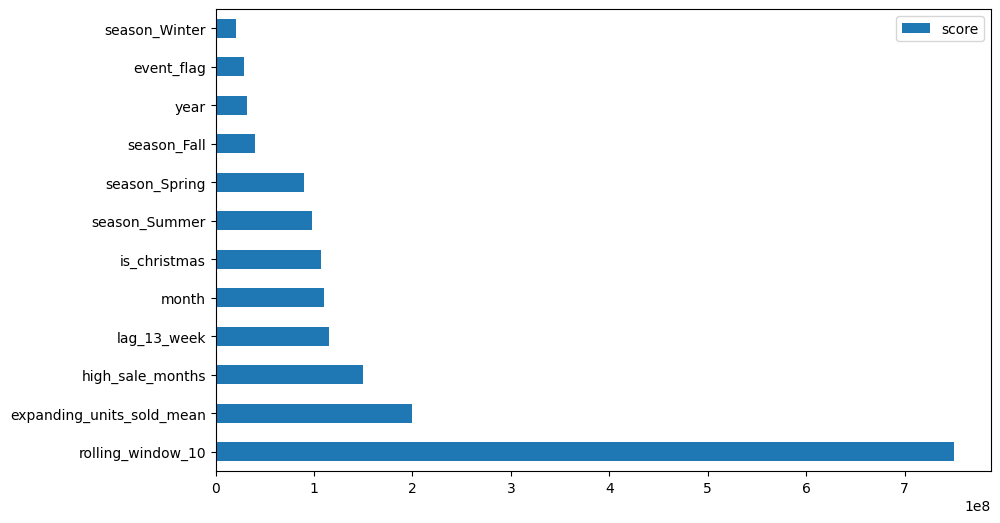

[0]	validation_0-rmse:6726.91950
[1]	validation_0-rmse:6837.65925
[2]	validation_0-rmse:6944.46297
[3]	validation_0-rmse:7047.46905
[4]	validation_0-rmse:7146.81433
[5]	validation_0-rmse:7201.00778
[6]	validation_0-rmse:7293.99356
[7]	validation_0-rmse:7351.44265
[8]	validation_0-rmse:7407.05454
[9]	validation_0-rmse:7460.88741
[10]	validation_0-rmse:7512.99800
[11]	validation_0-rmse:7638.74558
[12]	validation_0-rmse:7759.65663
[13]	validation_0-rmse:7795.46766
[14]	validation_0-rmse:7924.46806
[15]	validation_0-rmse:8048.65349
[16]	validation_0-rmse:8168.20323
[17]	validation_0-rmse:8283.28920
[18]	validation_0-rmse:8394.07922
[19]	validation_0-rmse:8500.73362
[20]	validation_0-rmse:8603.40642
[21]	validation_0-rmse:8702.24569
[22]	validation_0-rmse:8797.39666
[23]	validation_0-rmse:8867.41778
[24]	validation_0-rmse:8957.45220
[25]	validation_0-rmse:9046.61981
[26]	validation_0-rmse:9129.98959
[27]	validation_0-rmse:9212.82812
[28]	validation_0-rmse:9254.15971
[29]	validation_0-rmse:9

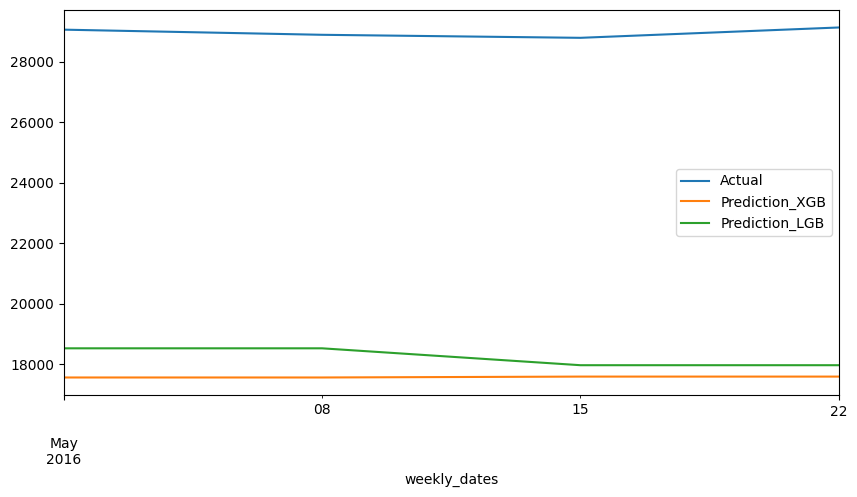

RMSSE XGB:
5.538094957981809
RMSSE LGB:
5.213875414687538


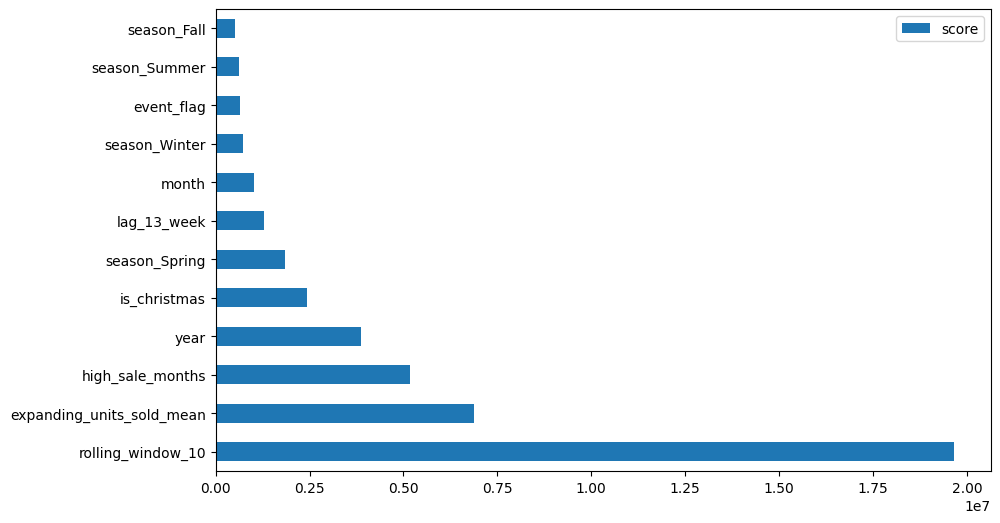

[0]	validation_0-rmse:18783.64821
[1]	validation_0-rmse:19490.02986
[2]	validation_0-rmse:20168.77507
[3]	validation_0-rmse:20870.70751
[4]	validation_0-rmse:21498.33128
[5]	validation_0-rmse:22148.78543
[6]	validation_0-rmse:22774.04417
[7]	validation_0-rmse:23332.50317
[8]	validation_0-rmse:23911.89378
[9]	validation_0-rmse:24468.82833
[10]	validation_0-rmse:24965.73972
[11]	validation_0-rmse:25481.81375
[12]	validation_0-rmse:25977.87705
[13]	validation_0-rmse:26279.92237
[14]	validation_0-rmse:26783.44145
[15]	validation_0-rmse:27225.35348
[16]	validation_0-rmse:27674.57721
[17]	validation_0-rmse:27930.44733
[18]	validation_0-rmse:28325.26957
[19]	validation_0-rmse:28727.58786
[20]	validation_0-rmse:29133.59298
[21]	validation_0-rmse:29506.05579
[22]	validation_0-rmse:29882.66815
[23]	validation_0-rmse:30411.22819
[24]	validation_0-rmse:30925.70892
[25]	validation_0-rmse:31489.55967
[26]	validation_0-rmse:32042.14924
[27]	validation_0-rmse:32583.70267
[28]	validation_0-rmse:33114.4

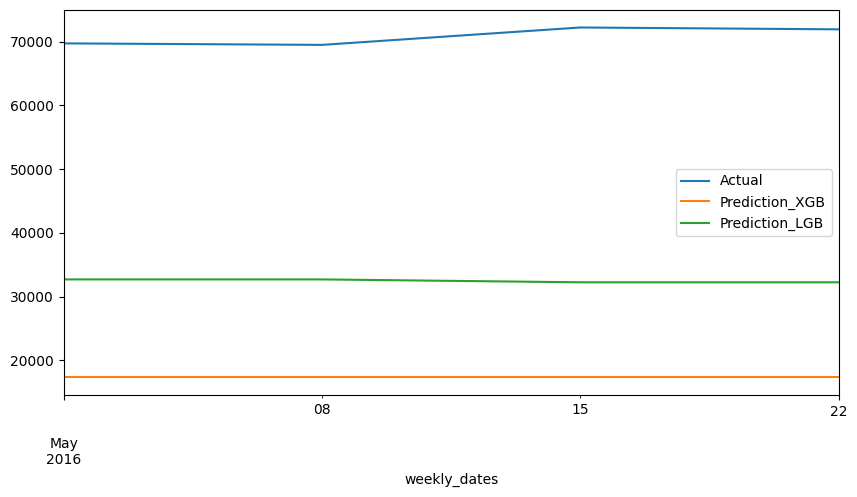

RMSSE XGB:
14.139202430606687
RMSSE LGB:
10.139991259227704


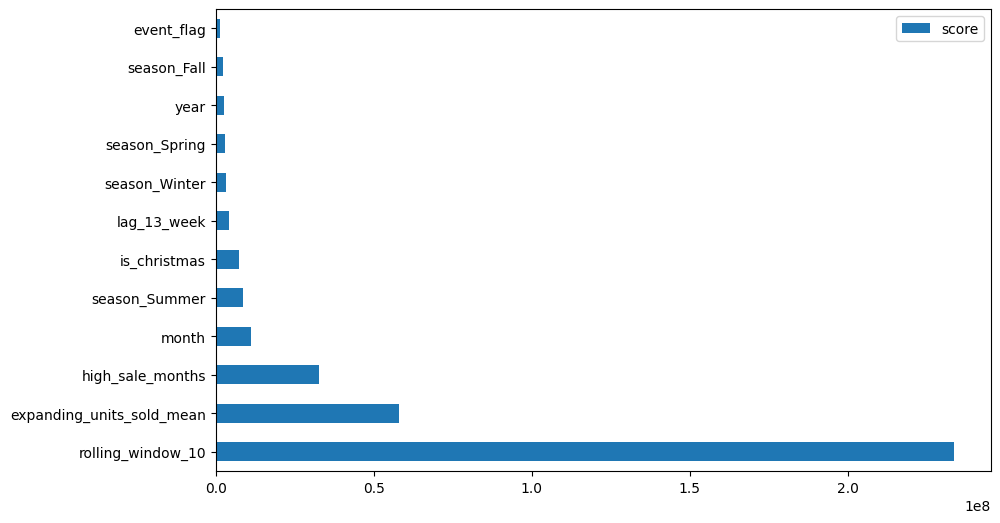

In [ ]:
# ML Models at category level with rmsse values
rmsse_xgb_values = []
rmsse_lgb_values = []
rmsse_xgb_category,rmsse_lgb_category = train_and_validate_models(train_cat,val_cat,'cat_id')
rmsse_lgb['Category'] = round(np.mean(rmsse_xgb_category),3)
rmsse_xgb['Category'] = round(np.mean(rmsse_lgb_category),3)
del rmsse_xgb_values,rmsse_lgb_values,rmsse_xgb_category,rmsse_lgb_category


# KPI Summary

In [ ]:
lgb_df = pd.DataFrame(list(rmsse_xgb.items()), columns=['Metric', 'LGBM'])
xgb_df = pd.DataFrame(list(rmsse_lgb.items()), columns=['Metric', 'XGB'])

# Merge the DataFrames on the 'Metric' column
combined_df = pd.merge(lgb_df, xgb_df, on='Metric', how='outer')
combined_df

Metric   LGBM    XGB
0             Category  4.408  4.822
1           Department  4.356  4.739
2                State  4.322  4.698
3   State and category  4.835  4.334
4  State and deparment  4.768  4.315
5   Store and category  4.281  4.632

On an average, XGB performs better across individual metrics (Category, Department, Store) compared to LGBM which excels in combined metrics (State and Category, State and Department), which suggests it handles interactions more effectively.

In [ ]:
!pip install nixtla

In [ ]:
def prepare_foods_data(train, val, price, calendar, foods_items, store_id, cols_to_merge, drop_cols):
    """
    Function to prepare training and validation data for food items.

    Parameters:
    - train: Training dataset (DataFrame)
    - val: Validation dataset (DataFrame)
    - price: Price dataset (DataFrame)
    - calendar: Calendar dataset (DataFrame)
    - foods_items: List of food item IDs (List)
    - store_id: Store ID to filter the data on (String)
    - cols_to_merge: Columns to merge on (List)
    - drop_cols: Columns to drop after merge (List)

    Returns:
    - foods_train: Prepared training dataset (DataFrame)
    - foods_val: Prepared validation dataset (DataFrame)
    """

    # Filter train, val, and price datasets by item ID and store ID
    foods_train = train[(train['item_id'].isin(foods_items)) & (train['store_id'] == store_id)]
    foods_val = val[(val['item_id'].isin(foods_items)) & (val['store_id'] == store_id)]
    foods_price = price[(price['item_id'].isin(foods_items)) & (price['store_id'] == store_id)]

    # Merge price data into train and val
    foods_train = foods_train.merge(foods_price, on=cols_to_merge).drop_duplicates()
    foods_val = foods_val.merge(foods_price, on=cols_to_merge).drop_duplicates()

    # Merge calendar data into train and val
    foods_train = foods_train.merge(calendar, on=['d', 'wm_yr_wk']).drop_duplicates()
    foods_val = foods_val.merge(calendar, on=['d', 'wm_yr_wk']).drop_duplicates()

    # Remove overlapping days between train and validation
    days_train = foods_train['d'].unique().tolist()
    foods_val = foods_val[~(foods_val['d'].isin(days_train))]

    # Clean up the 'days_train' variable
    del days_train

    # Rename columns
    foods_train.rename(columns={'date': 'ds', 'units_sold': 'y', 'item_id': 'unique_id'}, inplace=True)
    foods_val.rename(columns={'date': 'ds', 'units_sold': 'y', 'item_id': 'unique_id'}, inplace=True)

    # Select only relevant columns
    foods_train = foods_train[['unique_id', 'ds', 'y','sell_price', 'event_name_1', 'snap_WI']]
    foods_val = foods_val[['unique_id', 'ds', 'y','sell_price', 'event_name_1', 'snap_WI']]

    return foods_train, foods_val

In [ ]:
# Define your list of items, store ID, and columns for merging
foods_3_items = ['FOODS_3_001', 'FOODS_3_002', 'FOODS_3_003', 'FOODS_3_004', 'FOODS_3_006', 'FOODS_3_008']
store_id = 'WI_1'
cols_to_merge = ['item_id', 'store_id', 'dept_id', 'cat_id', 'state_id']
drop_cols = ['d']  # If you need to drop any columns after merging, specify them here

# Call the function
foods_3_train, foods_3_val = prepare_foods_data(train, val, price, calendar, foods_3_items, store_id, cols_to_merge, drop_cols)

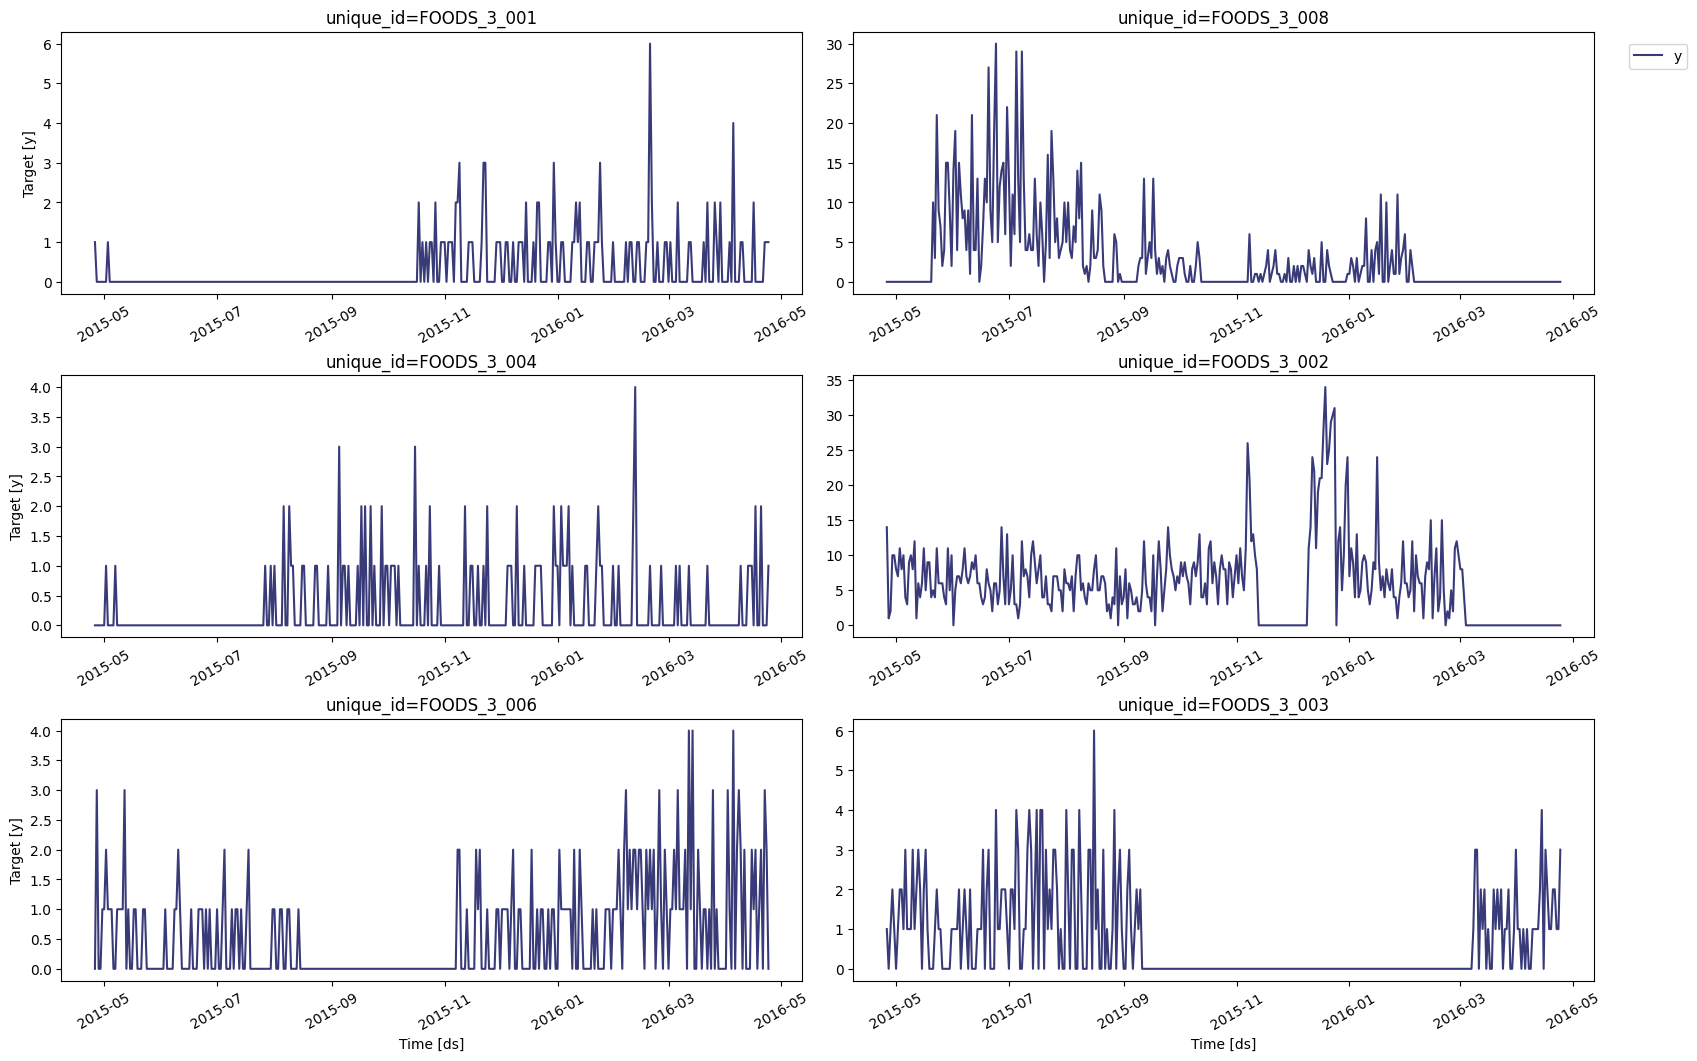

In [ ]:
# Time series plot of food items
nixtla_client.plot(
    foods_3_train,
    max_insample_length=365,
)

In [ ]:
def transform_foods_data(train_df, val_df, event_column, target_column):
    """
    Function to transform training and validation datasets for food items.

    Parameters:
    - train_df: Training dataset (DataFrame)
    - val_df: Validation dataset (DataFrame)
    - event_column: Column name with event information (String)
    - target_column: Column name with target variable to be log-transformed (String)

    Returns:
    - train_df_transformed: Transformed training dataset (DataFrame)
    - val_df_transformed: Transformed validation dataset (DataFrame)
    """

    # Copy datasets to avoid modifying the original DataFrames
    train_df_transformed = train_df.copy()
    val_df_transformed = val_df.copy()

    # Impute missing values in the event column with 0
    train_df_transformed[event_column] = train_df_transformed[event_column].cat.add_categories(0)
    val_df_transformed[event_column] = val_df_transformed[event_column].cat.add_categories(0)

    train_df_transformed[event_column] = train_df_transformed[event_column].fillna(0)
    val_df_transformed[event_column] = val_df_transformed[event_column].fillna(0)

    # Apply log transformation to the target column
    train_df_transformed[target_column] = np.log(train_df_transformed[target_column] + 1)
    val_df_transformed[target_column] = np.log(val_df_transformed[target_column] + 1)

    return train_df_transformed, val_df_transformed

In [ ]:
train_df_transformed, val_df_transformed = transform_foods_data(
    foods_3_train,
    foods_3_val,
    event_column='event_name_1',
    target_column='y'
)
train_df_transformed.head()

unique_id         ds    y  sell_price event_name_1  snap_WI
0  FOODS_3_001 2012-10-20  0.0         2.5            0        0
1  FOODS_3_001 2012-10-21  0.0         2.5            0        0
2  FOODS_3_001 2012-10-22  0.0         2.5            0        0
3  FOODS_3_001 2012-10-23  0.0         2.5            0        0
4  FOODS_3_001 2012-10-24  0.0         2.5            0        0

### Forecasting with TimeGPT model

In [ ]:
# Forecasting with timegpt
start = time.time()

fcst_df = nixtla_client.forecast(
    df=train_df_transformed,
    h=28,
    level=[80],                        # Generate a 80% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 5.183122634887695


In [ ]:
cols = [col for col in fcst_df.columns if col not in ['ds', 'unique_id']]

for col in cols:
    fcst_df[col] = np.exp(fcst_df[col])-1

fcst_df.head()

unique_id         ds   TimeGPT  TimeGPT-hi-80  TimeGPT-lo-80
0  FOODS_3_001 2016-04-25  0.015391       0.507908      -0.316258
1  FOODS_3_001 2016-04-26  0.002334       0.472270      -0.317603
2  FOODS_3_001 2016-04-27 -0.002621       0.540801      -0.354385
3  FOODS_3_001 2016-04-28 -0.004660       1.381512      -0.584003
4  FOODS_3_001 2016-04-29  1.004370       2.347581       0.200120

### Evaluation

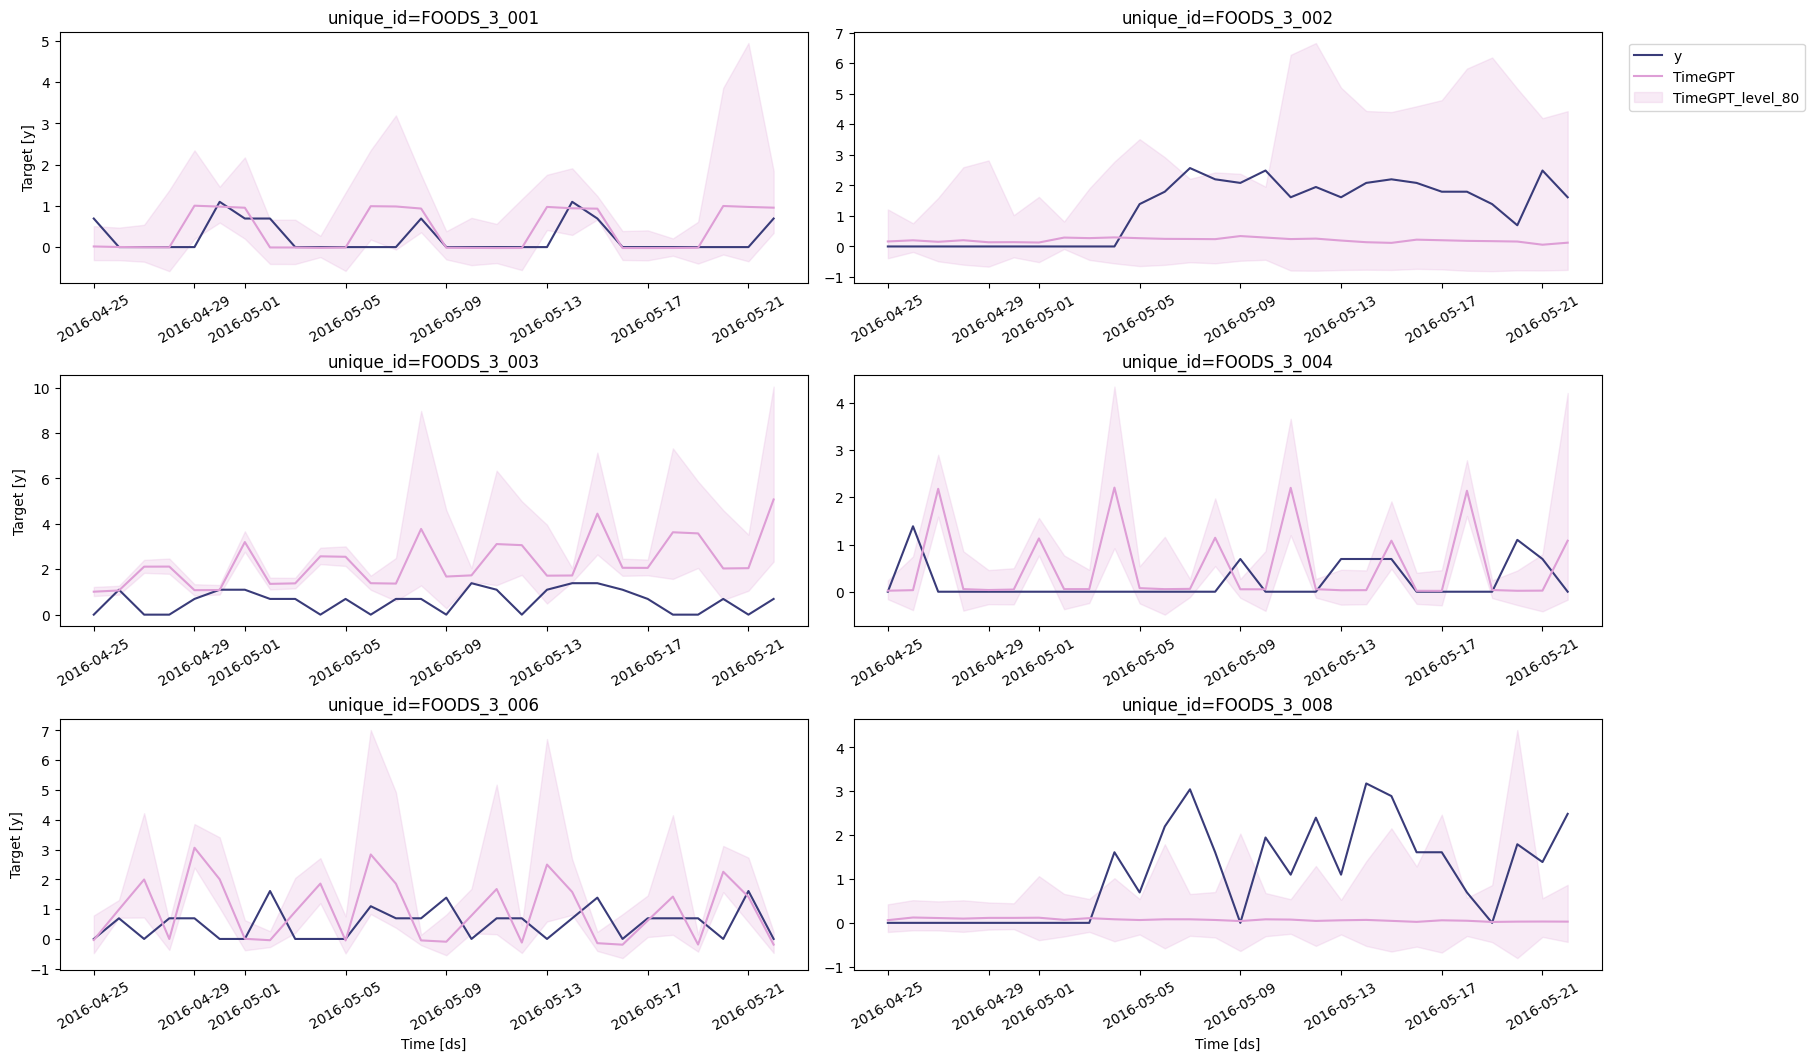

In [ ]:
nixtla_client.plot(val_df_transformed, fcst_df, models=['TimeGPT'], level=[80], time_col='ds', target_col='y')

In [ ]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

val_df_transformed = pd.merge(val_df_transformed, fcst_df, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    val_df_transformed,
    metrics=[mae],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

metric
mae    0.991168
Name: TimeGPT, dtype: float64

In [ ]:
# Forecast with statistical models
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, IMAPA, TSB

In [ ]:
models = [CrostonClassic(), CrostonOptimized(), IMAPA(), TSB(0.1, 0.1)]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

start = time.time()

sf.fit(df=train_df_transformed)

sf_preds = sf.predict(h=28)

end = time.time()

sf_duration = end - start

print(f"Statistical models took :{sf_duration}s")

Statistical models took :6.157320976257324s


In [ ]:
cols = [col for col in sf_preds.columns if col not in ['ds', 'unique_id']]

for col in cols:
    sf_preds[col] = np.exp(sf_preds[col])-1

sf_preds.head()

ds  CrostonClassic  CrostonOptimized     IMAPA       TSB
unique_id                                                                   
FOODS_3_001 2016-04-25        0.334305          0.334305  0.354892  0.414483
FOODS_3_001 2016-04-26        0.334305          0.334305  0.354892  0.414483
FOODS_3_001 2016-04-27        0.334305          0.334305  0.354892  0.414483
FOODS_3_001 2016-04-28        0.334305          0.334305  0.354892  0.414483
FOODS_3_001 2016-04-29        0.334305          0.334305  0.354892  0.414483

In [ ]:
# Evaluation
val_df_transformed = pd.merge(val_df_transformed, sf_preds, 'left', ['unique_id', 'ds'])
val_df_transformed.head(3)

unique_id         ds         y  sell_price event_name_1  snap_WI  \
0  FOODS_3_001 2016-04-25  0.693147    2.500000            0        0   
1  FOODS_3_002 2016-04-25  0.000000    2.500000            0        0   
2  FOODS_3_003 2016-04-25  0.000000    3.640625            0        0   

    TimeGPT  TimeGPT-hi-80  TimeGPT-lo-80  CrostonClassic  CrostonOptimized  \
0  0.015391       0.507908      -0.316258        0.334305          0.334305   
1  0.164121       1.212100      -0.387379        5.301538          5.584656   
2  1.011572       1.221940       0.821121        0.790349          0.811042   

      IMAPA       TSB  
0  0.354892  0.414483  
1  0.000000  0.007736  
2  1.434656  1.300580

In [ ]:
evaluation = evaluate(
    val_df_transformed,
    metrics=[mae],
    models=["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')[["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB"]].mean()
average_metrics

TimeGPT  CrostonClassic  CrostonOptimized     IMAPA       TSB
metric                                                                
mae     0.991168        1.127448          1.175866  0.732851  0.721586

TimeGPT has an mae score of 0.99 less than IMAPA and TSB but still better than CrostonClassic and CrostonOptimized.

### Forecasting with exogeneous variables

In [ ]:
# Forecasting with exogeneous variables
futr_exog_df = val_df_transformed.drop(["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB", "y", "TimeGPT-lo-80", "TimeGPT-hi-80","sell_price"], axis=1)
futr_exog_df.head()

unique_id         ds event_name_1  snap_WI
0  FOODS_3_001 2016-04-25            0        0
1  FOODS_3_002 2016-04-25            0        0
2  FOODS_3_003 2016-04-25            0        0
3  FOODS_3_004 2016-04-25            0        0
4  FOODS_3_006 2016-04-25            0        0

In [ ]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=train_df_transformed,
    X_df=futr_exog_df,
    h=28,
    level=[80],                        # Generate a 80% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 2.390094757080078


In [ ]:
fcst_df.rename(columns={
    'TimeGPT': 'TimeGPT_ex',
}, inplace=True)

cols = [col for col in fcst_df.columns if col not in ['ds', 'unique_id']]

for col in cols:
    fcst_df[col] = np.exp(fcst_df[col])-1

fcst_df.head()

unique_id         ds  TimeGPT_ex  TimeGPT-hi-80  TimeGPT-lo-80
0  FOODS_3_001 2016-04-25    0.014322       0.504839      -0.316307
1  FOODS_3_001 2016-04-26   -0.000458       0.466304      -0.318638
2  FOODS_3_001 2016-04-27   -0.003812       0.538558      -0.354987
3  FOODS_3_001 2016-04-28   -0.004994       1.379049      -0.583851
4  FOODS_3_001 2016-04-29    1.004642       2.351522       0.199033

In [ ]:
# Evaluation
val_df_transformed['TimeGPT_ex'] = fcst_df['TimeGPT_ex'].values
val_df_transformed.head()

unique_id         ds         y  sell_price event_name_1  snap_WI  \
0  FOODS_3_001 2016-04-25  0.693147    2.500000            0        0   
1  FOODS_3_002 2016-04-25  0.000000    2.500000            0        0   
2  FOODS_3_003 2016-04-25  0.000000    3.640625            0        0   
3  FOODS_3_004 2016-04-25  0.000000    5.980469            0        0   
4  FOODS_3_006 2016-04-25  0.000000    7.878906            0        0   

    TimeGPT  TimeGPT-hi-80  TimeGPT-lo-80  CrostonClassic  CrostonOptimized  \
0  0.015391       0.507908      -0.316258        0.334305          0.334305   
1  0.164121       1.212100      -0.387379        5.301538          5.584656   
2  1.011572       1.221940       0.821121        0.790349          0.811042   
3  0.021483       0.239213      -0.157991        0.202487          0.202487   
4 -0.034252       0.787304      -0.478170        0.868167          0.868167   

      IMAPA       TSB  TimeGPT_ex  
0  0.354892  0.414483    0.014322  
1  0.000000  0.007736   -0.000458  
2  1.434656  1.300580   -0.003812  
3  0.254625  0.322289   -0.004994  
4  0.845607  0.831615    1.004642

In [ ]:
evaluation = evaluate(
    val_df_transformed,
    metrics=[mae],
    models=["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB", "TimeGPT_ex"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')[["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB", "TimeGPT_ex"]].mean()
average_metrics

TimeGPT  CrostonClassic  CrostonOptimized     IMAPA       TSB  \
metric                                                                   
mae     0.991168        1.127448          1.175866  0.732851  0.721586   

        TimeGPT_ex  
metric              
mae       0.869121

Using exogeneous variables the mae score for TimeGPT_ex has reduced from 0.98 to 0.87. By addition of more input variables we can still make the model better.

## Findings and Summary:

1. Aggregating data at different levels of hierarchy can be beneficial, but it raises concerns regarding performance and scalability in real-world applications.

2. Effective feature engineering is crucial for enhancing the baseline forecast. More features could be worked on like price elasticity, tweaking special events, playing around more with the lag, rolling window features.

3. The daily data being right skewed tend to create more noise and forecast errors. Hence, aggregating the data to weekly level can facilitate better analysis and decision making from a demand planner prespective.

4. Traditionally, for forecasting intermittent demand traditional methods like CrostonClassic, TSB were used , the new library TimeGPT looks also appealing for forecasting demand with exogeneous variables.